### 卫星数据评估（0.37）

In [3]:
import pandas as pd
import numpy as np
import xarray as xr
import torch
import sys

# 添加你的自定义指标类的路径
sys.path.append(r"C:\Users\Administrator\Desktop\code\ST-Conv")
from metrics.metrics import CustomMetricCollection

def calculate_metrics_for_point(standard_point, verify_point):
    metric_collector = CustomMetricCollection()
    standard_tensor = torch.tensor(standard_point, dtype=torch.float32)
    verify_tensor = torch.tensor(verify_point, dtype=torch.float32)
    metric_collector.update(verify_tensor, standard_tensor)
    return metric_collector.calculate_averages()

def load_and_sync_data(verify_data_path, indices):
    verify_data = np.load(verify_data_path)
    verify_data_sync = verify_data[indices, :, :]  # 使用上述索引来同步验证数据
    return verify_data_sync

def main(verify_data_path,str):
    # 加载标准数据
    standard_data_path = r"D:/Data_Store/Dataset/Original_Data/0.37_Data.zarr"
    standard_data = xr.open_zarr(standard_data_path)['soil_moisture'].isel(time=slice(0, 8767))
        
    # 从标准数据中提取时间刻度为6和18小时的数据
    time_index = standard_data.indexes['time']
    # 找到小时为6和18的时间点的索引
    target_hours = [6, 18]
    indices = [i for i, t in enumerate(time_index.hour) if t in target_hours]
    
    # 同步验证数据
    verify_data_sync = load_and_sync_data(verify_data_path, indices)
    
    # 初始化指标矩阵
    lat, lon = standard_data.shape[1], standard_data.shape[2]
    metrics_keys = ['RMSE', 'MSE', 'MAE', 'R2', 'ubRMSE', 'PearsonR', 'Bias']
    metrics_matrices = {key: np.zeros((lat, lon)) for key in metrics_keys}
    
    # 对每个经纬度点计算指标
    for i in range(lat):
        for j in range(lon):
            standard_sync = standard_data.values[indices, i, j]
            verify_sync = verify_data_sync[:, i, j]
            
            # 检查标准数据是否全为0，如果是，则跳过计算
            if np.all(standard_sync == 0):
                for key in metrics_keys:
                    metrics_matrices[key][i, j] = np.nan
                continue

            # 质量控制：移除standard_sync中所有为nan的值及其在verify_sync中对应的值
            valid_indices = ~np.isnan(standard_sync)  # 获取非nan的索引
            standard_sync_filtered = standard_sync[valid_indices]
            verify_sync_filtered = verify_sync[valid_indices]

            # 检查过滤后的数据是否为空，如果为空，则跳过计算
            if len(standard_sync_filtered) == 0:
                for key in metrics_keys:
                    metrics_matrices[key][i, j] = np.nan
                continue

            # 计算指标
            metrics = calculate_metrics_for_point(standard_sync_filtered, verify_sync_filtered)

            # 保存指标结果
            for key in metrics_keys:
                metrics_matrices[key][i, j] = metrics.get(key, np.nan)

    for key in metrics_matrices:
        np.save(f"D:/Data_Store/Dataset/Results/{key}_{str}_0.37.npy", metrics_matrices[key])


# 示例调用
verify_data_path_rf = r"D:\Data_Store\Dataset\Reconstruction\RF\RF_reconstructed_data_0.37.npy"
verify_data_path_lstm = r"D:\Data_Store\Dataset\Reconstruction\LSTM\LSTM_0.37.npy"
verify_data_path_spatial_resnet34_temporal_usage_position_embedding_init256 = r"D:\Data_Store\Dataset\Reconstruction\ST\RES\spatial_resnet34_temporal_usage_position_embedding_init256.npy"
verify_data_path_spatial_unet_temporal_usage_position_embedding_init256 = r"D:\Data_Store\Dataset\Reconstruction\ST\RES\spatial_unet_temporal_usage_position_embedding_init256.npy"
verify_data_path_ST_ViT_serial_temporal_usage_position_embedding_individual_init256 = r"D:\Data_Store\Dataset\Reconstruction\ST\RES\ST_ViT_serial_temporal_usage_position_embedding_individual_init256.n16.npy" 
file_path3 = "D:\Data_Store\Dataset\Reconstruction\ST\RES\ST_resnet34_temporal_usage_position_embedding_init256.npy"
file_path4 = "D:\Data_Store\Dataset\Reconstruction\ST\RES\ST_unet_temporal_usage_position_embedding_init256.npy"
file_path6 = r"D:\Data_Store\Dataset\Reconstruction\ST\RES\temporal_temporal_usage_position_embedding.npy"
#main(verify_data_path_rf,'RF')
#main(verify_data_path_lstm, 'LSTM') 
main(verify_data_path_spatial_resnet34_temporal_usage_position_embedding_init256,'spatial_resnet34_temporal_usage_position_embedding_init256')
main(verify_data_path_spatial_unet_temporal_usage_position_embedding_init256,'spatial_unet_temporal_usage_position_embedding_init256')
main(verify_data_path_ST_ViT_serial_temporal_usage_position_embedding_individual_init256,'ST_ViT_serial_temporal_usage_position_embedding_individual_init256')
main(file_path3,'ST_resnet34_temporal_usage_position_embedding_init256')
main(file_path4,"ST_unet_temporal_usage_position_embedding_init256")
main(file_path6,'temporal_temporal_usage_position_embedding')

ValueError: unrecognized engine zarr must be one of: ['netcdf4', 'h5netcdf', 'scipy', 'rasterio', 'store']

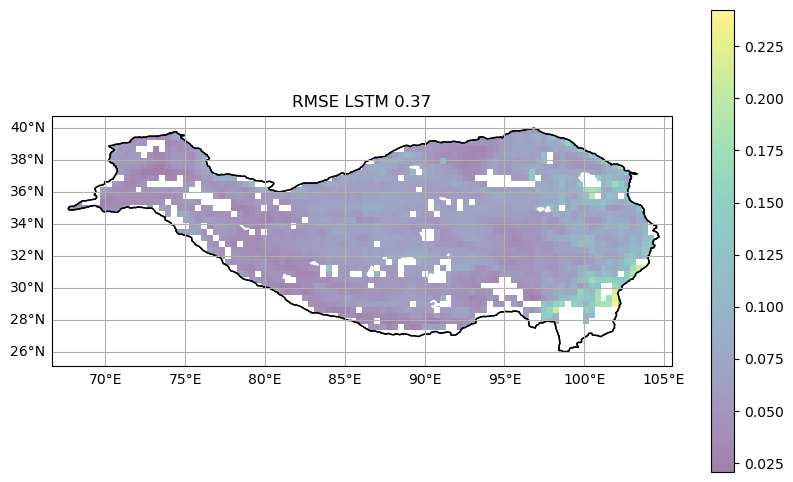

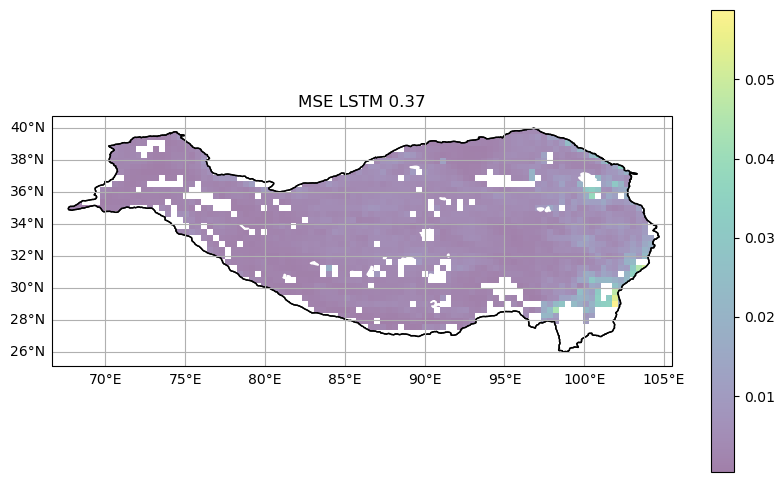

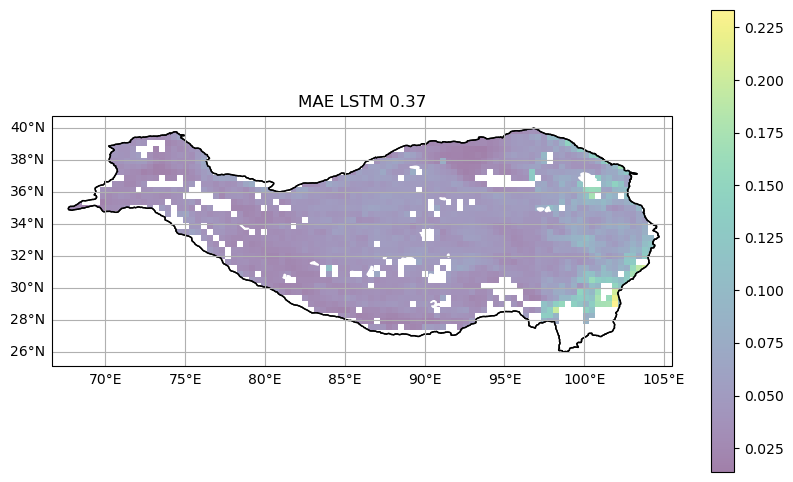

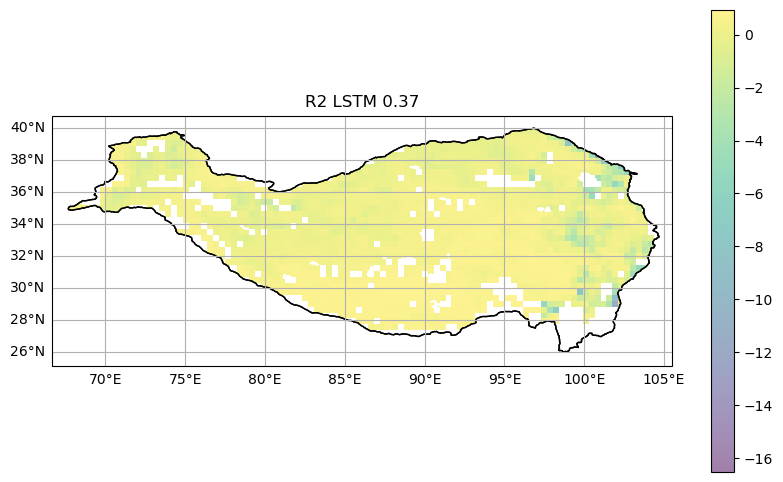

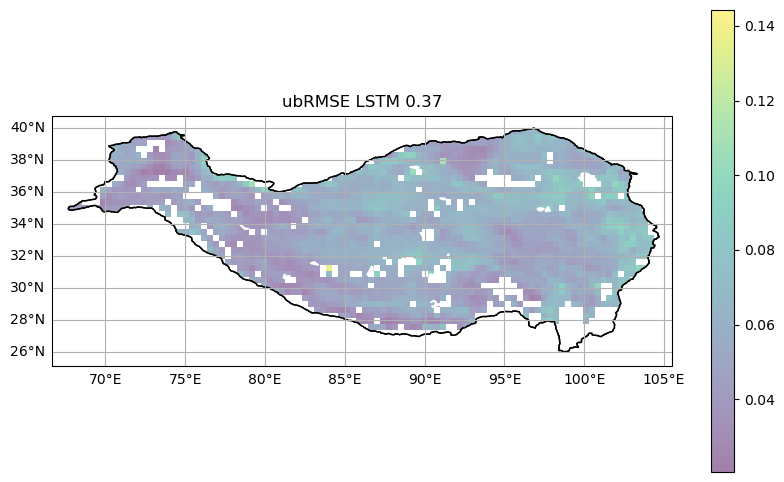

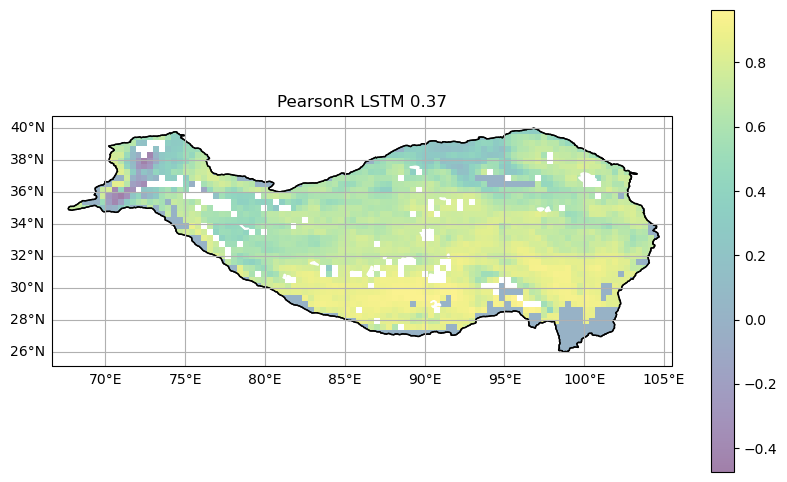

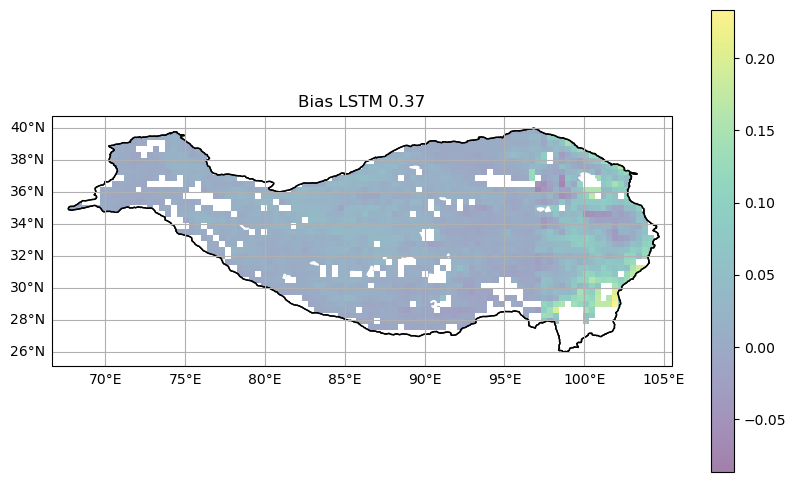

In [3]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.patches import PathPatch
from matplotlib.path import Path
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
def plot_data_with_shapefile(data_path, shp_path, lon, lat, title):
    data = np.load(data_path)
    gdf = gpd.read_file(shp_path)
    proj = ccrs.PlateCarree()
    fig, ax = plt.subplots(subplot_kw={'projection': proj}, figsize=(10, 6))
    mesh_lon, mesh_lat = np.meshgrid(lon, lat)
    mesh = ax.pcolormesh(mesh_lon, mesh_lat, data, transform=proj, cmap='viridis', alpha=0.5)
    geom = gdf.unary_union
    coords = np.array(geom.exterior.coords)
    codes = [Path.MOVETO] + [Path.LINETO] * (len(coords) - 2) + [Path.CLOSEPOLY]
    path = Path(coords, codes)
    patch = PathPatch(path, transform=proj._as_mpl_transform(ax), facecolor='none')
    ax.add_patch(patch)
    mesh.set_clip_path(patch)
    ax.add_geometries([geom], crs=proj, facecolor='none', edgecolor='black')

    ax.add_feature(cfeature.LAKES, color='white',edgecolor='white')

    fig.colorbar(mesh, ax=ax, orientation='vertical')

    lon_step = (lon[-1] - lon[0]) / (lon.size - 1)
    lat_step = (lat[-1] - lat[0]) / (lat.size - 1)

    ax.set_extent([lon.min() - lon_step / 2, lon.max() + lon_step / 2,
                lat.min() - lat_step / 2, lat.max() + lat_step / 2], crs=proj)

    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    # Set the title
    ax.set_title(title)

    plt.show()

metrics_keys = ['RMSE', 'MSE', 'MAE', 'R2', 'ubRMSE', 'PearsonR', 'Bias']
str_value = 'LSTM'  # 这里假设str变量的值为'RF'

lon_start = 66.84705
lat_start = 25.293533
num_lon = 104
num_lat = 42
lon_spacing = 0.37345
lat_spacing = 0.373446
lon = np.array([lon_start + i * lon_spacing for i in range(num_lon)])
lat = np.array([lat_start + i * lat_spacing for i in range(num_lat)])

shp_path = "D:\\Data_Store\\TPBoundary_new(2021)\\TPBoundary_new(2021).shp"


for i, key in enumerate(metrics_keys):
    data_path = f"D:/Data_Store/Dataset/Results/{key}_{str_value}_0.37.npy"
    plot_data_with_shapefile(data_path, shp_path, lon, lat, f"{key} {str_value} 0.37")

### 站点数据评估

In [4]:
import pandas as pd

# 定义时间点和网络名称
time_points = ['0', '3', '6', '9', '12', '15', '18', '21']
network_names = ['Shiquanhe', 'Ali', 'Maqu', 'Naqu', 'CTP']

# file_paths 已经给出
file_paths = {
    'KPNet-ST': "D:\Data_Store\Dataset\Reconstruction\ST\RES\STKPNET_station_time_metrics.xlsx",
    'KPNet-SP': "D:\Data_Store\Dataset\Reconstruction\ST\RES\SPKPNET_station_time_metrics.xlsx",
    'RF': "D:\Data_Store\Dataset\Reconstruction\RF\RF_station_time_metrics.xlsx",
    'LSTM': "D:\Data_Store\Dataset\Reconstruction\LSTM\LSTM_station_time_metrics.xlsx",
    'ResNet-ST': "D:\Data_Store\Dataset\Reconstruction\ST\RES\STRESNET_station_time_metrics.xlsx",
    'ResNet-SP': "D:\Data_Store\Dataset\Reconstruction\ST\RES\SPRESNET_station_time_metrics.xlsx",
    'UNet-ST': "D:\Data_Store\Dataset\Reconstruction\ST\RES\STUNET_station_time_metrics.xlsx",
    'UNet-SP': "D:\Data_Store\Dataset\Reconstruction\ST\RES\SPUNET_station_time_metrics.xlsx",
    'VIT-ST': "D:\Data_Store\Dataset\Reconstruction\ST\RES\STVIT_station_time_metrics.xlsx",
    'VIT-SP': "D:\Data_Store\Dataset\Reconstruction\ST\RES\SPVIT_station_time_metrics.xlsx",
    'Temporal': "D:\Data_Store\Dataset\Reconstruction\ST\RES\TEMPORAL_station_time_metrics.xlsx"
}

def create_combined_data(time_points, network_names, file_paths):
    all_data = {model: {time: {network: pd.DataFrame() for network in network_names} for time in time_points} for model in file_paths.keys()}
    
    for model, file_path in file_paths.items():
        xls = pd.ExcelFile(file_path)
        for time_point in time_points:
            networks_data = {network: pd.DataFrame() for network in network_names}
            for sheet_name in xls.sheet_names:
                if f"_{time_point}h" in sheet_name:
                    df = xls.parse(sheet_name)
                    split_data = df['站点名'].str.rsplit('_', n=2, expand=True)
                    df['point_name'] = split_data[0]
                    df['lon'] = split_data[1].astype(float)
                    df['lat'] = split_data[2].astype(float)
                    df_renamed = df.rename(columns={'PearsonR': 'R'})
                    df_sorted = df_renamed.sort_values(by=['lat', 'lon'], ascending=[False, True])
                    best_records = df_sorted.groupby(['lat', 'lon'], as_index=False).apply(lambda x: x.loc[x['R'].idxmax()]).reset_index(drop=True)
                    best_records = best_records[['point_name', 'lon', 'lat', 'RMSE', 'ubRMSE', 'R', 'Bias']]
                    for network in network_names:
                        if network in sheet_name:
                            networks_data[network] = pd.concat([networks_data[network], best_records], ignore_index=True)
            for network in network_names:
                all_data[model][time_point][network] = pd.concat([all_data[model][time_point][network], networks_data[network]], ignore_index=True)

    return all_data

# 使用函数并获取数据
all_data = create_combined_data(time_points, network_names, file_paths)
# 访问特定时间点和网络的数据
df_example = all_data['UNet-SP']['3']['Ali']
print(df_example.head(20))

  point_name        lon        lat      RMSE    ubRMSE         R      Bias
0      ALI03  79.650367  33.450153  0.051650  0.043592  0.663731  0.027704
1      ALI01  79.750367  33.450153  0.145259  0.023771  0.428282  0.143301


In [1]:
import pandas as pd

# 定义时间点和网络名称
time_points = ['0', '3', '6', '9', '12', '15', '18', '21']
network_names = ['Shiquanhe', 'Ali', 'Maqu', 'Naqu', 'CTP']

# file_paths 已经给出
file_paths = {
    'KPNet-ST': "D:\Data_Store\Dataset\Reconstruction\ST\RES\STKPNET_station_time_metrics.xlsx",
    'KPNet-SP': "D:\Data_Store\Dataset\Reconstruction\ST\RES\SPKPNET_station_time_metrics.xlsx",
    'RF': "D:\Data_Store\Dataset\Reconstruction\RF\RF_station_time_metrics.xlsx",
    'LSTM': "D:\Data_Store\Dataset\Reconstruction\LSTM\LSTM_station_time_metrics.xlsx",
    'ResNet-ST': "D:\Data_Store\Dataset\Reconstruction\ST\RES\STRESNET_station_time_metrics.xlsx",
    'ResNet-SP': "D:\Data_Store\Dataset\Reconstruction\ST\RES\SPRESNET_station_time_metrics.xlsx",
    'UNet-ST': "D:\Data_Store\Dataset\Reconstruction\ST\RES\STUNET_station_time_metrics.xlsx",
    'UNet-SP': "D:\Data_Store\Dataset\Reconstruction\ST\RES\SPUNET_station_time_metrics.xlsx",
    'VIT-ST': "D:\Data_Store\Dataset\Reconstruction\ST\RES\STVIT_station_time_metrics.xlsx",
    'VIT-SP': "D:\Data_Store\Dataset\Reconstruction\ST\RES\SPVIT_station_time_metrics.xlsx",
    'Temporal': "D:\Data_Store\Dataset\Reconstruction\ST\RES\TEMPORAL_station_time_metrics.xlsx"
}

def create_combined_data(time_points, network_names, file_paths):
    all_data = {model: {time: {network: pd.DataFrame() for network in network_names} for time in time_points} for model in file_paths.keys()}
    
    for model, file_path in file_paths.items():
        xls = pd.ExcelFile(file_path)
        for time_point in time_points:
            networks_data = {network: pd.DataFrame() for network in network_names}
            for sheet_name in xls.sheet_names:
                if f"_{time_point}h" in sheet_name:
                    df = xls.parse(sheet_name)
                    split_data = df['站点名'].str.rsplit('_', n=2, expand=True)
                    df['point_name'] = split_data[0]
                    df['lon'] = split_data[1].astype(float)
                    df['lat'] = split_data[2].astype(float)
                    df_renamed = df.rename(columns={'PearsonR': 'R'})
                    df_sorted = df_renamed.sort_values(by=['lat', 'lon'], ascending=[False, True])
                    df_sorted = df_sorted[['point_name', 'lon', 'lat', 'RMSE', 'ubRMSE', 'R', 'Bias']]
                    for network in network_names:
                        if network in sheet_name:
                            networks_data[network] = pd.concat([networks_data[network], df_sorted], ignore_index=True)
            for network in network_names:
                all_data[model][time_point][network] = pd.concat([all_data[model][time_point][network], networks_data[network]], ignore_index=True)

    return all_data
# 使用函数并获取数据
all_data = create_combined_data(time_points, network_names, file_paths)


In [2]:
# 访问特定时间点和网络的数据
df_example = all_data['UNet-SP']['3']['Ali']  # 举例：获取3:00的CTP网络的DataFrame
print(df_example.head(20))  # 打印示例数据查看

  point_name        lon        lat      RMSE    ubRMSE         R      Bias
0      ALI02  79.650367  33.450153  0.065343  0.028159  0.534694  0.058964
1      ALI03  79.650367  33.450153  0.051650  0.043592  0.663731  0.027704
2      ALI01  79.750367  33.450153  0.145259  0.023771  0.428282  0.143301


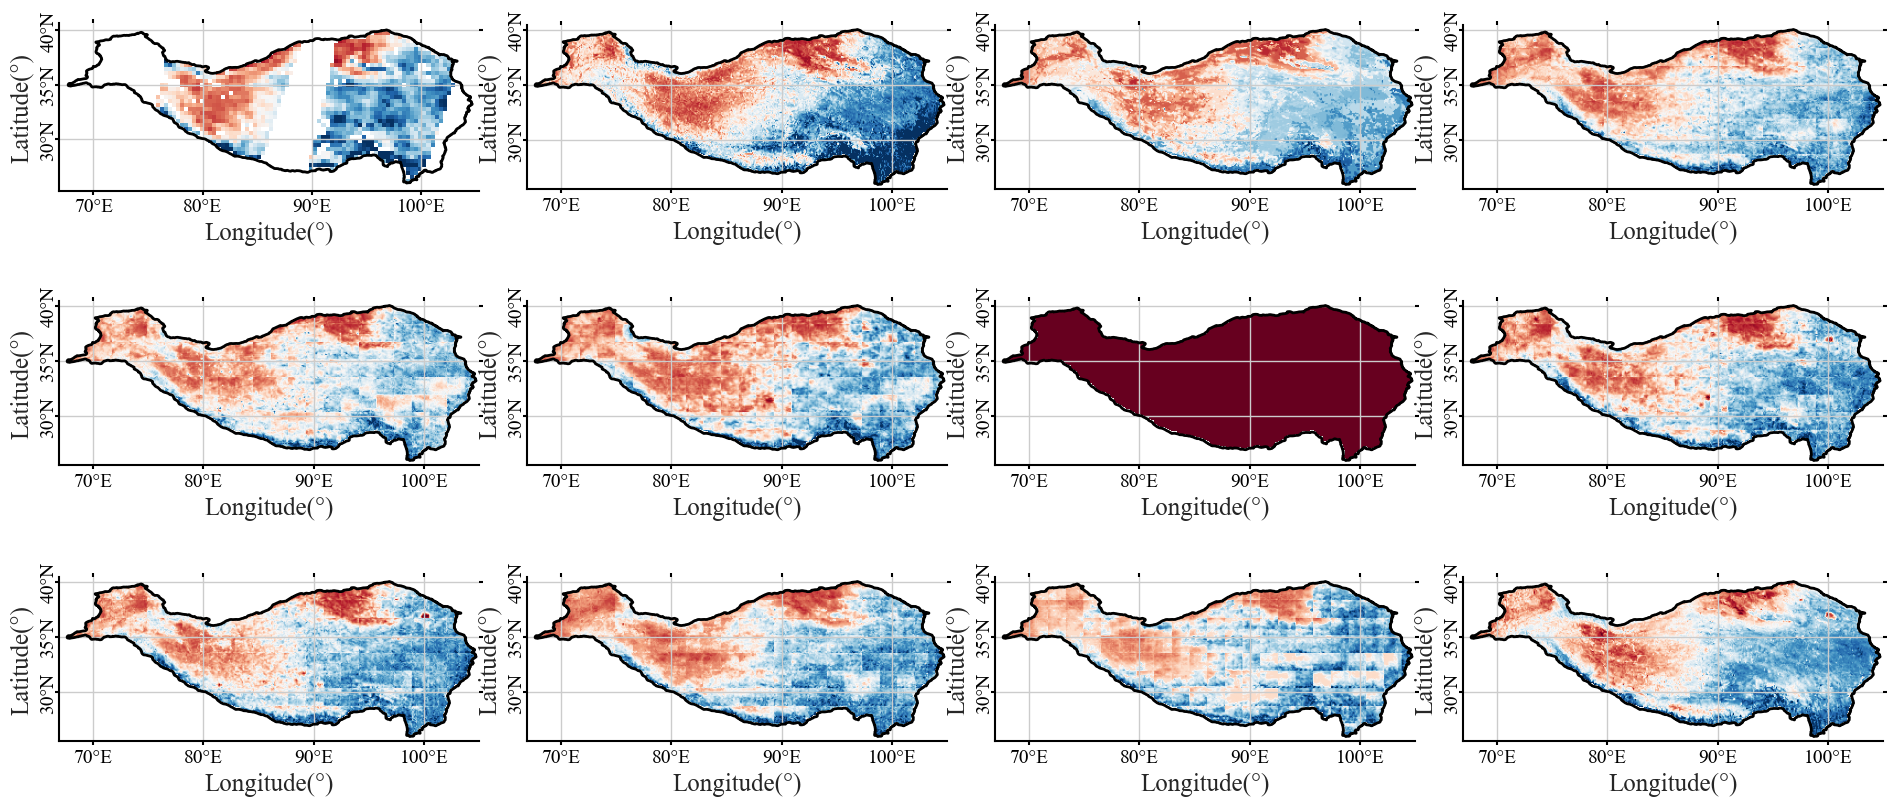

In [21]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import FuncFormatter
import geopandas as gpd
from shapely.geometry import Point

sns.set(style="whitegrid", font='Times New Roman')
matplotlib.rcParams['font.family'] = 'Times New Roman'
legend_font = FontProperties(family='Times New Roman', size=14)
font_prop = FontProperties(family='Times New Roman', size=16)

def add_degree_E(x, pos):
    return f"{int(x)}°E"

def add_degree_N(y, pos):
    return f"{int(y)}°N"
def apply_clipping(data, lon_grid, lat_grid, shp_path):
    """
    使用.shp文件裁剪数据：在边界外的数据设置为NaN。
    """
    gdf = gpd.read_file(shp_path)
    # 获取.shp文件的几何形状
    poly = gdf.unary_union

    clipped_data = np.full(data.shape, np.nan)

    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            point = Point(lon_grid[i, j], lat_grid[i, j])
            if point.within(poly):
                clipped_data[i, j] = data[i, j]

    return clipped_data
def create_subplots(reconstruction_paths):
    # 创建图形对象,绘制顺序依赖于fig定义顺序
    colors = ['#1f7ea1', '#1f7ea1', '#1f7ea1' ,'#274b91','#274b91', '#274b91', '#274b91','#274b91', '#274b91', '#274b91', '#1f7ea1']
    time_points = ['0', '3', '6', '9', '12', '15', '18', '21']
    fig = plt.figure(figsize=(24, 24))

    ratio_h = 7 # 竖直比例 3
    ratio_v = 4 # 水平比例

    absolute_dis_h = 0.7/ratio_h # 中央子图绝对大小（竖直）0.7
    absolute_dis_v = 0.7/ratio_v # 中央子图绝对大小（水平）

    edge_h = 0.335 # 竖直边缘间隙
    edge_v = 0.12 # 水平边缘间隙

    mid_h = (1-edge_h*2-absolute_dis_h*3)/2 # 竖直间隙,可以通过竖直边缘间隙调节
    mid_v = (1-edge_v*2-absolute_dis_v*4)/3 # 水平间隙……

    right_offset_first = 0 # 第一层向右偏移量

    # 计算第一层图起点:上层子图  左起点、下起点、宽度比例、高度比例
    ax1 = fig.add_axes([edge_v + right_offset_first, 1 - edge_h - absolute_dis_h, absolute_dis_v, absolute_dis_h])
    ax2 = fig.add_axes([edge_v + right_offset_first + absolute_dis_v + mid_v, 1 - edge_h - absolute_dis_h, absolute_dis_v, absolute_dis_h])
    ax3 = fig.add_axes([edge_v + right_offset_first + 2*(absolute_dis_v + mid_v), 1 - edge_h - absolute_dis_h, absolute_dis_v, absolute_dis_h])
    ax4 = fig.add_axes([edge_v + right_offset_first + 3*(absolute_dis_v + mid_v), 1 - edge_h - absolute_dis_h, absolute_dis_v, absolute_dis_h])

    ax5 = fig.add_axes([edge_v + right_offset_first, 1 - edge_h - 2*absolute_dis_h - mid_h, absolute_dis_v, absolute_dis_h])
    ax6 = fig.add_axes([edge_v + right_offset_first + absolute_dis_v + mid_v, 1 - edge_h - 2*absolute_dis_h - mid_h, absolute_dis_v, absolute_dis_h])
    ax7 = fig.add_axes([edge_v + right_offset_first + 2*(absolute_dis_v + mid_v), 1 - edge_h - 2*absolute_dis_h - mid_h, absolute_dis_v, absolute_dis_h])
    ax8 = fig.add_axes([edge_v + right_offset_first + 3*(absolute_dis_v + mid_v), 1 - edge_h - 2*absolute_dis_h - mid_h, absolute_dis_v, absolute_dis_h])

    ax9 = fig.add_axes([edge_v + right_offset_first, 1 - edge_h - 3*absolute_dis_h - 2*mid_h, absolute_dis_v, absolute_dis_h])
    ax10 = fig.add_axes([edge_v + right_offset_first + absolute_dis_v + mid_v, 1 - edge_h - 3*absolute_dis_h - 2*mid_h, absolute_dis_v, absolute_dis_h])
    ax11 = fig.add_axes([edge_v + right_offset_first + 2*(absolute_dis_v + mid_v), 1 - edge_h - 3*absolute_dis_h - 2*mid_h, absolute_dis_v, absolute_dis_h])
    ax12 = fig.add_axes([edge_v + right_offset_first + 3*(absolute_dis_v + mid_v), 1 - edge_h - 3*absolute_dis_h - 2*mid_h, absolute_dis_v, absolute_dis_h])

    axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12]

    for i, key in enumerate(reconstruction_paths.keys()):
        mode = 0.37 if i == 0 else 0.1
        draw_subplot(axes[i], reconstruction_paths[key],mode)
    fig.savefig(r"C:\Users\Administrator\Desktop\Draw\eval_darw.jpeg", dpi=500, format='jpeg', bbox_inches='tight')
    plt.show()

def draw_subplot(ax, data_path,mode):
    data = np.load(data_path)
    fill_time = 100
    time_ind = 4*fill_time+1
    # 数据裁剪
    shp_path = "D:\\Data_Store\\TPBoundary_new(2021)\\TPBoundary_new(2021).shp"
    gdf = gpd.read_file(shp_path)
    gdf.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1.5)
    if mode==0.1:
        lat_min, lat_max, lon_min, lon_max, lat_points, lon_points= 25.550117,40.450184,66.95031,104.95048,150,381
    else:
        lat_min, lat_max,lon_min, lon_max, lat_points, lon_points  = 25.293533, 40.604774, 66.84705, 105.31184, 42, 104
    lon_range, lat_range = np.linspace(lon_min, lon_max, lon_points), np.linspace(lat_min, lat_max, lat_points)
    lon_grid, lat_grid = np.meshgrid(lon_range, lat_range)
    clipped_data = apply_clipping(data[7817], lon_grid, lat_grid, shp_path)
    image = ax.imshow(clipped_data, cmap='RdBu', origin='lower', vmin=0, vmax=0.5, extent=[lon_min, lon_max, lat_min, lat_max])
    # 设置X轴和Y轴的标签
    ax.set_xlabel('Longitude(°)',size=18)
    ax.set_ylabel('Latitude(°)',size=18)
    ax.xaxis.set_major_formatter(FuncFormatter(add_degree_E))
    ax.yaxis.set_major_formatter(FuncFormatter(add_degree_N))
    ax.tick_params(axis='x', which='both', colors='black', length=3, width=1.5, labelsize=14, direction='out', pad=2, bottom=True, top=True, labelbottom=True,labeltop=False)
    ax.tick_params(axis='y', which='both', colors='black', length=3, width=1.5, labelsize=14, direction='out', pad=6, left=True, right=True, labelleft=True,labelright=False)
    plt.setp(ax.get_xticklabels(), rotation=0,rotation_mode="anchor")
    plt.setp(ax.get_yticklabels(), rotation=90,ha="center", rotation_mode="anchor")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('black')
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_color('black')
    ax.spines['left'].set_linewidth(1.5)


reconstruction_paths = {
    "Original": r"D:\Data_Store\Dataset\Reconstruction\37SM\soil_moisture.npy",
    "LSTM": r"D:\Data_Store\Dataset\Reconstruction\LSTM\LSTM1.npy",
    "RF": r"D:\Data_Store\Dataset\Reconstruction\RF\RF_reconstructed_data.npy",
    "TEMPORAL": r"D:\Data_Store\Dataset\Reconstruction\ST\RES168\temporal_temporal_usage_position_embedding.npy",
    "KPNET": r"D:\Data_Store\Dataset\Reconstruction\ST\RES1616\ST_kpnet_Encoder_lite_serial_temporal_usage_position_embedding_individual_init256_11_121_131_dropout_rate0.316.npy",
    "SPKPNET": r"D:\Data_Store\Dataset\Reconstruction\ST\RES1616\spatial_kpnet_Encoder_lite_serial_temporal_usage_position_embedding_individual_init25616.npy",
    "SPRESNET": r"D:\Data_Store\Dataset\Reconstruction\ST\RES1616\spatial_resnet34_temporal_usage_position_embedding_init25616.npy",
    "SPUNET": r"D:\Data_Store\Dataset\Reconstruction\ST\RES1616\spatial_unet_temporal_usage_position_embedding_init2561616.npy",
    "STRESNET": r"D:\Data_Store\Dataset\Reconstruction\ST\RES1616\ST_resnet34_temporal_usage_position_embedding_init25616.npy",
    "STUNET": r"D:\Data_Store\Dataset\Reconstruction\ST\RES1616\ST_unet_temporal_usage_position_embedding_init25616.npy",
    "STVIT": r"D:\Data_Store\Dataset\Reconstruction\ST\RES1616\ST_ViT_serial_temporal_usage_position_embedding_individual_init25616.npy",
    "SPVIT": r"D:\Data_Store\Dataset\Reconstruction\ST\RES1616\spatial_VIT_serial_temporal_usage_position_embedding_individual_init25616.npy"
}
create_subplots(reconstruction_paths)

In [10]:
import numpy as np
import geopandas as gpd
from shapely.geometry import Point

def generate_clipping_mask(lon_grid, lat_grid, shp_path):
    """
    使用.shp文件生成数据掩码：在边界外的数据掩码为0，在边界内的数据掩码为1。
    """

    gdf = gpd.read_file(shp_path)
    poly = gdf.unary_union
    mask = np.zeros_like(lon_grid, dtype=bool)

    for i in range(lon_grid.shape[0]):
        for j in range(lon_grid.shape[1]):
            point = Point(lon_grid[i, j], lat_grid[i, j])
            if point.within(poly):
                mask[i, j] = True

    return mask

shp_path = "D:\\Data_Store\\TPBoundary_new(2021)\\TPBoundary_new(2021).shp"
lakes_path = r"D:\Data_Store\TPBoundary_new(2021)\Lake_TP_2010.shp"

reconstruction_paths = {
    "Original": r"D:\Data_Store\Dataset\Reconstruction\37SM\soil_moisture.npy",
    "LSTM": r"D:\Data_Store\Dataset\Reconstruction\LSTM\LSTM1.npy",
    "RF": r"D:\Data_Store\Dataset\Reconstruction\RF\RF_reconstructed_data.npy",
    "Temporal": r"D:\Data_Store\Dataset\Reconstruction\ST\RES1616\temporal_temporal_usage_position_embedding16.npy",
    "KPNet-ST": r"D:\Data_Store\Dataset\Reconstruction\ST\RES1616\ST_kpnet_Encoder_lite_serial_temporal_usage_position_embedding_individual_init256_11_121_131_dropout_rate0.316.npy",
    "UNet-ST": r"D:\Data_Store\Dataset\Reconstruction\ST\RES1616\ST_unet_temporal_usage_position_embedding_init25616.npy",
    "RESNet-ST": r"D:\Data_Store\Dataset\Reconstruction\ST\RES1616\ST_resnet34_temporal_usage_position_embedding_init25616.npy",
    "VIT-ST": r"D:\Data_Store\Dataset\Reconstruction\ST\RES1616\ST_ViT_serial_temporal_usage_position_embedding_individual_init25616.npy",
    "KPNet-SP": r"D:\Data_Store\Dataset\Reconstruction\ST\RES1616\spatial_kpnet_Encoder_lite_serial_temporal_usage_position_embedding_individual_init25616.npy",
    "UNet-SP": r"D:\Data_Store\Dataset\Reconstruction\ST\RES1616\spatial_unet_temporal_usage_position_embedding_init25616.npy",
    "RESNet-SP": r"D:\Data_Store\Dataset\Reconstruction\ST\RES1616\spatial_resnet34_temporal_usage_position_embedding_init25616.npy",
    "VIT-SP": r"D:\Data_Store\Dataset\Reconstruction\ST\RES1616\spatial_VIT_serial_temporal_usage_position_embedding_individual_init25616.npy"
}
settings = {
    0.37: (25.293533, 40.604774, 66.84705, 105.31184, 42, 104),
    0.1: (25.550117, 40.450184, 66.95031, 104.95048, 150, 381)
}
masks = {}
for mode, (lat_min, lat_max, lon_min, lon_max, lat_points, lon_points) in settings.items():
    lon_range, lat_range = np.linspace(lon_min, lon_max, lon_points), np.linspace(lat_min, lat_max, lat_points)
    lon_grid, lat_grid = np.meshgrid(lon_range, lat_range)
    masks[mode] = generate_clipping_mask(lon_grid, lat_grid, shp_path)
reconstruction_datas = {}
for i, (key, data_path) in enumerate(reconstruction_paths.items()):
    mode = 0.37 if i == 0 else 0.1
    mask = masks[mode]
    data = np.load(data_path)
    clipped_data = np.where(mask, data[7817], np.nan)
    reconstruction_datas[key] = clipped_data


In [11]:
import numpy as np

reconstruction_datas = {}

for i, (key, data_path) in enumerate(reconstruction_paths.items()):
    mode = 0.37 if i == 0 else 0.1  # 第一个数据用0.37模式，其他用0.1模式
    mask = masks[mode]  # 选择合适的掩码
    data = np.load(data_path)  # 加载整个数据集
    
    clipped_data = np.where(mask[None, :, :], data, np.nan)
    
    reconstruction_datas[key] = clipped_data  # 保存处理后的整个数据集


In [12]:
reconstruction_datas11 = reconstruction_datas
specific_time_slice =  7817 
reconstruction_datas = {}

for key, data in reconstruction_datas11.items():
    extracted_data = data[specific_time_slice, :, :]
    reconstruction_datas[key] = extracted_data

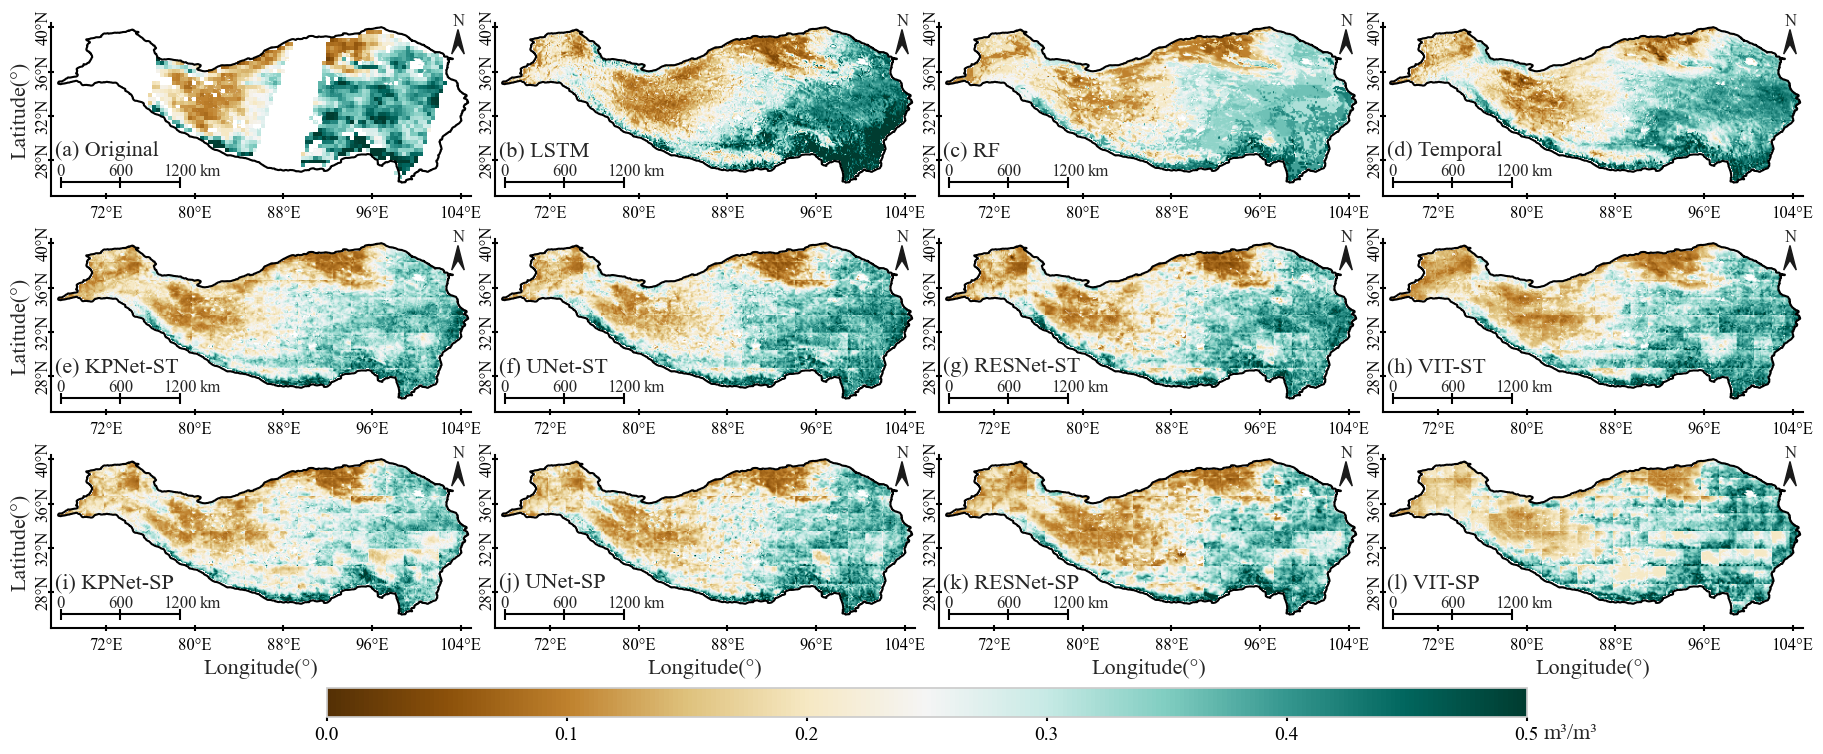

In [20]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import FuncFormatter
import geopandas as gpd
from shapely.geometry import Point
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import matplotlib.cm as mcm
from matplotlib.ticker import MaxNLocator

sns.set(style="whitegrid", font='Times New Roman')
matplotlib.rcParams['font.family'] = 'Times New Roman'
legend_font = FontProperties(family='Times New Roman', size=14)
font_prop = FontProperties(family='Times New Roman', size=16)

def add_north(ax, labelsize=12, loc_x=0.97, loc_y=0.96, width=0.03, height=0.15, pad=0.15):
    """
    画一个比例尺带'N'文字注释
    主要参数如下
    :param ax: 要画的坐标区域 Axes实例 plt.gca()获取即可
    :param labelsize: 显示'N'文字的大小
    :param loc_x: 以文字下部为中心的占整个ax横向比例
    :param loc_y: 以文字下部为中心的占整个ax纵向比例
    :param width: 指南针占ax比例宽度
    :param height: 指南针占ax比例高度
    :param pad: 文字符号占ax比例间隙
    :return: None
    """
    minx, maxx = ax.get_xlim()
    miny, maxy = ax.get_ylim()
    ylen = maxy - miny
    xlen = maxx - minx
    left = [minx + xlen*(loc_x - width*.5), miny + ylen*(loc_y - pad)]
    right = [minx + xlen*(loc_x + width*.5), miny + ylen*(loc_y - pad)]
    top = [minx + xlen*loc_x, miny + ylen*(loc_y - pad + height)]
    center = [minx + xlen*loc_x, left[1] + (top[1] - left[1])*.4]
    triangle = mpatches.Polygon([left, top, right, center], color='k')
    ax.text(s='N',
            x=minx + xlen*loc_x,
            y=miny + ylen*(loc_y - pad + height),
            fontsize=labelsize,
            horizontalalignment='center',
            verticalalignment='bottom')
    ax.add_patch(triangle)

def add_scalebar(ax,lon0,lat0,length,size=0.45,lw=1.5):
    '''
    ax: 坐标轴
    lon0: 经度
    lat0: 纬度
    length: 长度
    size: 控制粗细和距离的
    '''
    # style 3
    lw = lw
    ax.hlines(y=lat0,  xmin = lon0, xmax = lon0+length/111, colors="black", ls="-", lw=lw, label='%d km' % (length))
    ax.vlines(x = lon0, ymin = lat0-size, ymax = lat0+size, colors="black", ls="-", lw=lw)
    ax.vlines(x = lon0+length/2/111, ymin = lat0-size, ymax = lat0+size, colors="black", ls="-", lw=lw)
    ax.vlines(x = lon0+length/111, ymin = lat0-size, ymax = lat0+size, colors="black", ls="-", lw=lw)
    ax.text(lon0+length/111,lat0+size+0.12,'%d' % (length),horizontalalignment = 'center',size=12)
    ax.text(lon0+length/2/111,lat0+size+0.12,'%d' % (length/2),horizontalalignment = 'center',size=12)
    ax.text(lon0,lat0+size+0.12,'0',horizontalalignment = 'center',size=12)
    ax.text(lon0+length/111/2*2.5,lat0+size+0.12,'km',horizontalalignment = 'center',size=12)

def custom_formatter(x, pos):
    if x == 0:
        return "0"
    else:
        # 保留足够的小数位数以确保精度，但不超过e记数法所需的位数
        # 使用'.15g'确保数值在转换为科学计数法时保持精度，但不会因太多不必要的零而冗长
        str_x = "{:.15g}".format(x)
        # 分割指数和底数，如果是科学计数法的形式
        if 'e' in str_x:
            base, exponent = str_x.split('e')
            # 清除底数中尾随的零和小数点
            base = base.rstrip('0').rstrip('.')
            # 格式化指数部分，去除前导+和前导0
            exponent = exponent.replace('+', '').lstrip('0')
            if exponent:  # 如果指数部分不为空
                return f"{base}e{exponent}"
            else:  # 如果指数为0
                return base
        else:
            return str_x
        
def add_degree_E(x, pos):
    return f"{int(x)}°E"

def add_degree_N(y, pos):
    return f"{int(custom_formatter(y, pos))}°N"

def create_subplots(reconstruction_datas,shp_path,lakes_path,model_names):
    fig = plt.figure(figsize=(24, 24))

    ratio_h = 7 # 竖直比例 3
    ratio_v = 4 # 水平比例

    absolute_dis_h = 0.7/ratio_h # 中央子图绝对大小（竖直）0.7
    absolute_dis_v = 0.7/ratio_v # 中央子图绝对大小（水平）

    edge_h = 0.36 # 竖直边缘间隙
    edge_v = 0.135 # 水平边缘间隙

    mid_h = (1-edge_h*2-absolute_dis_h*3)/2 # 竖直间隙,可以通过竖直边缘间隙调节
    mid_v = (1-edge_v*2-absolute_dis_v*4)/3 # 水平间隙……

    right_offset_first = 0 # 第一层向右偏移量

    # 计算第一层图起点:上层子图  左起点、下起点、宽度比例、高度比例
    ax1 = fig.add_axes([edge_v + right_offset_first, 1 - edge_h - absolute_dis_h, absolute_dis_v, absolute_dis_h])
    ax2 = fig.add_axes([edge_v + right_offset_first + absolute_dis_v + mid_v, 1 - edge_h - absolute_dis_h, absolute_dis_v, absolute_dis_h])
    ax3 = fig.add_axes([edge_v + right_offset_first + 2*(absolute_dis_v + mid_v), 1 - edge_h - absolute_dis_h, absolute_dis_v, absolute_dis_h])
    ax4 = fig.add_axes([edge_v + right_offset_first + 3*(absolute_dis_v + mid_v), 1 - edge_h - absolute_dis_h, absolute_dis_v, absolute_dis_h])

    ax5 = fig.add_axes([edge_v + right_offset_first, 1 - edge_h - 2*absolute_dis_h - mid_h, absolute_dis_v, absolute_dis_h])
    ax6 = fig.add_axes([edge_v + right_offset_first + absolute_dis_v + mid_v, 1 - edge_h - 2*absolute_dis_h - mid_h, absolute_dis_v, absolute_dis_h])
    ax7 = fig.add_axes([edge_v + right_offset_first + 2*(absolute_dis_v + mid_v), 1 - edge_h - 2*absolute_dis_h - mid_h, absolute_dis_v, absolute_dis_h])
    ax8 = fig.add_axes([edge_v + right_offset_first + 3*(absolute_dis_v + mid_v), 1 - edge_h - 2*absolute_dis_h - mid_h, absolute_dis_v, absolute_dis_h])

    ax9 = fig.add_axes([edge_v + right_offset_first, 1 - edge_h - 3*absolute_dis_h - 2*mid_h, absolute_dis_v, absolute_dis_h])
    ax10 = fig.add_axes([edge_v + right_offset_first + absolute_dis_v + mid_v, 1 - edge_h - 3*absolute_dis_h - 2*mid_h, absolute_dis_v, absolute_dis_h])
    ax11 = fig.add_axes([edge_v + right_offset_first + 2*(absolute_dis_v + mid_v), 1 - edge_h - 3*absolute_dis_h - 2*mid_h, absolute_dis_v, absolute_dis_h])
    ax12 = fig.add_axes([edge_v + right_offset_first + 3*(absolute_dis_v + mid_v), 1 - edge_h - 3*absolute_dis_h - 2*mid_h, absolute_dis_v, absolute_dis_h])

    axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12]
    vmin, vmax = 0, 0.5
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    cmap = mcm.BrBG
    sm = mcm.ScalarMappable(norm=norm, cmap=cmap)

    for i, (key, data_path) in enumerate(reconstruction_datas.items()):
        mode = 0.37 if i == 0 else 0.1
        left_spines = True  if i in [0,4,8] else False
        right_spines = True  if i in [3,7,11] else False
        top_spines = True  if i in [0,1,2,3] else False
        bottom_spines = True  if i in [8,9,10,11] else False
        draw_subplot(axes[i], reconstruction_datas[key],mode,shp_path,lakes_path,model_names,model_name=key,vmin=vmin, vmax=vmax,cmap=cmap,top_spines=top_spines,right_spines=right_spines, bottom_spines=bottom_spines, left_spines=left_spines)

    cbar_ax = fig.add_axes([0.25, 1 - edge_h - 3*absolute_dis_h - 2*mid_h-0.023, 0.5, 0.012])
    cbar = plt.colorbar(sm, cax=cbar_ax, orientation='horizontal')#, extend='both'
    cbar.set_ticks([vmin, (vmin+vmax)/2, vmax])
    cbar.ax.xaxis.set_tick_params(labelsize=14)
    cbar.ax.xaxis.set_major_locator(MaxNLocator(nbins=5))
    cbar.ax.tick_params(axis='x', which='both', colors='black', length=3, width=1.5)
    fig.text(0.757, 0.334, 'm³/m³', fontsize=16, fontname='Times New Roman', verticalalignment='top')
    fig.savefig(r"C:\Users\Administrator\Desktop\Draw\eval_darw.jpeg", dpi=500, format='jpeg', bbox_inches='tight')
    plt.show()

def draw_subplot(ax, clipped_data, mode, shp_path,lakes_path,model_names,model_name=None,vmin=None, vmax=None,cmap=None,
                 top_spines=True, right_spines=True, bottom_spines=True, left_spines=True):
    gdf = gpd.read_file(shp_path)
    lakes = gpd.read_file(lakes_path)
    lakes = lakes.to_crs(epsg=4326)
    lakes.plot(ax=ax, edgecolor='white', facecolor='white', linewidth=0)
    gdf.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1.5)

    lat_min, lat_max, lon_min, lon_max, lat_points, lon_points= 25.550117,40.450184,66.95031,104.95048,150,381
    lat_step = (lat_max - lat_min) / (lat_points - 1)
    lon_step = (lon_max - lon_min) / (lon_points - 1)

    lon_min_adj = lon_min - lon_step / 2
    lon_max_adj = lon_max + lon_step / 2
    lat_min_adj = lat_min - lat_step / 2
    lat_max_adj = lat_max + lat_step / 2
    image = ax.imshow(clipped_data, cmap=cmap, origin='lower', vmin=vmin, vmax=vmax, extent=[lon_min_adj, lon_max_adj, lat_min_adj, lat_max_adj])

    # 设置X轴和Y轴的标签
    ax.set_xlabel('Longitude(°)',size=16)
    ax.set_ylabel('Latitude(°)',size=16)
    ax.tick_params(axis='x', which='both', colors='black', length=3, width=1.5, labelsize=14, direction='out', pad=2, bottom=True, top=True, labelbottom=True,labeltop=False)
    ax.tick_params(axis='y', which='both', colors='black', length=3, width=1.5, labelsize=14, direction='out', pad=6, left=True, right=True, labelleft=True,labelright=False)
    plt.setp(ax.get_xticklabels(), rotation=0,rotation_mode="anchor")
    plt.setp(ax.get_yticklabels(), rotation=90,ha="center", rotation_mode="anchor")

    # 刻度标签轴绘制
    labelsize = 12
    pad_x = 4
    pad_y = 4
    ax.yaxis.label.set_visible(left_spines)
    ax.xaxis.label.set_visible(bottom_spines)
    ax.xaxis.set_major_formatter(FuncFormatter(add_degree_E))

    # 刻度调节
    plt.setp(ax.get_yticklabels(), rotation=90,ha="center", rotation_mode="anchor")
    # 刻度值格式
    ax.yaxis.set_major_formatter(FuncFormatter(add_degree_N))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('black')
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_color('black')
    ax.spines['left'].set_linewidth(1.5)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=6))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=4))
    ax.tick_params(axis='y', which='both', colors='black', length=5, width=1.5, labelsize=labelsize, direction='inout', pad=pad_y, right=False, labelright=False)
    ax.tick_params(axis='x', which='both', colors='black', length=5, width=1.5, labelsize=labelsize, direction='inout', pad=pad_x, top=False, labeltop=False)
    add_north(ax)
    add_scalebar(ax,67.9,26,1200,size=0.5,lw=1.5)
    ax.grid(False)
    # 文本
    prefix = "(" + chr(ord('a') + model_names.index(model_name)) + ")" 
    model_str = f'{prefix} {model_name}'
    ax.text(0.01, 0.32, model_str, transform=ax.transAxes, fontsize=16, fontname='Times New Roman', verticalalignment='top')
model_names = list(reconstruction_paths.keys())
create_subplots(reconstruction_datas,shp_path,lakes_path,model_names)

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import FuncFormatter
import geopandas as gpd
from shapely.geometry import Point
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import matplotlib.cm as mcm
from matplotlib.ticker import MaxNLocator

sns.set(style="whitegrid", font='Times New Roman')
matplotlib.rcParams['font.family'] = 'Times New Roman'
legend_font = FontProperties(family='Times New Roman', size=14)
font_prop = FontProperties(family='Times New Roman', size=16)

def add_north(ax, labelsize=12, loc_x=0.97, loc_y=0.96, width=0.03, height=0.15, pad=0.15):
    """
    画一个比例尺带'N'文字注释
    主要参数如下
    :param ax: 要画的坐标区域 Axes实例 plt.gca()获取即可
    :param labelsize: 显示'N'文字的大小
    :param loc_x: 以文字下部为中心的占整个ax横向比例
    :param loc_y: 以文字下部为中心的占整个ax纵向比例
    :param width: 指南针占ax比例宽度
    :param height: 指南针占ax比例高度
    :param pad: 文字符号占ax比例间隙
    :return: None
    """
    minx, maxx = ax.get_xlim()
    miny, maxy = ax.get_ylim()
    ylen = maxy - miny
    xlen = maxx - minx
    left = [minx + xlen*(loc_x - width*.5), miny + ylen*(loc_y - pad)]
    right = [minx + xlen*(loc_x + width*.5), miny + ylen*(loc_y - pad)]
    top = [minx + xlen*loc_x, miny + ylen*(loc_y - pad + height)]
    center = [minx + xlen*loc_x, left[1] + (top[1] - left[1])*.4]
    triangle = mpatches.Polygon([left, top, right, center], color='k')
    ax.text(s='N',
            x=minx + xlen*loc_x,
            y=miny + ylen*(loc_y - pad + height),
            fontsize=labelsize,
            horizontalalignment='center',
            verticalalignment='bottom')
    ax.add_patch(triangle)

def add_scalebar(ax,lon0,lat0,length,size=0.45,lw=1.5):
    '''
    ax: 坐标轴
    lon0: 经度
    lat0: 纬度
    length: 长度
    size: 控制粗细和距离的
    '''
    # style 3
    lw = lw
    ax.hlines(y=lat0,  xmin = lon0, xmax = lon0+length/111, colors="black", ls="-", lw=lw, label='%d km' % (length))
    ax.vlines(x = lon0, ymin = lat0-size, ymax = lat0+size, colors="black", ls="-", lw=lw)
    ax.vlines(x = lon0+length/2/111, ymin = lat0-size, ymax = lat0+size, colors="black", ls="-", lw=lw)
    ax.vlines(x = lon0+length/111, ymin = lat0-size, ymax = lat0+size, colors="black", ls="-", lw=lw)
    ax.text(lon0+length/111,lat0+size+0.12,'%d' % (length),horizontalalignment = 'center',size=12)
    ax.text(lon0+length/2/111,lat0+size+0.12,'%d' % (length/2),horizontalalignment = 'center',size=12)
    ax.text(lon0,lat0+size+0.12,'0',horizontalalignment = 'center',size=12)
    ax.text(lon0+length/111/2*2.5,lat0+size+0.12,'km',horizontalalignment = 'center',size=12)

def custom_formatter(x, pos):
    if x == 0:
        return "0"
    else:
        # 保留足够的小数位数以确保精度，但不超过e记数法所需的位数
        # 使用'.15g'确保数值在转换为科学计数法时保持精度，但不会因太多不必要的零而冗长
        str_x = "{:.15g}".format(x)
        # 分割指数和底数，如果是科学计数法的形式
        if 'e' in str_x:
            base, exponent = str_x.split('e')
            # 清除底数中尾随的零和小数点
            base = base.rstrip('0').rstrip('.')
            # 格式化指数部分，去除前导+和前导0
            exponent = exponent.replace('+', '').lstrip('0')
            if exponent:  # 如果指数部分不为空
                return f"{base}e{exponent}"
            else:  # 如果指数为0
                return base
        else:
            return str_x
        
def add_degree_E(x, pos):
    return f"{int(x)}°E"

def add_degree_N(y, pos):
    return f"{int(custom_formatter(y, pos))}°N"

def create_subplots(reconstruction_datas,shp_path,lakes_path,model_names):
    fig = plt.figure(figsize=(24, 24))

    ratio_h = 7 # 竖直比例 3
    ratio_v = 4 # 水平比例

    absolute_dis_h = 0.7/ratio_h # 中央子图绝对大小（竖直）0.7
    absolute_dis_v = 0.7/ratio_v # 中央子图绝对大小（水平）

    edge_h = 0.36 # 竖直边缘间隙
    edge_v = 0.135 # 水平边缘间隙

    mid_h = (1-edge_h*2-absolute_dis_h*3)/2 # 竖直间隙,可以通过竖直边缘间隙调节
    mid_v = (1-edge_v*2-absolute_dis_v*4)/3 # 水平间隙……

    right_offset_first = 0 # 第一层向右偏移量

    # 计算第一层图起点:上层子图  左起点、下起点、宽度比例、高度比例    7*4
    ax1 = fig.add_axes([edge_v + right_offset_first, 1 - edge_h - absolute_dis_h, absolute_dis_v, absolute_dis_h])
    ax2 = fig.add_axes([edge_v + right_offset_first + absolute_dis_v + mid_v, 1 - edge_h - absolute_dis_h, absolute_dis_v, absolute_dis_h])
    ax3 = fig.add_axes([edge_v + right_offset_first + 2*(absolute_dis_v + mid_v), 1 - edge_h - absolute_dis_h, absolute_dis_v, absolute_dis_h])
    ax4 = fig.add_axes([edge_v + right_offset_first + 3*(absolute_dis_v + mid_v), 1 - edge_h - absolute_dis_h, absolute_dis_v, absolute_dis_h])

    ax5 = fig.add_axes([edge_v + right_offset_first, 1 - edge_h - 2*absolute_dis_h - mid_h, absolute_dis_v, absolute_dis_h])
    ax6 = fig.add_axes([edge_v + right_offset_first + absolute_dis_v + mid_v, 1 - edge_h - 2*absolute_dis_h - mid_h, absolute_dis_v, absolute_dis_h])
    ax7 = fig.add_axes([edge_v + right_offset_first + 2*(absolute_dis_v + mid_v), 1 - edge_h - 2*absolute_dis_h - mid_h, absolute_dis_v, absolute_dis_h])
    ax8 = fig.add_axes([edge_v + right_offset_first + 3*(absolute_dis_v + mid_v), 1 - edge_h - 2*absolute_dis_h - mid_h, absolute_dis_v, absolute_dis_h])

    ax9 = fig.add_axes([edge_v + right_offset_first, 1 - edge_h - 3*absolute_dis_h - 2*mid_h, absolute_dis_v, absolute_dis_h])
    ax10 = fig.add_axes([edge_v + right_offset_first + absolute_dis_v + mid_v, 1 - edge_h - 3*absolute_dis_h - 2*mid_h, absolute_dis_v, absolute_dis_h])
    ax11 = fig.add_axes([edge_v + right_offset_first + 2*(absolute_dis_v + mid_v), 1 - edge_h - 3*absolute_dis_h - 2*mid_h, absolute_dis_v, absolute_dis_h])
    ax12 = fig.add_axes([edge_v + right_offset_first + 3*(absolute_dis_v + mid_v), 1 - edge_h - 3*absolute_dis_h - 2*mid_h, absolute_dis_v, absolute_dis_h])

    axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12]
    vmin, vmax = 0, 0.5
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    cmap = mcm.BrBG
    sm = mcm.ScalarMappable(norm=norm, cmap=cmap)

    for i, (key, data_path) in enumerate(reconstruction_datas.items()):
        mode = 0.37 if i == 0 else 0.1
        left_spines = True  if i in [0,4,8] else False
        right_spines = True  if i in [3,7,11] else False
        top_spines = True  if i in [0,1,2,3] else False
        bottom_spines = True  if i in [8,9,10,11] else False
        draw_subplot(axes[i], reconstruction_datas[key],mode,shp_path,lakes_path,model_names,model_name=key,vmin=vmin, vmax=vmax,cmap=cmap,top_spines=top_spines,right_spines=right_spines, bottom_spines=bottom_spines, left_spines=left_spines)
    fig.savefig(r"C:\Users\Administrator\Desktop\Draw\eval_darw.jpeg", dpi=500, format='jpeg', bbox_inches='tight')

    cbar_ax = fig.add_axes([0.25, 1 - edge_h - 3*absolute_dis_h - 2*mid_h-0.023, 0.5, 0.012])
    cbar = plt.colorbar(sm, cax=cbar_ax, orientation='horizontal')#, extend='both'
    cbar.set_ticks([vmin, (vmin+vmax)/2, vmax])
    cbar.ax.xaxis.set_tick_params(labelsize=14)
    cbar.ax.xaxis.set_major_locator(MaxNLocator(nbins=5))
    cbar.ax.tick_params(axis='x', which='both', colors='black', length=3, width=1.5)
    cbar.ax.text(0.01, 0.32, 'm³/m³', fontsize=16, fontname='Times New Roman', verticalalignment='top')
    plt.show()

In [8]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
def apply_clipping(data, lon_grid, lat_grid, shp_path):
    """
    使用.shp文件裁剪数据：在边界外的数据设置为NaN。
    """
    gdf = gpd.read_file(shp_path)
    poly = gdf.unary_union
    
    clipped_data = np.full(data.shape, np.nan)
    
    for i in range(data.shape[1]):
        for j in range(data.shape[2]):
            point = Point(lon_grid[i, j], lat_grid[i, j])
            if point.within(poly):
                clipped_data[:, i, j] = data[:, i, j]
                
    return clipped_data
def generate_grid(lat_min, lat_max, lon_min, lon_max, lat_points, lon_points):
    """
    根据最小/最大经纬度和点数生成经纬度网格。
    网格点代表像素的中心。
    """
    lat_spacing = (lat_max - lat_min) / (lat_points - 1)
    lon_spacing = (lon_max - lon_min) / (lon_points - 1)
    
    lat_grid = np.linspace(lat_min + lat_spacing / 2, lat_max - lat_spacing / 2, lat_points)
    lon_grid = np.linspace(lon_min + lon_spacing / 2, lon_max - lon_spacing / 2, lon_points)
    
    lon_grid, lat_grid = np.meshgrid(lon_grid, lat_grid)
    
    return lat_grid, lon_grid

mode = 0.1
if mode == 0.1:
    lat_min, lat_max, lon_min, lon_max, lat_points, lon_points = 25.550117, 40.450184, 66.95031, 104.95048, 150, 381
else:
    lat_min, lat_max, lon_min, lon_max, lat_points, lon_points = 25.293533, 40.604774, 66.84705, 105.31184, 42, 104

lat_grid, lon_grid = generate_grid(lat_min, lat_max, lon_min, lon_max, lat_points, lon_points)

data_path = r"D:\Data_Store\Dataset\Reconstruction\ST\RES168\ST_kpnet_Encoder_lite_serial_temporal_usage_position_embedding_individual_init256_11_121_131_dropout_rate0.3168.npy"
#data_path = r"D:\Data_Store\Dataset\Reconstruction\ST\RES1616\ST_kpnet_Encoder_lite_serial_temporal_usage_position_embedding_individual_init256_11_121_131_dropout_rate0.316.npy"
data = np.load(data_path)
start_time = pd.Timestamp('2016-01-01 03:00')
time_delta = pd.to_timedelta(np.arange(data.shape[0]) * 3, unit='h')
time_series = start_time + time_delta
indices = [i for i, t in enumerate(time_series) if t.hour in [6, 18]]
selected_data = data[indices]
selected_time_series = time_series[indices]
shp_path = "D:\\Data_Store\\TPBoundary_new(2021)\\TPBoundary_new(2021).shp"  # 指定.shp文件的路径
clipped_data = apply_clipping(selected_data, lon_grid, lat_grid, shp_path)
valid_ratio = np.nanmean(~np.isnan(clipped_data), axis=(1, 2))
time_ratio_pairs = sorted(zip(selected_time_series, valid_ratio), key=lambda x: x[1], reverse=True)

sorted_dict = {time.strftime('%Y-%m-%d-%H'): ratio for time, ratio in time_ratio_pairs}
sorted_dict

{'2016-01-01-06': 0.5297112860892389,
 '2016-01-01-18': 0.5297112860892389,
 '2016-01-02-06': 0.5297112860892389,
 '2016-01-02-18': 0.5297112860892389,
 '2016-01-03-06': 0.5297112860892389,
 '2016-01-03-18': 0.5297112860892389,
 '2016-01-04-06': 0.5297112860892389,
 '2016-01-04-18': 0.5297112860892389,
 '2016-01-05-06': 0.5297112860892389,
 '2016-01-05-18': 0.5297112860892389,
 '2016-01-06-06': 0.5297112860892389,
 '2016-01-06-18': 0.5297112860892389,
 '2016-01-07-06': 0.5297112860892389,
 '2016-01-07-18': 0.5297112860892389,
 '2016-01-08-06': 0.5297112860892389,
 '2016-01-08-18': 0.5297112860892389,
 '2016-01-09-06': 0.5297112860892389,
 '2016-01-09-18': 0.5297112860892389,
 '2016-01-10-06': 0.5297112860892389,
 '2016-01-10-18': 0.5297112860892389,
 '2016-01-11-06': 0.5297112860892389,
 '2016-01-11-18': 0.5297112860892389,
 '2016-01-12-06': 0.5297112860892389,
 '2016-01-12-18': 0.5297112860892389,
 '2016-01-13-06': 0.5297112860892389,
 '2016-01-13-18': 0.5297112860892389,
 '2016-01-14

In [20]:
import pandas as pd

# 创建时间序列
start = '2016-01-01 03:00'
end = '2019-08-27 06:00'
freq = '3H'  # 每3小时一个时间点

# 生成时间序列
time_series = pd.date_range(start=start, end=end, freq=freq)

# 找到特定时间点的索引
specific_time = '2018-09-04 06:00'
specific_index = time_series.get_loc(specific_time)

print("The index of 2018-08-27 06:00 is:", specific_index)

The index of 2018-08-27 06:00 is: 7817


C:\Users\Administrator\AppData\Local\Temp\ipykernel_28128\3134969574.py:5: RuntimeWarning: Mean of empty slice
  mean_values_over_time = np.nanmean(clipped_data, axis=0)


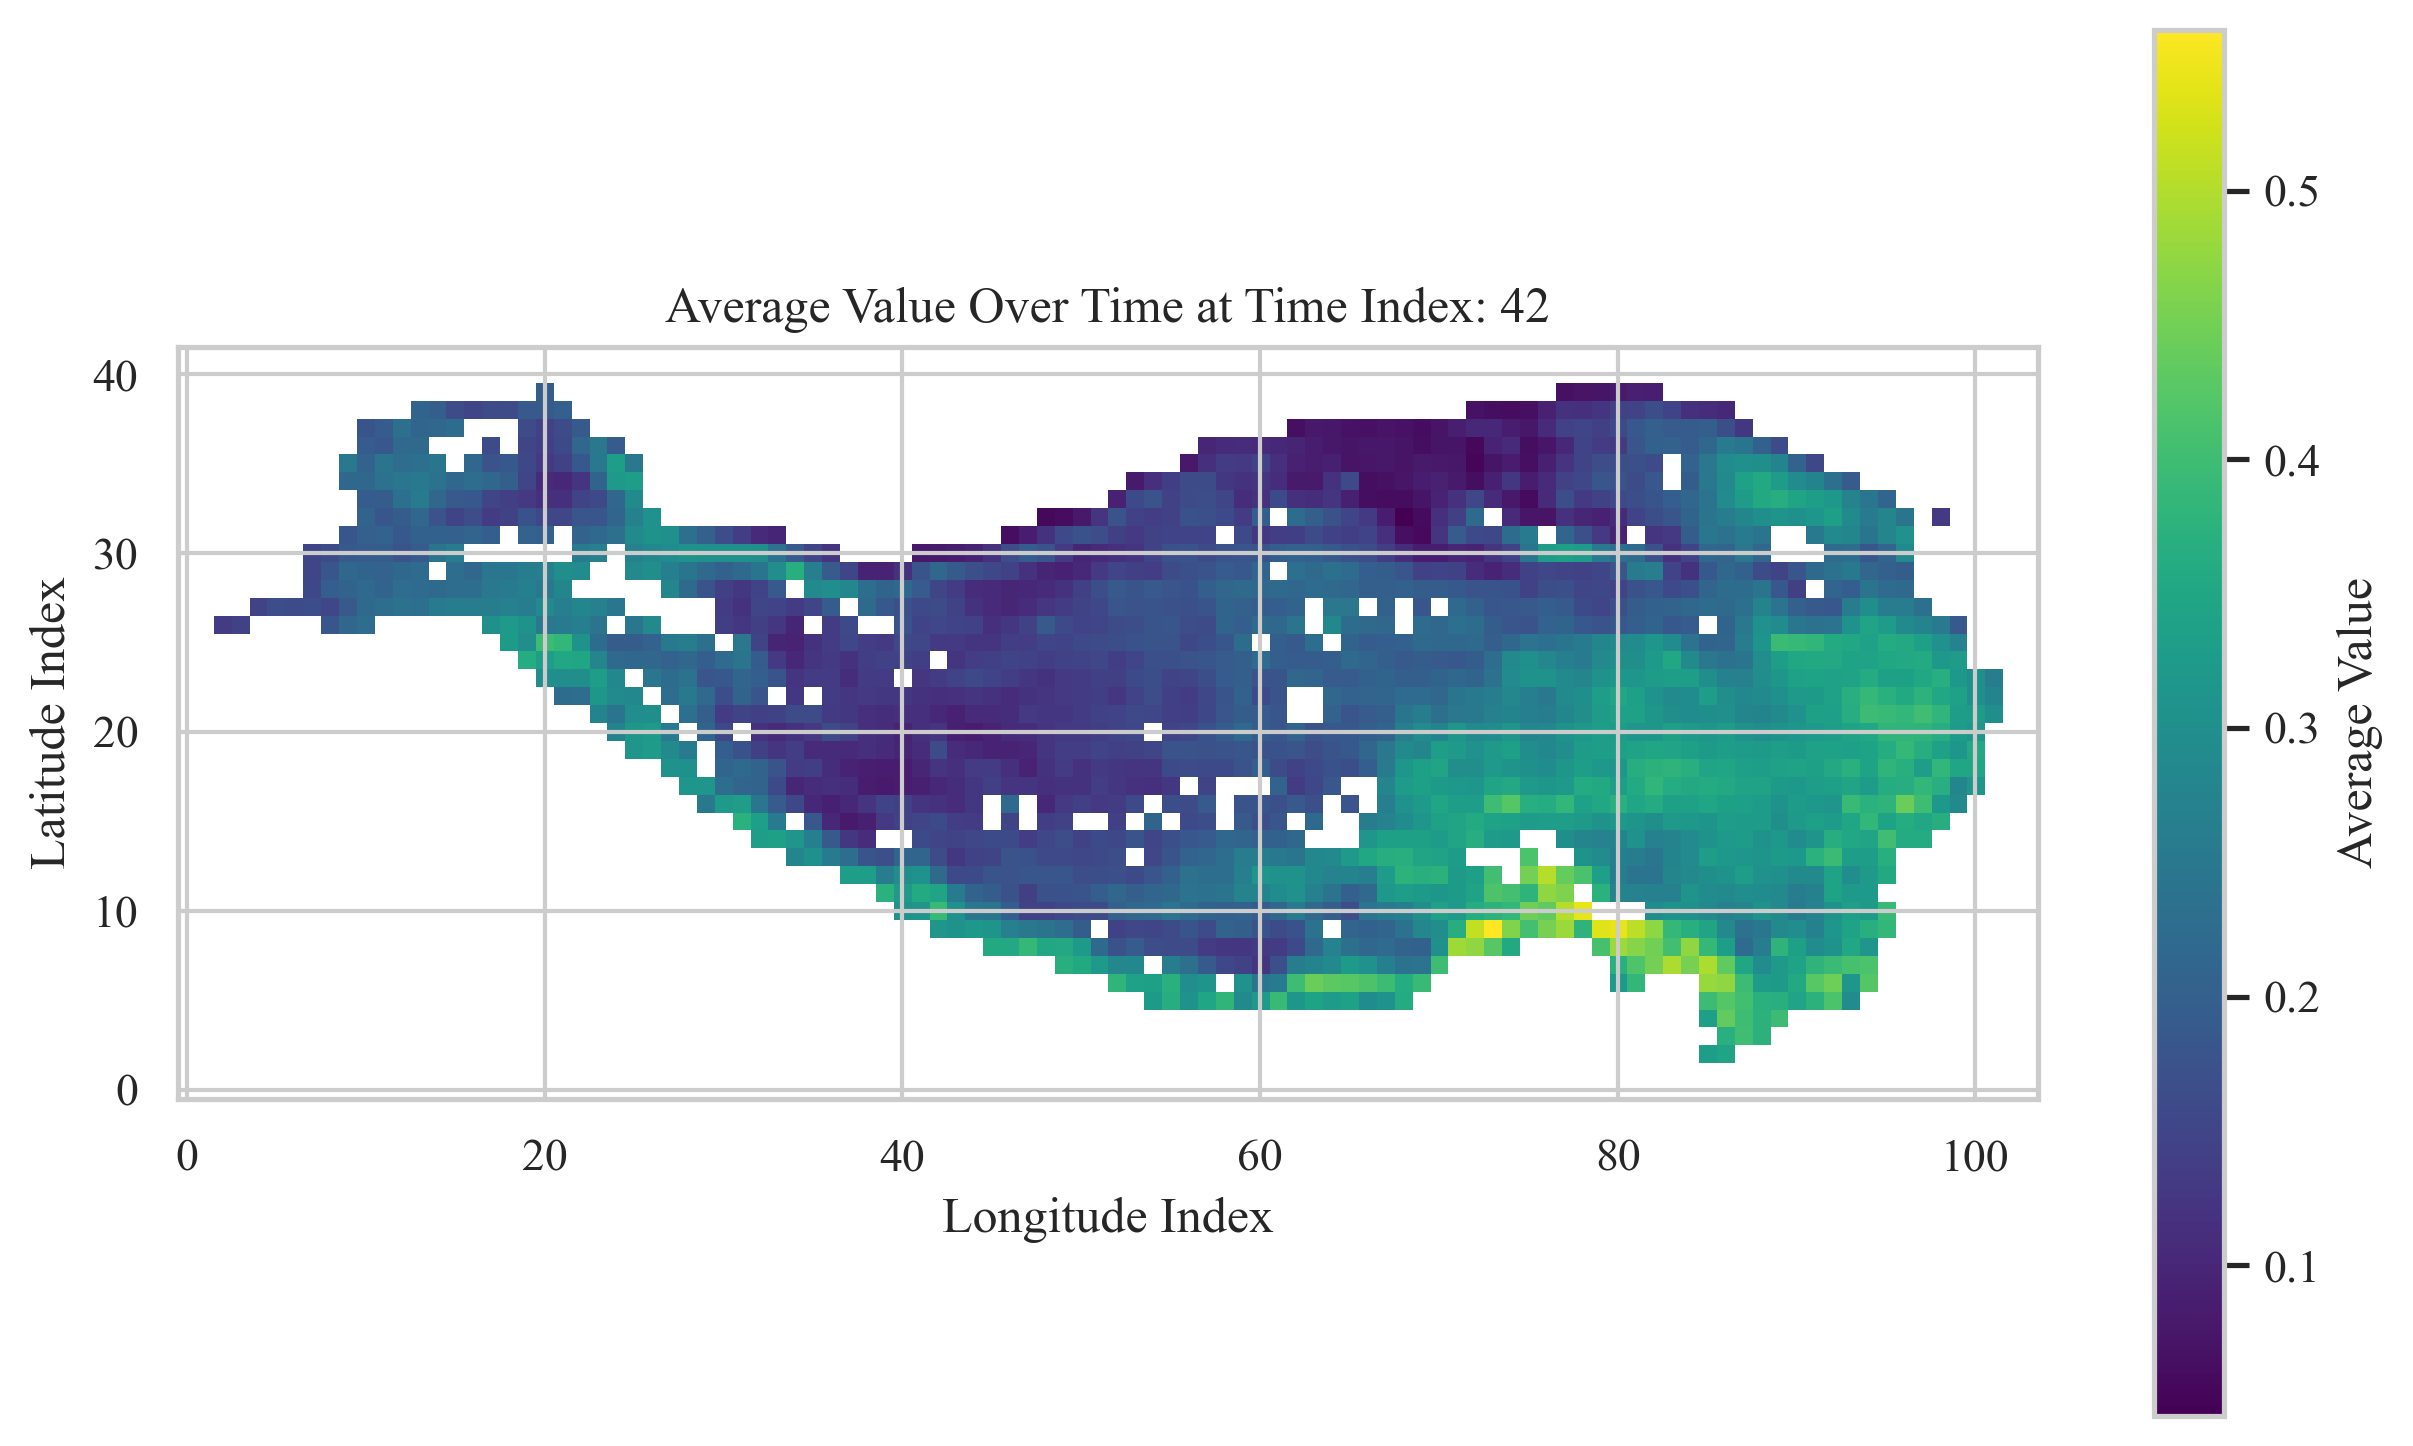

In [14]:
# 获取有效值的布尔索引
valid_indices = ~np.isnan(clipped_data)

# 在时间维度上计算有数据点的均值
mean_values_over_time = np.nanmean(clipped_data, axis=0)
# 绘制特定时间点的平均值图
time_index = 42  # 示例时间点索引
plt.figure(figsize=(10, 6), dpi=300)
plt.imshow(mean_values_over_time, cmap='viridis', origin='lower')
plt.colorbar(label='Average Value')
plt.title(f'Average Value Over Time at Time Index: {time_index}')
plt.xlabel('Longitude Index')
plt.ylabel('Latitude Index')
plt.show()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_28128\2200520948.py:26: RuntimeWarning: Mean of empty slice
  monthly_mean = np.nanmean(monthly_data, axis=0)


AttributeError: module 'matplotlib.pyplot' has no attribute 'set_xlabel'

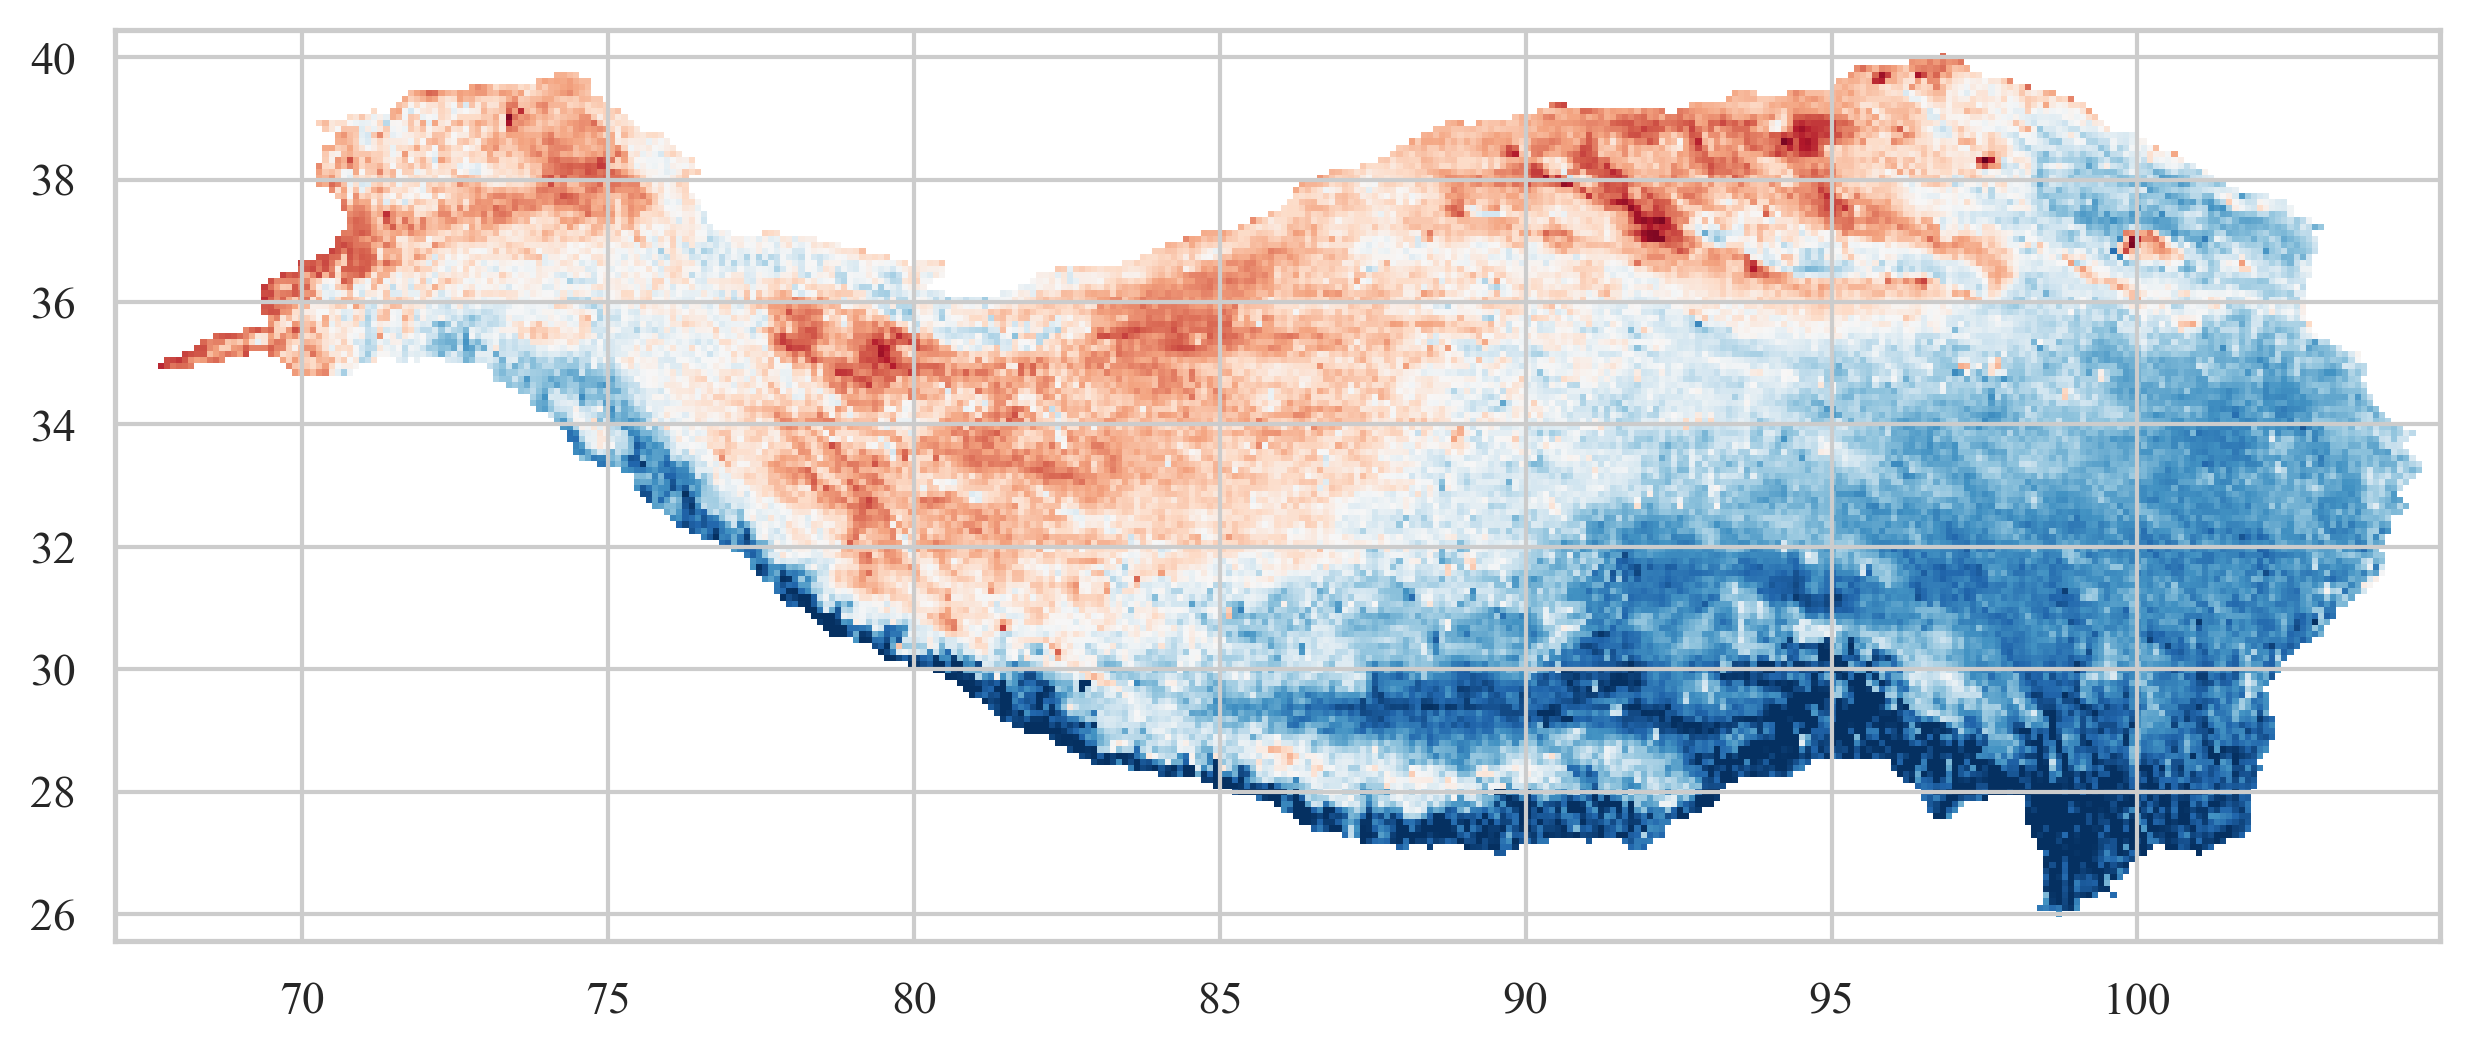

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
def calculate_monthly_mean_and_plot(data, year, month, start_date='2016-01-01 06:00', freq='12H'):
    """
    计算指定年月的数据均值并绘图，考虑时间起点是2016-1-1 6:00，频率为12小时。
    """
    # 生成时间序列
    start = pd.Timestamp(start_date)
    periods = data.shape[0]
    time_series = pd.date_range(start=start, periods=periods, freq=freq)
    
    # 筛选指定年月的时间序列
    specific_month_series = time_series[(time_series.year == year) & (time_series.month == month)]
    
    # 确保筛选结果不为空
    if not specific_month_series.empty:
        # 获取指定年月的起始和结束索引
        start_idx = time_series.get_loc(specific_month_series[0])
        end_idx = time_series.get_loc(specific_month_series[-1])
        
        # 提取该月内的数据
        monthly_data = data[start_idx:end_idx+1]
        
        # 计算时间维度上的均值
        monthly_mean = np.nanmean(monthly_data, axis=0)
        
        # 绘制均值数据
        plt.figure(figsize=(10, 6), dpi=300)
        image = plt.imshow(monthly_mean, cmap='RdBu', origin='lower', vmin=0, vmax=0.5, extent=[lon_min, lon_max, lat_min, lat_max])
        # 设置X轴和Y轴的标签
        plt.set_xlabel('Longitude(°)',size=18)
        plt.set_ylabel('Latitude(°)',size=18)
        plt.xaxis.set_major_formatter(FuncFormatter(add_degree_E))
        plt.yaxis.set_major_formatter(FuncFormatter(add_degree_N))
        plt.tick_params(axis='x', which='both', colors='black', length=3, width=1.5, labelsize=14, direction='out', pad=2, bottom=True, top=True, labelbottom=True,labeltop=False)
        plt.tick_params(axis='y', which='both', colors='black', length=3, width=1.5, labelsize=14, direction='out', pad=6, left=True, right=True, labelleft=True,labelright=False)

    else:
        print(f"No data found for {year}-{month}.")
# 示例使用
# 假设 clipped_data 是经过裁剪处理的数据数组
calculate_monthly_mean_and_plot(clipped_data, 2018, 8)


C:\Users\Administrator\AppData\Local\Temp\ipykernel_28128\2200520948.py:26: RuntimeWarning: Mean of empty slice
  monthly_mean = np.nanmean(monthly_data, axis=0)


AttributeError: module 'matplotlib.pyplot' has no attribute 'set_xlabel'

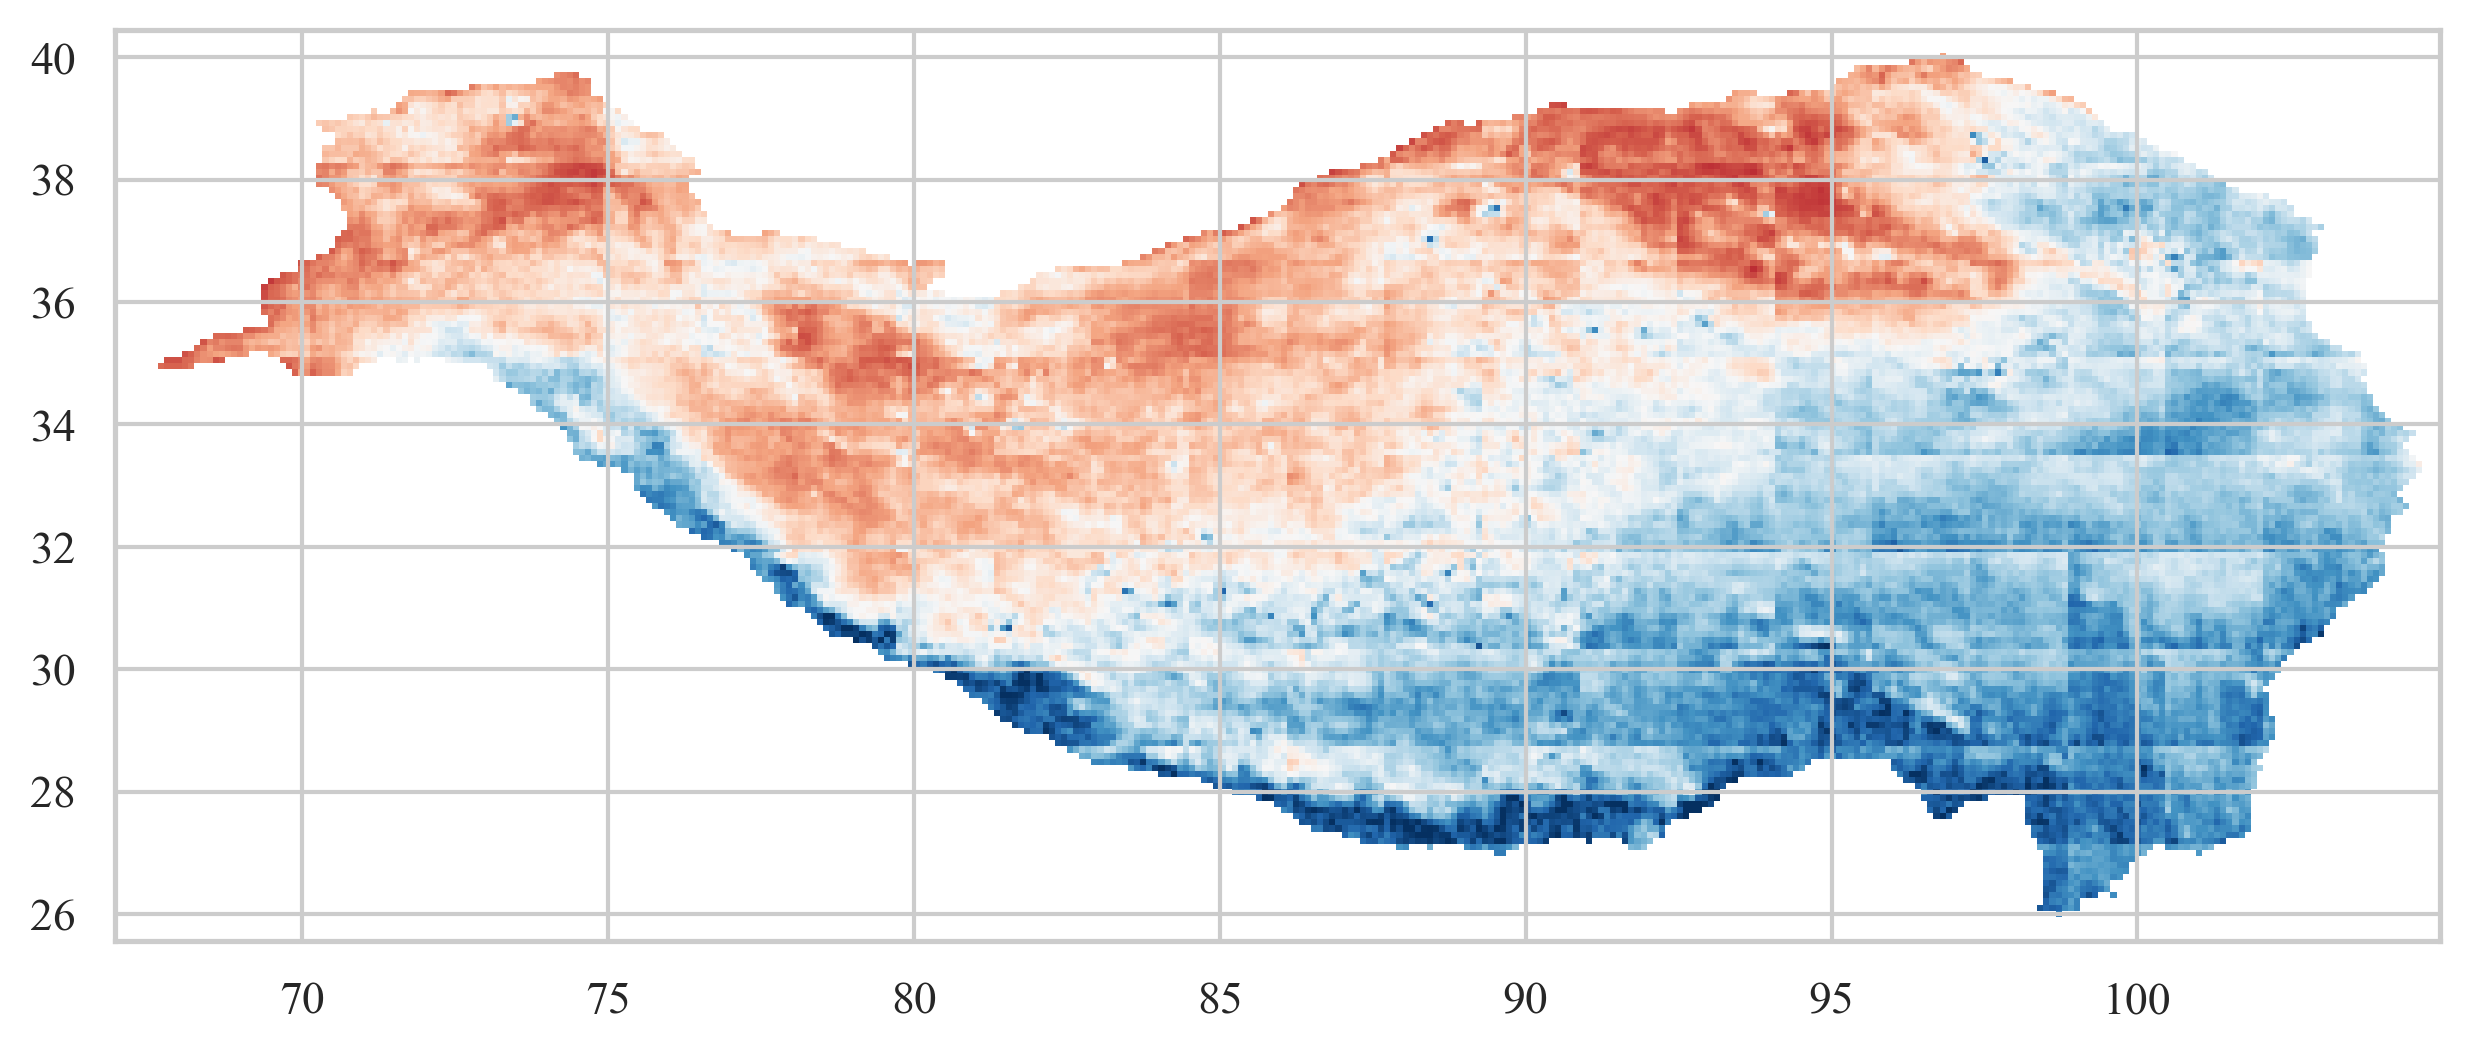

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
def calculate_monthly_mean_and_plot(data, year, month, start_date='2016-01-01 06:00', freq='12H'):
    """
    计算指定年月的数据均值并绘图，考虑时间起点是2016-1-1 6:00，频率为12小时。
    """
    # 生成时间序列
    start = pd.Timestamp(start_date)
    periods = data.shape[0]
    time_series = pd.date_range(start=start, periods=periods, freq=freq)
    
    # 筛选指定年月的时间序列
    specific_month_series = time_series[(time_series.year == year) & (time_series.month == month)]
    
    # 确保筛选结果不为空
    if not specific_month_series.empty:
        # 获取指定年月的起始和结束索引
        start_idx = time_series.get_loc(specific_month_series[0])
        end_idx = time_series.get_loc(specific_month_series[-1])
        
        # 提取该月内的数据
        monthly_data = data[start_idx:end_idx+1]
        
        # 计算时间维度上的均值
        monthly_mean = np.nanmean(monthly_data, axis=0)
        
        # 绘制均值数据
        plt.figure(figsize=(10, 6), dpi=300)
        image = plt.imshow(monthly_mean, cmap='RdBu', origin='lower', vmin=0, vmax=0.5, extent=[lon_min, lon_max, lat_min, lat_max])
        # 设置X轴和Y轴的标签
        plt.set_xlabel('Longitude(°)',size=18)
        plt.set_ylabel('Latitude(°)',size=18)
        plt.xaxis.set_major_formatter(FuncFormatter(add_degree_E))
        plt.yaxis.set_major_formatter(FuncFormatter(add_degree_N))
        plt.tick_params(axis='x', which='both', colors='black', length=3, width=1.5, labelsize=14, direction='out', pad=2, bottom=True, top=True, labelbottom=True,labeltop=False)
        plt.tick_params(axis='y', which='both', colors='black', length=3, width=1.5, labelsize=14, direction='out', pad=6, left=True, right=True, labelleft=True,labelright=False)

    else:
        print(f"No data found for {year}-{month}.")
# 示例使用
# 假设 clipped_data 是经过裁剪处理的数据数组
calculate_monthly_mean_and_plot(clipped_data, 2018, 8)


C:\Users\Administrator\AppData\Local\Temp\ipykernel_28128\2200520948.py:26: RuntimeWarning: Mean of empty slice
  monthly_mean = np.nanmean(monthly_data, axis=0)


AttributeError: module 'matplotlib.pyplot' has no attribute 'set_xlabel'

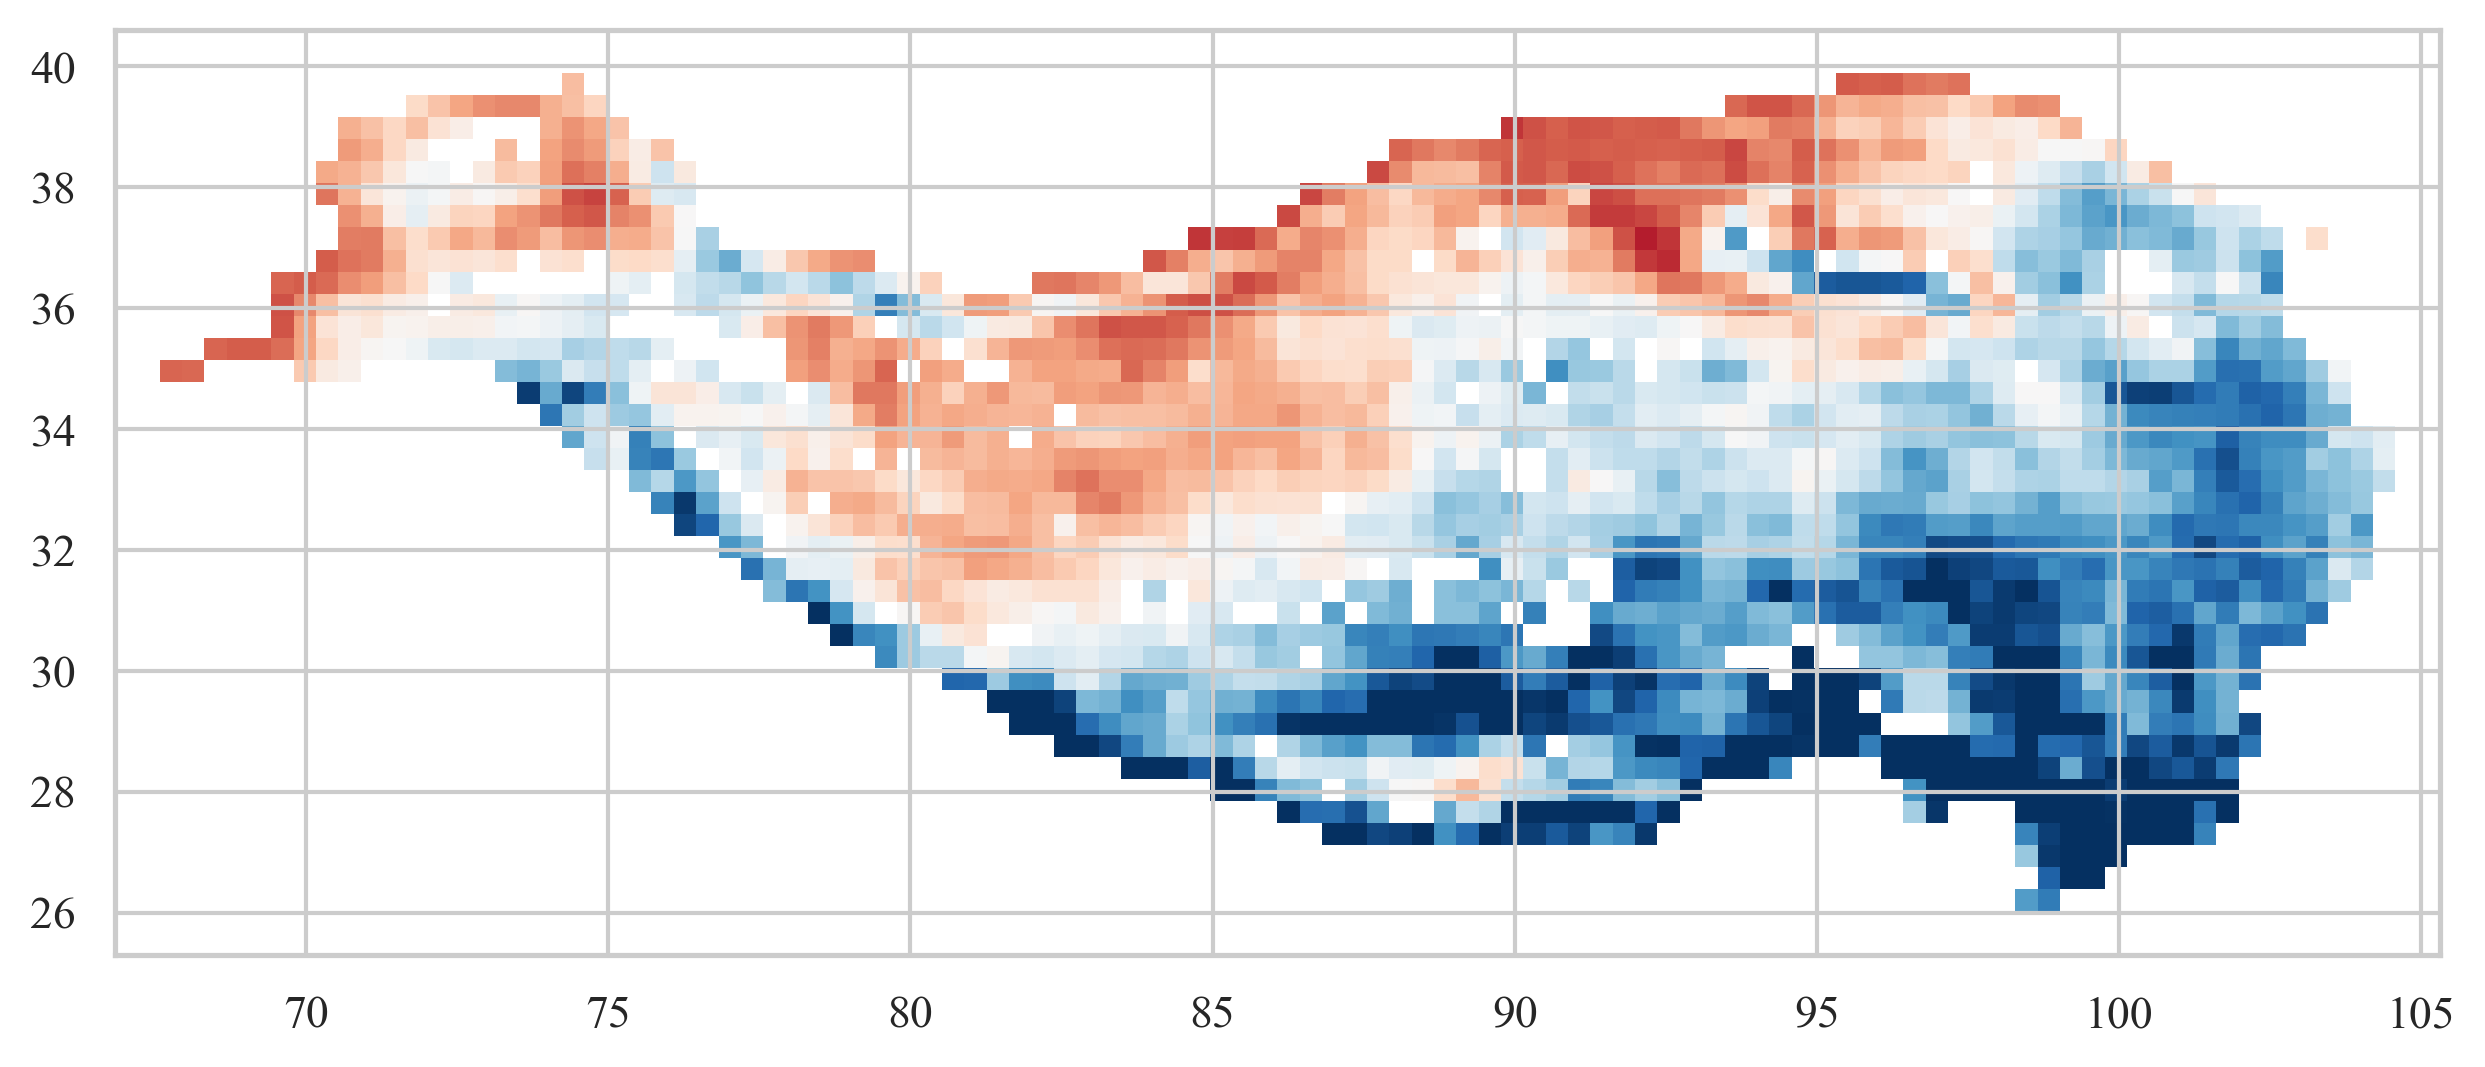

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
def calculate_monthly_mean_and_plot(data, year, month, start_date='2016-01-01 06:00', freq='12H'):
    """
    计算指定年月的数据均值并绘图，考虑时间起点是2016-1-1 6:00，频率为12小时。
    """
    # 生成时间序列
    start = pd.Timestamp(start_date)
    periods = data.shape[0]
    time_series = pd.date_range(start=start, periods=periods, freq=freq)
    
    # 筛选指定年月的时间序列
    specific_month_series = time_series[(time_series.year == year) & (time_series.month == month)]
    
    # 确保筛选结果不为空
    if not specific_month_series.empty:
        # 获取指定年月的起始和结束索引
        start_idx = time_series.get_loc(specific_month_series[0])
        end_idx = time_series.get_loc(specific_month_series[-1])
        
        # 提取该月内的数据
        monthly_data = data[start_idx:end_idx+1]
        
        # 计算时间维度上的均值
        monthly_mean = np.nanmean(monthly_data, axis=0)
        
        # 绘制均值数据
        plt.figure(figsize=(10, 6), dpi=300)
        image = plt.imshow(monthly_mean, cmap='RdBu', origin='lower', vmin=0, vmax=0.5, extent=[lon_min, lon_max, lat_min, lat_max])
        # 设置X轴和Y轴的标签
        plt.set_xlabel('Longitude(°)',size=18)
        plt.set_ylabel('Latitude(°)',size=18)
        plt.xaxis.set_major_formatter(FuncFormatter(add_degree_E))
        plt.yaxis.set_major_formatter(FuncFormatter(add_degree_N))
        plt.tick_params(axis='x', which='both', colors='black', length=3, width=1.5, labelsize=14, direction='out', pad=2, bottom=True, top=True, labelbottom=True,labeltop=False)
        plt.tick_params(axis='y', which='both', colors='black', length=3, width=1.5, labelsize=14, direction='out', pad=6, left=True, right=True, labelleft=True,labelright=False)

    else:
        print(f"No data found for {year}-{month}.")
# 示例使用
# 假设 clipped_data 是经过裁剪处理的数据数组
calculate_monthly_mean_and_plot(clipped_data, 2018, 8)


C:\Users\Administrator\AppData\Local\Temp\ipykernel_28128\2200520948.py:26: RuntimeWarning: Mean of empty slice
  monthly_mean = np.nanmean(monthly_data, axis=0)


AttributeError: module 'matplotlib.pyplot' has no attribute 'set_xlabel'

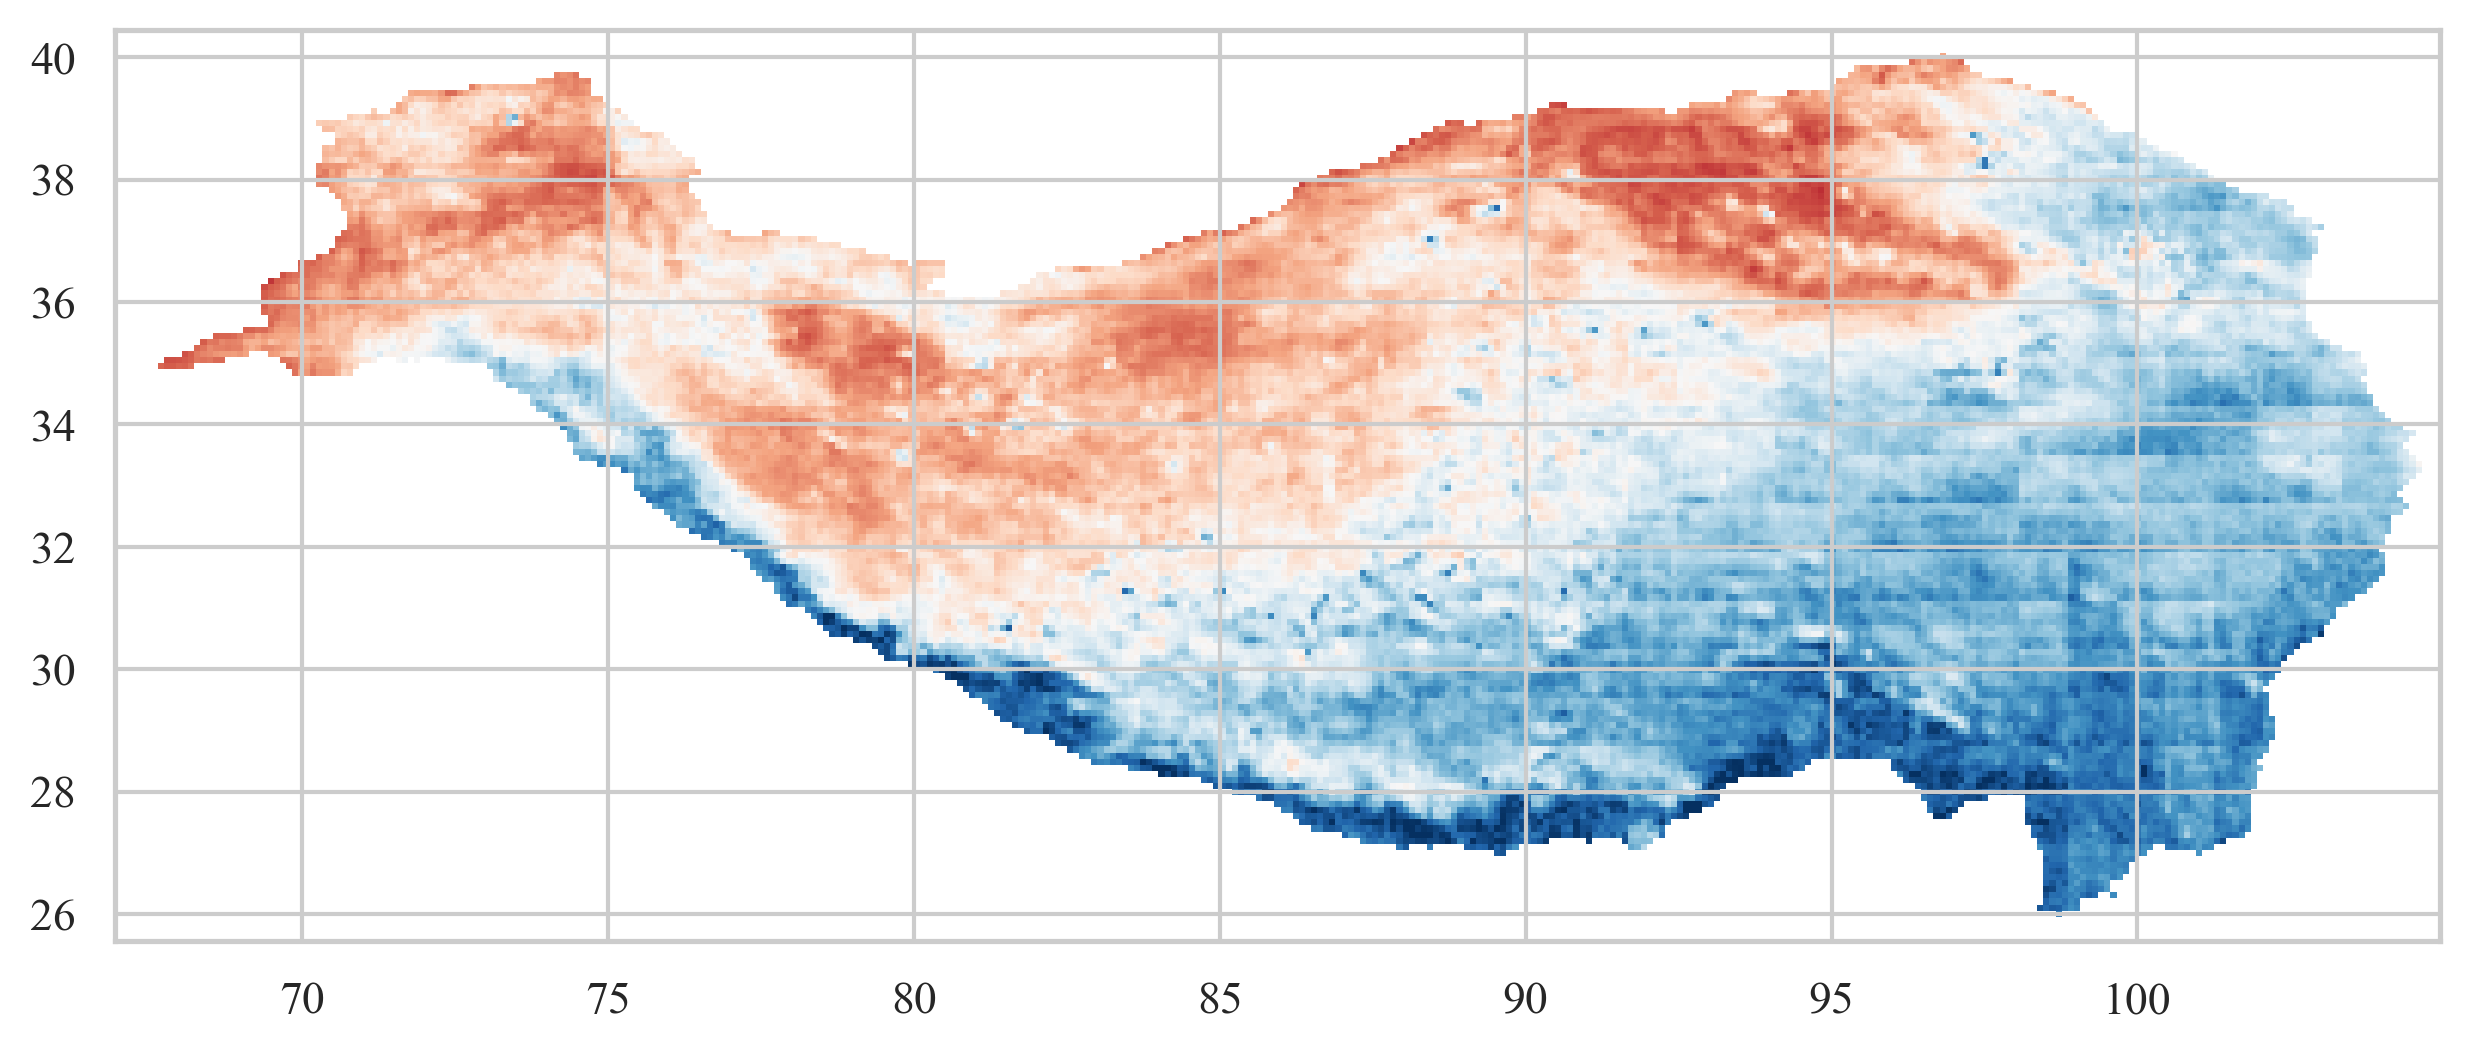

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
def calculate_monthly_mean_and_plot(data, year, month, start_date='2016-01-01 06:00', freq='12H'):
    """
    计算指定年月的数据均值并绘图，考虑时间起点是2016-1-1 6:00，频率为12小时。
    """
    # 生成时间序列
    start = pd.Timestamp(start_date)
    periods = data.shape[0]
    time_series = pd.date_range(start=start, periods=periods, freq=freq)
    
    # 筛选指定年月的时间序列
    specific_month_series = time_series[(time_series.year == year) & (time_series.month == month)]
    
    # 确保筛选结果不为空
    if not specific_month_series.empty:
        # 获取指定年月的起始和结束索引
        start_idx = time_series.get_loc(specific_month_series[0])
        end_idx = time_series.get_loc(specific_month_series[-1])
        
        # 提取该月内的数据
        monthly_data = data[start_idx:end_idx+1]
        
        # 计算时间维度上的均值
        monthly_mean = np.nanmean(monthly_data, axis=0)
        
        # 绘制均值数据
        plt.figure(figsize=(10, 6), dpi=300)
        image = plt.imshow(monthly_mean, cmap='RdBu', origin='lower', vmin=0, vmax=0.5, extent=[lon_min, lon_max, lat_min, lat_max])
        # 设置X轴和Y轴的标签
        plt.set_xlabel('Longitude(°)',size=18)
        plt.set_ylabel('Latitude(°)',size=18)
        plt.xaxis.set_major_formatter(FuncFormatter(add_degree_E))
        plt.yaxis.set_major_formatter(FuncFormatter(add_degree_N))
        plt.tick_params(axis='x', which='both', colors='black', length=3, width=1.5, labelsize=14, direction='out', pad=2, bottom=True, top=True, labelbottom=True,labeltop=False)
        plt.tick_params(axis='y', which='both', colors='black', length=3, width=1.5, labelsize=14, direction='out', pad=6, left=True, right=True, labelleft=True,labelright=False)

    else:
        print(f"No data found for {year}-{month}.")
# 示例使用
# 假设 clipped_data 是经过裁剪处理的数据数组
calculate_monthly_mean_and_plot(clipped_data, 2018, 8)


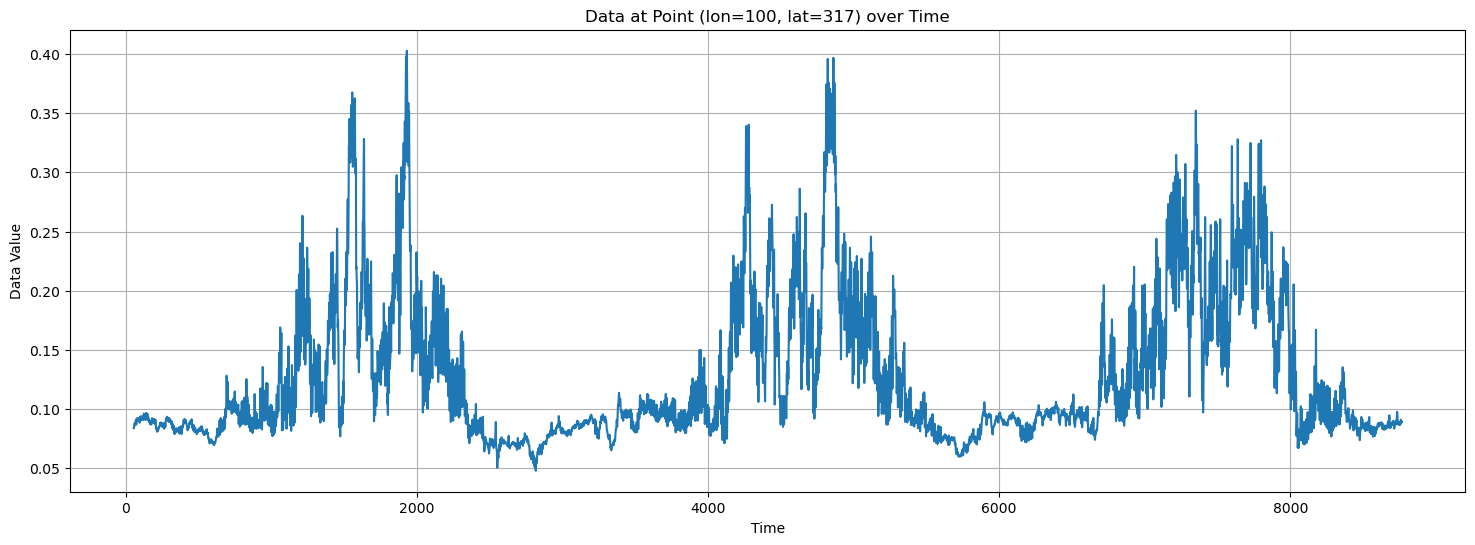

In [3]:
import matplotlib.pyplot as plt
import numpy as np
# 确保你已经有了 reconstructed_data，它的形状是 (time, lon, lat)
# ...
# Load data
reconstructed_data = np.load(r"D:\Data_Store\Dataset\Reconstruction\LSTM\LSTM1.npy")
# 选择一个点 (lon_idx, lat_idx)
lon_idx = 100  # 例如选择经度索引为 0 的位置
lat_idx = 317  # 例如选择纬度索引为 0 的位置

# 提取该点在所有时间点上的数据
point_data = reconstructed_data[:, lon_idx, lat_idx]

# 绘制图像
plt.figure(figsize=(18, 6))
plt.plot(point_data)
plt.title(f'Data at Point (lon={lon_idx}, lat={lat_idx}) over Time')
plt.xlabel('Time')
plt.ylabel('Data Value')
plt.grid(True)
plt.show()

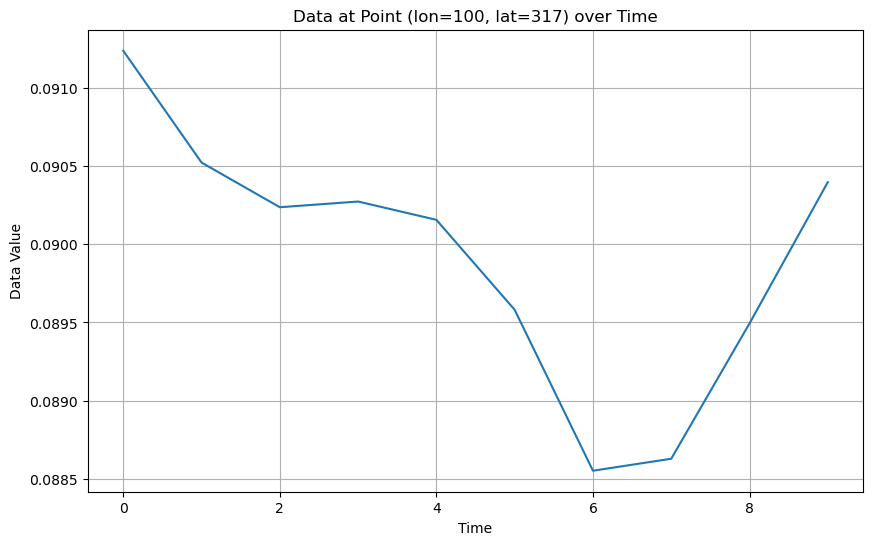

In [2]:
# 绘制图像
plt.figure(figsize=(10, 6))
plt.plot(point_data[90:100])
plt.title(f'Data at Point (lon={lon_idx}, lat={lat_idx}) over Time')
plt.xlabel('Time')
plt.ylabel('Data Value')
plt.grid(True)
plt.show()

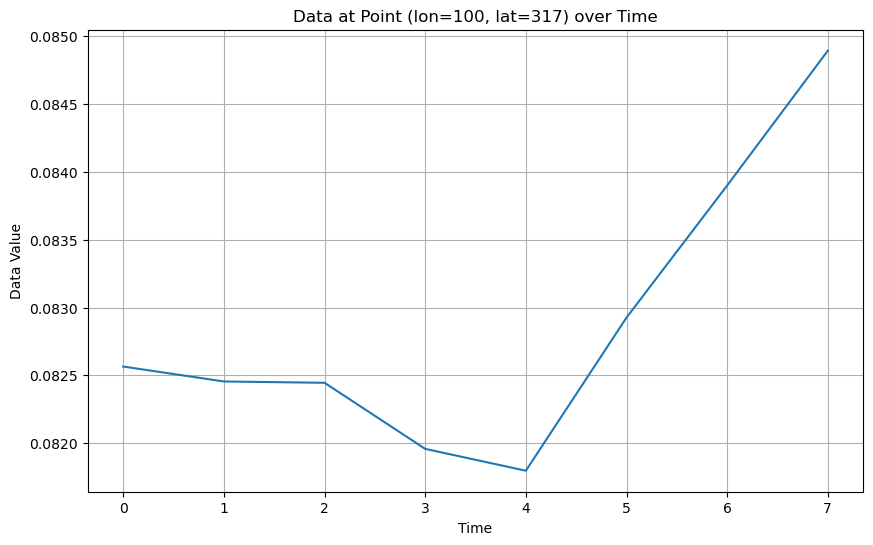

In [19]:
# 绘制图像
plt.figure(figsize=(10, 6))
plt.plot(point_data[220:228])
plt.title(f'Data at Point (lon={lon_idx}, lat={lat_idx}) over Time')
plt.xlabel('Time')
plt.ylabel('Data Value')
plt.grid(True)
plt.show()

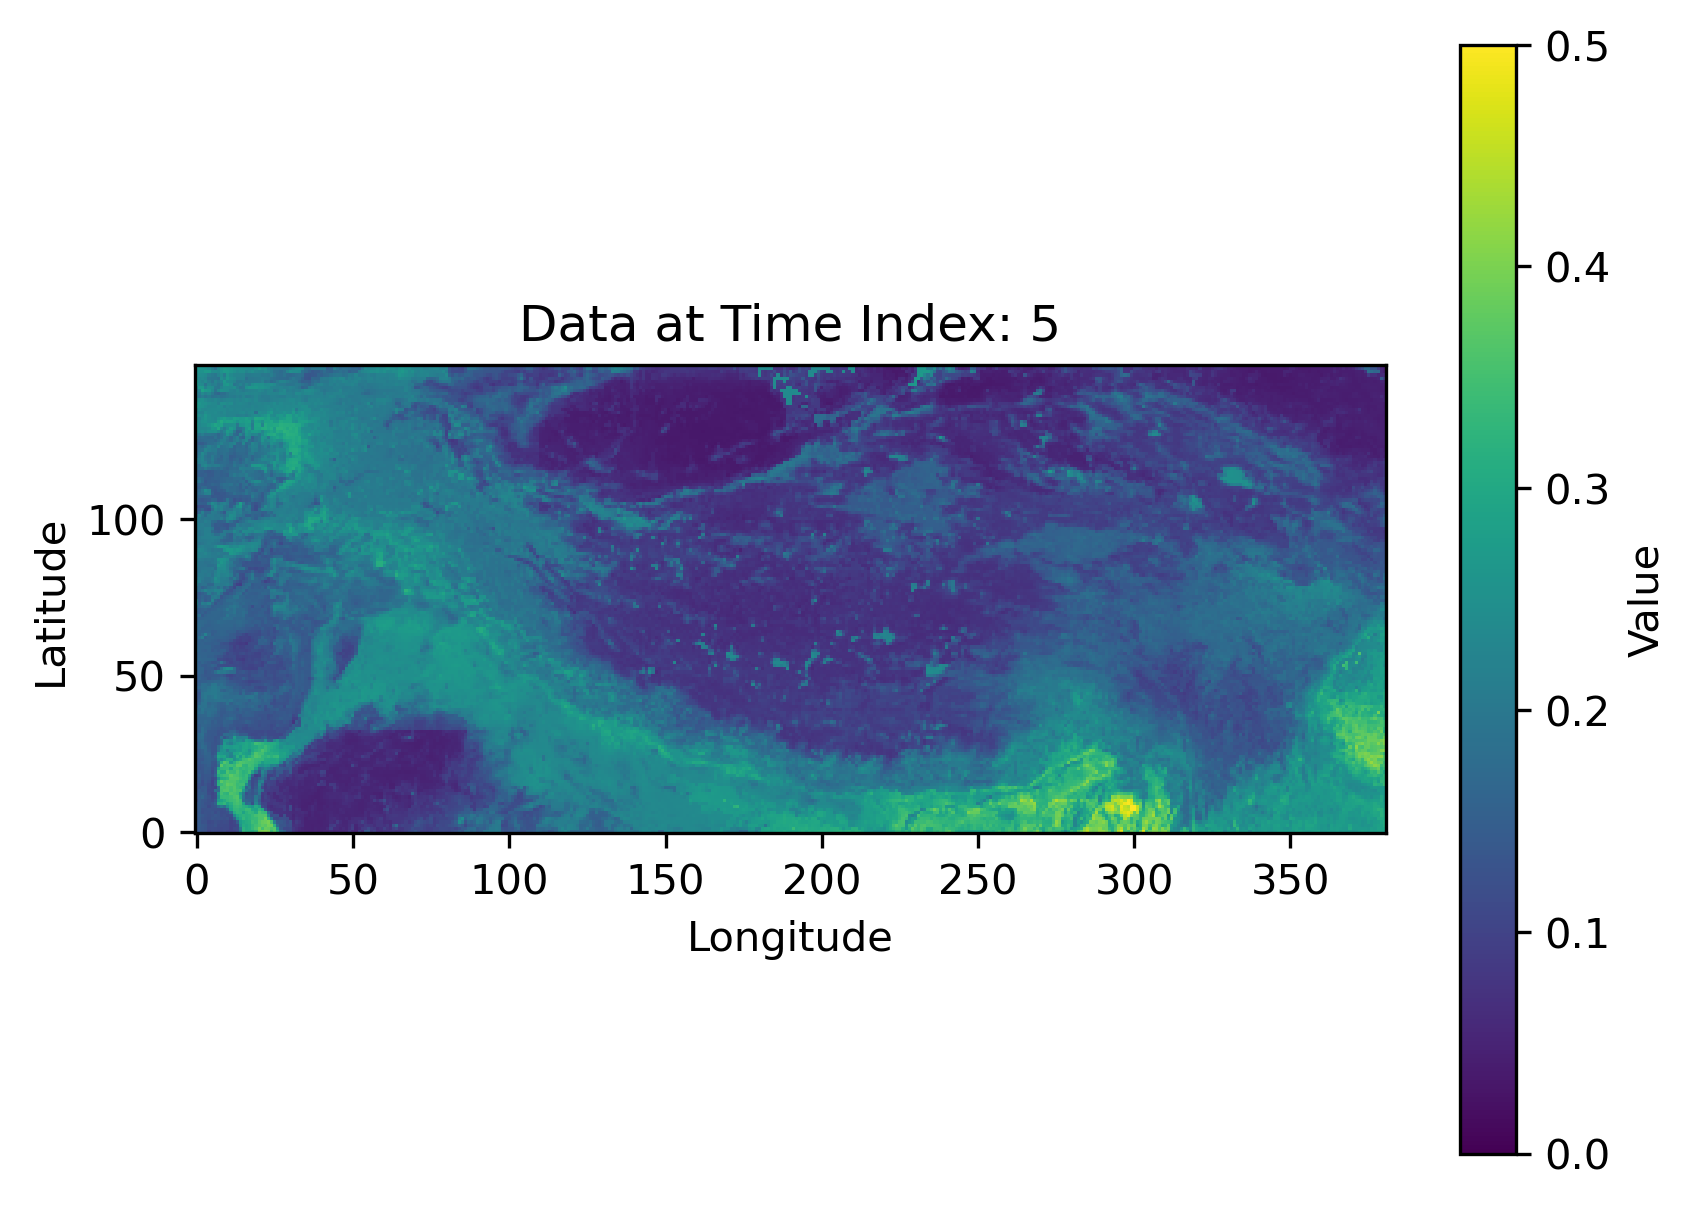

In [2]:
# 绘制图像DPI=300
plt.figure(dpi=300)
plt.imshow(reconstructed_data[42], vmin=0, vmax=0.5, cmap='viridis', origin='lower')
plt.colorbar(label='Value')
plt.title(f"Data at Time Index: {5}")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

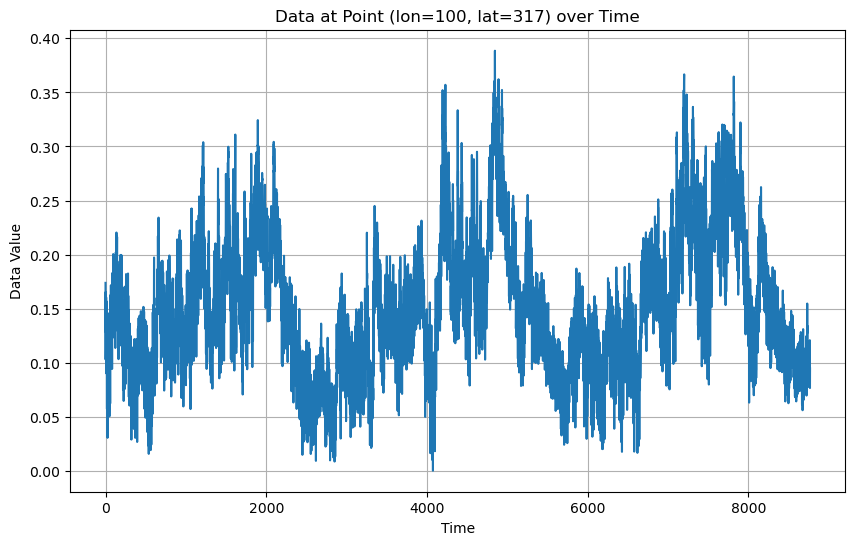

In [10]:
import matplotlib.pyplot as plt
import numpy as np
# 确保你已经有了 reconstructed_data，它的形状是 (time, lon, lat)
# ...
# Load data
reconstructed_data = np.load(r"D:\Data_Store\Dataset\Reconstruction\ST\RESALL\Temporal.npy")
# 选择一个点 (lon_idx, lat_idx)
lon_idx = 100  # 例如选择经度索引为 0 的位置
lat_idx = 317  # 例如选择纬度索引为 0 的位置

# 提取该点在所有时间点上的数据
point_data = reconstructed_data[:, lon_idx, lat_idx]

# 绘制图像
plt.figure(figsize=(10, 6))
plt.plot(point_data)
plt.title(f'Data at Point (lon={lon_idx}, lat={lat_idx}) over Time')
plt.xlabel('Time')
plt.ylabel('Data Value')
plt.grid(True)
plt.show()


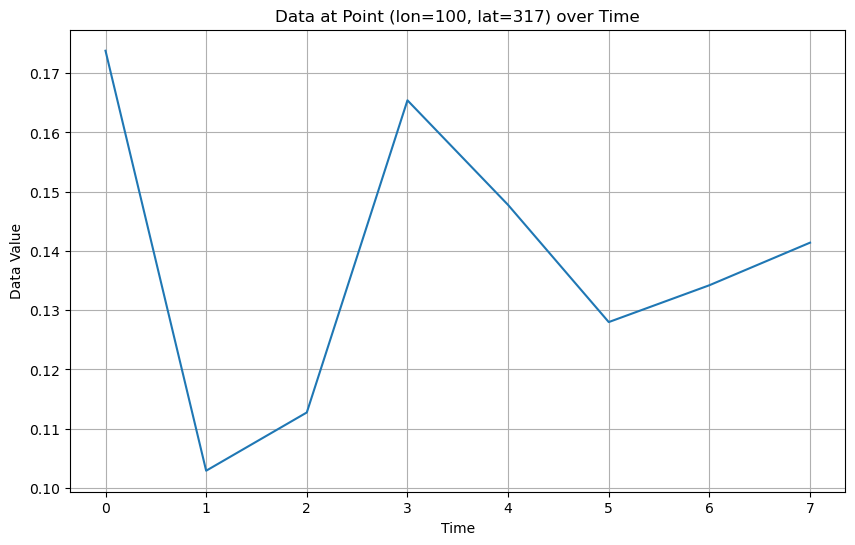

In [12]:
# 绘制图像
plt.figure(figsize=(10, 6))
plt.plot(point_data[0:8])
plt.title(f'Data at Point (lon={lon_idx}, lat={lat_idx}) over Time')
plt.xlabel('Time')
plt.ylabel('Data Value')
plt.grid(True)
plt.show()

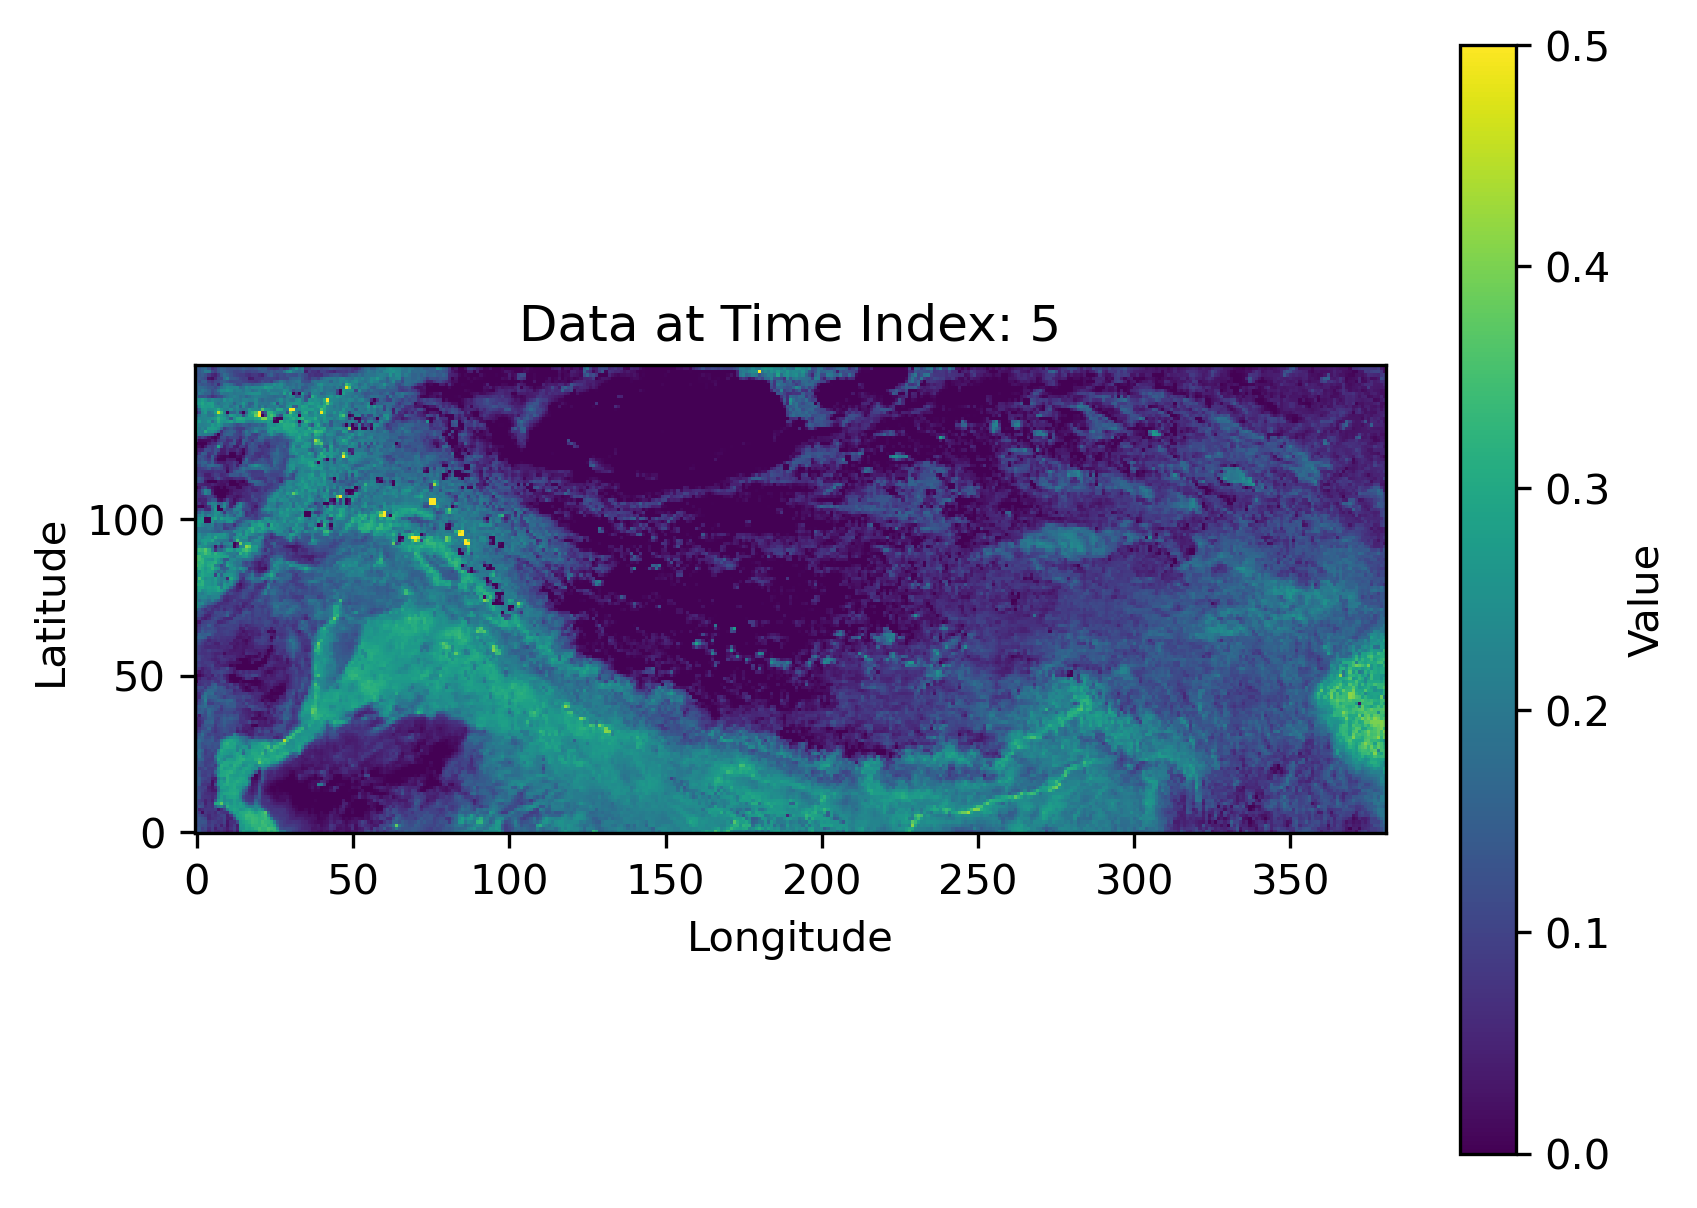

In [2]:
# 绘制图像DPI=300
plt.figure(dpi=300)
plt.imshow(reconstructed_data[42], vmin=0, vmax=0.5, cmap='viridis', origin='lower')
plt.colorbar(label='Value')
plt.title(f"Data at Time Index: {5}")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
from shapely.geometry import Point
from matplotlib import rcParams
import geopandas as gpd
import seaborn as sns
from matplotlib.font_manager import FontProperties
import matplotlib
from matplotlib.ticker import MaxNLocator
from collections import Counter
from matplotlib.legend_handler import HandlerTuple
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.ticker import FuncFormatter

sns.set(style="whitegrid", font='Times New Roman')
matplotlib.rcParams['font.family'] = 'Times New Roman'
#matplotlib.rcParams['axes.labelweight'] = 'bold'
legend_font = FontProperties(family='Times New Roman', size=14)
font_prop = FontProperties(family='Times New Roman', size=16)
def add_degree_E(x, pos):
    return f"{int(x)}°E"

def add_degree_N(y, pos):
    return f"{int(y)}°N"

def apply_clipping(data, lon_grid, lat_grid, shp_path):
    """
    使用.shp文件裁剪数据：在边界外的数据设置为NaN。
    """
    gdf = gpd.read_file(shp_path)
    # 获取.shp文件的几何形状
    poly = gdf.unary_union

    clipped_data = np.full(data.shape, np.nan)

    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            point = Point(lon_grid[i, j], lat_grid[i, j])
            if point.within(poly):
                clipped_data[i, j] = data[i, j]

    return clipped_data

def create_and_draw_subplots(model_ranks, lon_range, lat_range, selected_models,name):
    # 创建图形对象,绘制顺序依赖于fig定义顺序
    colors = ['#afd189', '#ffd60a', '#62e3dc', '#2a6858', '#1f7ea1', '#2b0000', '#E0E0E0']
    fig = plt.figure(figsize=(14, 8))
    ax1 = fig.add_axes([0.146, 0.4012, 0.510, 0.14]) # 左上
    ax2 = fig.add_axes([0.715, 0.400, 0.060, 0.15]) # 右上
    ax4 = fig.add_axes([0.655, 0.05, 0.12, 0.35]) # 右下
    ax3 = fig.add_axes([0.05, 0.05, 0.7, 0.35]) # 左下

    draw_subplot1(ax1, colors, model_ranks, selected_models)
    draw_subplot2(ax2, model_ranks, selected_models, colors)
    draw_subplot4(ax4, colors, model_ranks, selected_models)
    draw_subplot3(ax3, colors, model_ranks, lon_range, lat_range, selected_models,name)

    plt.tight_layout()

    plt.show()

# 折线图（上）
def draw_subplot1(ax, colors, model_ranks, selected_models):
    _, lons = best_models.shape
    x = np.arange(lons)
    row_list = np.zeros((lons, len(selected_models)), dtype=int)
    for i in range(lons):
        # 排除NaN值
        valid_indices = model_ranks[:, i][~np.isnan(model_ranks[:, i])]
        model_counts = Counter(valid_indices.astype(int))
        for model_idx, count in model_counts.items():
            # 确保model_idx在selected_models的索引范围内
            if 0 < model_idx <= len(selected_models):
                row_list[i, model_idx - 1] = count
    
    for i, model in enumerate(selected_models):
        if i < len(colors):
            ax.plot(x, row_list[:, i], linestyle='-', color=colors[i], linewidth=1, zorder=1, label=model)
    
    ax.set_xlim(0, lons)
    ax.tick_params(axis='x', which='both', colors='black', length=3, width=1.5, labelsize=14, bottom=False, top=False, labelbottom=False, labeltop=False)
    ax.tick_params(axis='y', which='both', colors='black', length=3, width=1.5, labelsize=14, direction='out', pad=6, left=True, right=False, labelright=False)
    plt.setp(ax.get_yticklabels(), rotation=90,ha="center", rotation_mode="anchor")
    ax.xaxis.set_major_locator(MaxNLocator(prune='both', nbins=4))
    ax.set_ylabel('Count',size=18)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('black')
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_color('black')
    ax.spines['left'].set_linewidth(1.5)
    ax.grid(False)

# 折线图（右）
def draw_subplot4(ax, colors, model_ranks, selected_models):
    lats, _ = model_ranks.shape
    x = np.arange(lats)
    row_list = np.zeros((lats, len(selected_models)), dtype=int)

    for i in range(lats):
        valid_indices = model_ranks[i, :][~np.isnan(model_ranks[i, :])]
        model_counts = Counter(valid_indices.astype(int))
        for model_idx, count in model_counts.items():
            if 0 < model_idx <= len(selected_models):
                row_list[i, model_idx - 1] = count

    for i, model in enumerate(selected_models):
        if i < len(colors):
            ax.plot(row_list[:, i], x, linestyle='-', color=colors[i], linewidth=1, zorder=1, label=model)
    ax.invert_yaxis()
    ax.set_ylim(0, lats)
    ax.tick_params(axis='x', which='both', colors='black', length=3, width=1.5, labelsize=14, direction='out', pad=3, bottom=True, top=False, labelbottom=True)
    ax.tick_params(axis='y', which='both', colors='black', length=3, width=1.5, labelsize=14, direction='in', left=False, right=False, labelright=False,labelleft=False)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=4))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
    ax.set_xlabel('Count',size=18)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('black')
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_color('black')
    ax.spines['left'].set_linewidth(1.5)
    ax.grid(False)

# 图例
'''
def draw_subplot2(ax, model_ranks, selected_models, colors):
    line_handles = [Line2D([0], [0], color=color, linewidth=3) for color in colors]
    patch_handles = [Patch(color=color) for color in colors]
    legend_elements = [(line, patch) for line, patch in zip(line_handles, patch_handles)]
    ax.legend(legend_elements, selected_models, handler_map={tuple: HandlerTuple(ndivide=None)}, handlelength=1.5, loc='center',fancybox=False, shadow=False, ncol=2, frameon=False, prop=legend_font, columnspacing=-0.3, handletextpad=0.5, labelspacing=0.7)
    ax.axis('off')
'''
def draw_subplot2(ax, model_ranks, selected_models, colors):
    total_points = (~np.isnan(model_ranks)).sum()
    model_counts = Counter(model_ranks.flatten()) 
    percentages = [model_counts.get(i, 0) / total_points for i in range(1, len(selected_models) + 1)]
    bar_width = 0.6
    for i, model in enumerate(selected_models):
        if i < len(colors):
            ax.barh(i+bar_width/2, percentages[i], color=colors[i], height=bar_width)
            pct_text = "{:.1%}".format(percentages[i])
            ax.text(percentages[i] + 0.01, i + bar_width / 2, pct_text, va='center',fontproperties=font_prop, size=14)
        else:
            print(f"No color for model {model}, skipping.")

    ax.set_yticks(np.arange(len(selected_models)) + bar_width / 2)
    ax.set_yticklabels(selected_models)
    ax.set_xlabel('Percentage')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(False)
    #ax.tick_params(axis='x', which='both', colors='black', length=3, width=1.5, labelsize=10, direction='inout', pad=2, bottom=True, top=False, labelbottom=False,labeltop=False)
    ax.tick_params('y', colors='black', length=3, width=1.5, labelsize=14, direction='out',pad=2, which='both', left=True, right=False)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labeltop=False)
    ax.set_facecolor('none')
    ax.axis('on')
    ax.grid(False)

def draw_subplot3(ax, colors, model_ranks, lon_range, lat_range, selected_models,name):
    color_list = [colors[i] for i in range(len(selected_models))]
    # 颜色映射
    cmap = mcolors.ListedColormap(color_list)
    gdf = gpd.read_file(shp_path)
    gdf.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=2)
    image = ax.imshow(model_ranks, cmap=cmap, origin='lower', extent=[new_lon_min, new_lon_max, new_lat_min, new_lat_max])
    ax.set_xlabel('Longitude(°)',size=18)
    ax.set_ylabel('Latitude(°)',size=18)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=10))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=6))
    ax.xaxis.set_major_formatter(FuncFormatter(add_degree_E))
    ax.yaxis.set_major_formatter(FuncFormatter(add_degree_N))
    ax.tick_params(axis='x', which='both', colors='black', length=3, width=1.5, labelsize=14, direction='out', pad=2, bottom=True, top=True, labelbottom=True,labeltop=False)
    ax.tick_params(axis='y', which='both', colors='black', length=3, width=1.5, labelsize=14, direction='out', pad=6, left=True, right=True, labelleft=True,labelright=False)
    plt.setp(ax.get_xticklabels(), rotation=0,rotation_mode="anchor")
    plt.setp(ax.get_yticklabels(), rotation=90,ha="center", rotation_mode="anchor")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('black')
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_color('black')
    ax.spines['left'].set_linewidth(1.5)
    ax.grid(False)
    #ax.grid(True, color='black', linestyle='--',alpha=0.5,zorder=0.1)
    plt.savefig(r"C:\Users\Administrator\Desktop\Draw\min_uncertain"+name+".jpeg", dpi=500, format='jpeg', bbox_inches='tight')

    plt.show()
lat_min = 25.550117
lat_max = 40.450184
lon_min = 66.95031
lon_max = 104.95048
lat_points = 150
lon_points = 381
lat_span = (lat_max - lat_min) / (lat_points - 1)
lon_span = (lon_max - lon_min) / (lon_points - 1)
new_lat_min = lat_min - lat_span / 2
new_lat_max = lat_max + lat_span / 2
new_lon_min = lon_min - lon_span / 2
new_lon_max = lon_max + lon_span / 2

lon_range = np.linspace(lon_min, lon_max, lon_points)
lat_range = np.linspace(lat_min, lat_max, lat_points)
lon_grid, lat_grid = np.meshgrid(lon_range, lat_range)
#model_names = ['KPNet-SP', 'KPNet-ST', 'LSTM', 'RF', 'ResNet-SP', 'ResNet-ST', 'UNet-SP', 'UNet-ST', 'VIT-SP', 'VIT-ST', 'Temporal']
model_names = ['KPNet-ST', 'LSTM', 'RF', 'ResNet-SP', 'UNet-SP', 'VIT-ST', 'Temporal']
selected_models = ['KPNet-ST', 'LSTM', 'RF', 'ResNet-SP', 'UNet-SP', 'VIT-ST', 'Temporal']
shp_path = "D:\\Data_Store\\TPBoundary_new(2021)\\TPBoundary_new(2021).shp"
colors = ['#afd189', '#88352b', '#2a6858', '#62e3dc', '#1f7ea1', '#2b0000', '#F0F0F0']
clipped_data = apply_clipping(best_models, lon_grid, lat_grid, shp_path)
create_and_draw_subplots(clipped_data, lon_range, lat_range, selected_models,name='a')
clipped_data_12 = apply_clipping(best_models_12, lon_grid, lat_grid, shp_path)
create_and_draw_subplots(clipped_data_12, lon_range, lat_range, selected_models,name='b')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import MaxNLocator
import colorsys
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch
import matplotlib.colors as mcolors
import seaborn as sns

np.random.seed(0)  # For reproducibility
data3 = pd.DataFrame({
    'point_name': [f'SKU{i}' for i in range(1, 11)],
    'RMSE': np.random.rand(10) * 10 + 50,
    'ubRMSE': np.random.rand(10) * 5 + 25,
    'R': np.random.rand(10) * 1,
    'Bias': np.random.rand(10) * 0.05
})

def plot_design_changes_extended(data,height = 0.4,Gradation_degree = 0.02,figsize = (6,12),start_color_rmse = '#caf0f8',start_color_ubrmse = '#e9f5db',name=None):

    def adjust_color(color, brightness_factor):
        rgb = mcolors.hex2color(color)
        hls = colorsys.rgb_to_hls(*rgb)
        new_hls = (hls[0], max(0, min(1, brightness_factor * hls[1])), hls[2])
        # 将调整后的HLS颜色转换回RGB，然后转换为HEX
        new_rgb = colorsys.hls_to_rgb(*new_hls)
        return mcolors.to_hex(new_rgb)
    
    sns.set(style="whitegrid", font='Times New Roman')
    matplotlib.rcParams['font.family'] = 'Times New Roman'
    matplotlib.rcParams['axes.labelweight'] = 'bold'
    legend_font = FontProperties(family='Times New Roman', size=12)
    font_prop = FontProperties(family='Times New Roman', size=12)
    fig, ax1 = plt.subplots(figsize=figsize)
    for item in ([ax1.xaxis.label, ax1.yaxis.label] + ax1.get_xticklabels() + ax1.get_yticklabels()):
        item.set_fontproperties(font_prop)

    # 避免重叠
    y = np.arange(len(data))
    y1 = [i - height/1.8 for i in y]
    y2 = [i + height/1.8 for i in y]
    yy = data['point_name'].to_list()

    # ax1 RMSE
    colors_rmse = [adjust_color(start_color_rmse, 1 - Gradation_degree * i) for i in range(len(data['RMSE']))]
    for i, (value, pos) in enumerate(zip(data['RMSE'], y1)):
        ax1.barh(pos, value, height=height, color=colors_rmse[-i-1],zorder=0.5)
        ax1.text(0, pos, f'{value:.3f}', size=10, ha='right', va='center', fontproperties=font_prop, zorder=5)
    ax1.set_yticks(y)
    ax1.set_yticklabels(yy)

    # ax2 ubRMSE
    ax2 = ax1.twiny()
    colors_ubrmse = [adjust_color(start_color_ubrmse, 1 - Gradation_degree * i) for i in range(len(data['ubRMSE']))]
    for i, (value, pos) in enumerate(zip(data['ubRMSE'], y2)):
        ax2.barh(pos, value, height=height, color=colors_ubrmse[-i-1], zorder=0.5)
        ax2.text(0, pos, f'{value:.3f}', size=10, ha='right', va='center', fontproperties=font_prop, zorder=5)
    # ax3 R
    ax3 = ax1.twiny()
    ax3.plot(data['R'], y2, label='R',linestyle='--', color='#bc6c25', linewidth=1.5, marker='X', markeredgecolor='lightgrey', markersize=10,alpha=0.5,zorder=1)

    # ax4 Bias
    ax4 = ax1.twiny()
    ax4.plot(data['Bias'], y1, '--', label='Bias',color='purple', linewidth=1.5, marker='P',markeredgecolor='grey', markersize=10,alpha=0.5,zorder=1) 

    # 添加文本
    r_range = data['R'].max() - data['R'].min()
    bias_range = data['Bias'].max() - data['Bias'].min()
    r_offset = r_range * 0.05
    bias_offset = bias_range * 0.05
    for x, y_val in zip(data['R'], y2):
        #ax3.text(x + r_offset, y_val, f' {x:.3f}', color='blue', va='center', ha='left', fontproperties=font_prop,zorder=2, size=10)
        ax3.text(x - r_offset, y_val, f' {x:.3f}', color='blue', va='center', ha='left', fontproperties=font_prop,zorder=2, size=10)
    for x, y_val in zip(data['Bias'], y1):
        ax4.text(x - bias_offset, y_val, f' {x:.3f}', color='purple', va='center', ha='left', fontproperties=font_prop,zorder=2, size=10)

    # 轴位置控制
    ax1.spines['bottom'].set_position(('outward', 0))
    ax1.xaxis.set_ticks_position('bottom')
    ax1.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 12))
    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax3.spines['top'].set_position(('axes', 1.0))
    ax3.xaxis.set_ticks_position('top')
    ax3.xaxis.set_label_position('top')
    ax4.spines['top'].set_position(('outward', 12))
    ax4.xaxis.set_ticks_position('top')
    ax4.xaxis.set_label_position('top')

    # 轴范围控制(先计算拓展范围)
    expand_ratio = 0.8
    data_RMSE_max = data['RMSE'].max()
    data_ubRMSE_max = data['ubRMSE'].max()
    RMSE_new_max = data_RMSE_max + (data_RMSE_max) * expand_ratio
    ubRMSE_new_max = data_ubRMSE_max + (data_ubRMSE_max) * expand_ratio

    expand_ratio = 0.5
    shift_ratio = 0.1
    data_R_min, data_R_max = data['R'].min(), data['R'].max()
    R_range = data_R_max - data_R_min
    R_new_min = data_R_min - R_range * expand_ratio * (1 - shift_ratio)
    R_new_max = data_R_max + R_range * expand_ratio * shift_ratio
    data_Bias_min, data_Bias_max = data['Bias'].min(), data['Bias'].max()
    Bias_range = data_Bias_max - data_Bias_min
    Bias_new_min = data_Bias_min - Bias_range * expand_ratio * (1 - shift_ratio)
    Bias_new_max = data_Bias_max + Bias_range * expand_ratio * shift_ratio

    ax1.set_xlim([0.0, 0.23])
    ax2.set_xlim([0, 0.23])
    ax3.set_xlim([-0.5, 0.95])
    ax4.set_xlim([-0.33, 0.15])
    ax1.barh(y, RMSE_new_max, height=height*2, color='lightgray', alpha=0.4, zorder=0)
    ax1.tick_params('y', colors='black', length=3, width=1.5, labelsize=12, pad=4)
    ax1.tick_params('x', colors=colors_rmse[-1], length=3, width=1, labelsize=10,direction='out', pad=1)
    ax2.tick_params('x', colors=colors_ubrmse[-1], length=3, width=1, labelsize=10,direction='in', pad=1)
    ax3.tick_params(axis='x', colors='blue', length=3, width=1, labelsize=10,direction='in', pad=0)
    ax4.tick_params('x', colors='purple', length=3, width=1, labelsize=10,direction='in', pad=0)
    ax1.xaxis.set_major_locator(MaxNLocator(prune='lower', nbins=5))
    ax2.xaxis.set_major_locator(MaxNLocator(prune='lower', nbins=4))
    ax3.xaxis.set_major_locator(MaxNLocator(prune='lower', nbins=4))
    ax4.xaxis.set_major_locator(MaxNLocator(prune='lower', nbins=3))

    # x轴绘制
    ax1.set_xlabel('RMSE', fontproperties=font_prop)
    ax2.set_xlabel('ubRMSE', fontproperties=font_prop)
    ax3.set_xlabel('Bias', fontproperties=font_prop)
    ax4.set_xlabel('R', fontproperties=font_prop)

    # 刻度线控制
    ax2.yaxis.set_ticks_position('none')
    ax3.yaxis.set_ticks_position('none')
    ax4.yaxis.set_ticks_position('none')
    for ax in [ax1, ax2, ax3, ax4]:
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position("right")
        ax.invert_xaxis()

    # 控制刻度线上下边界缝隙距离
    y_min, y_max = ax1.get_ylim()
    padding = (y_max - y_min) * -0.04
    ax1.set_ylim(y_min - padding, y_max + padding)

    # 绘制图例
    original_handles = []
    original_labels = []
    for ax in [ax1,ax2, ax3, ax4]:
        handles, labels = ax.get_legend_handles_labels()
        original_handles.extend(handles)
        original_labels.extend(labels)
    gradient_patch_rmse = [mpatches.Patch(color=colors_rmse[5], label='RMSE')]
    gradient_patch_ubrmse = [mpatches.Patch(color=colors_ubrmse[5], label='ubRMSE')]
    final_handles = original_handles + gradient_patch_rmse + gradient_patch_ubrmse
    final_labels = original_labels + ['RMSE', 'ubRMSE']
    plt.legend(final_handles, final_labels, loc='upper left', bbox_to_anchor=(-0.03, 1.07), fancybox=False, shadow=False, ncol=6, frameon=False, prop=legend_font)

    # 文本标签
    y_min, y_max = ax1.get_ylim()
    bias_label_y = y_max + (y_max - y_min) * 0.02
    r_label_y = bias_label_y - (y_max - y_min) * 0.025
    rmse_label_y = y_min - (y_max - y_min) * 0.005
    ubrmse_label_y = rmse_label_y - (y_max - y_min) * 0.02
    x = -0.005
    ax1.text(x, bias_label_y, 'Bias', size=12, fontproperties=font_prop, zorder=5, ha='left')
    ax1.text(x, r_label_y, 'PearsonR', size=12, fontproperties=font_prop, zorder=5, ha='left')
    ax1.text(x, rmse_label_y, 'RMSE', size=12, fontproperties=font_prop, zorder=5, ha='left')
    ax1.text(x, ubrmse_label_y, 'ubRMSE', size=12, fontproperties=font_prop, zorder=5, ha='left')

    # 控制y轴间隙
    current_num_ticks = len(ax1.get_yticks())
    new_num_ticks = int(current_num_ticks * 1.1)
    ax1.yaxis.set_major_locator(MaxNLocator(new_num_ticks))

    # 共同控制：隐藏右侧指标轴、x轴label
    for ax in [ax1, ax2, ax3, ax4]:
        ax.spines['left'].set_visible(False)
        ax.xaxis.label.set_visible(False)
    for ax in [ax1, ax2, ax3, ax4]:ax.grid(False)
    ax3.grid(True, color='blue', linestyle='--',alpha=0.5,zorder=0.1)
    ax4.grid(True, color='purple', linestyle='--',alpha=0.5,zorder=0.1)
    for ax in [ax1, ax2, ax3, ax4]:ax.grid(False)
    ax1.grid(True, color='lightgray', linestyle='--', alpha=0.5, which='both', axis='y', zorder=0.5)
    file_path = r'C:\Users\Administrator\Desktop\\' + name + '.jpeg'
    fig.savefig(file_path, dpi=500, format='jpeg', bbox_inches='tight')
    plt.show()

plot_design_changes_extended(df_other_networks,name = "a")
#plot_design_changes_extended(df_ctp,name = "b")

In [ ]:
def reconstruct_data(file_path, vars_index_map, vars_day_argu, Day_time_step, vars_half_day_argu, Half_Day_time_step, vars_hour_argu, Hour_time_step, vars_static_argu, data, model, patch_size=16, stride=12, std=None, mean=None, time_batch_size=50, time_overlap=18, mode=None):
    times, lat, lon = data.time.shape[0], data.lat.shape[0], data.lon.shape[0]

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    reconstructed_data = np.zeros((times, lat, lon))
    time_shift = int(Day_time_step / 2)  # 根据您的描述计算前移量
    
    # 从左下开始预测
    for time_start in range(0, times, time_batch_size - time_overlap):
        batch_start_time = time.time()  # 开始计时
        
        time_end = min(time_start + time_batch_size, times)
        # 对于第一个批次，我们保留整个数据段，对于后续批次，我们跳过前移量部分
        effective_start = time_start if time_start == 0 else time_start + time_shift
        effective_end = time_end  # 有效结束时间保持不变
        
        data_batch = data.isel(time=slice(time_start, time_end)).to_array().compute().values  # channels, times, lat, lon
        if mode is None:
            # 从左下开始预测
            for i in range(0, lat - patch_size + 1, stride):
                for j in range(0, lon - patch_size + 1, stride):
                    data_chunk = data_batch[:, :, i:i+patch_size, j:j+patch_size]  # channels, times, lat, lon
                    day_sample, half_day_sample, hour_sample, static_sample = split_dataset_filling_faster(vars_index_map, vars_day_argu, Day_time_step, vars_half_day_argu, Half_Day_time_step, vars_hour_argu, Hour_time_step, vars_static_argu, data_chunk)
                    output = batch_process(model, day_sample, half_day_sample, hour_sample, static_sample, batch_size=16, device=device, std=std, mean=mean)
                    # 仅更新有效时间段内的数据
                    reconstructed_data[effective_start:effective_end, i:i+patch_size, j:j+patch_size] = calculate_overlap(reconstructed_data[effective_start:effective_end, i:i+patch_size, j:j+patch_size], output, time_shift if time_start != 0 else 0)
            
            # 以下代码块针对边缘情况重复上述逻辑
            # 注意：确保更新这些部分以反映正确的有效时间段和空间范围
            
            # 纵向不完整处理
            # 横向不完整处理
            # 非完整区块处理
            
        elif mode == 'all':
            day_sample, half_day_sample, hour_sample, static_sample = split_dataset_filling_faster(vars_index_map, vars_day_argu, Day_time_step, vars_half_day_argu, Half_Day_time_step, vars_hour_argu, Hour_time_step, vars_static_argu, data_batch)
            output = batch_process(model, day_sample, half_day_sample, hour_sample, static_sample, batch_size=1, device=device, std=std, mean=mean)
            # 仅更新有效时间段内的数据
            reconstructed_data[effective_start:effective_end, :, :] = output
            
        batch_end_time = time.time()  # 结束计时
        print(f"处理时间段 {time_start} 到 {time_end} 完成. 总耗时：{batch_end_time - batch_start_time:.2f}s")
        reconstructed_data = np.clip(reconstructed_data, 0, 1)  # 将重建的数据值限制在0和1之间
        np.save(file_path, reconstructed_data)  # 保存重建后的数据到文件
        
    return reconstructed_data

In [ ]:
import torch
import torch.nn as nn

from models.block import BasicBlock, Bottleneck, Compression_excitation_block, ResBlock, Multi_scale_block
from models.spatial_block import KPNet, ResNet, UNet,ViT
from models.temporal_block import TemporalDilatedConv

class STConvNet(nn.Module):
    def __init__(self, usage_model='ST',temporal_usage_max_avg=False,temporal_usage_position_embedding=False, spatial_block=None, concat_method='serial', output_method='add', # 模型选择
                 hour_in_channels=8, hour_step=17, day_in_channels=23, day_step=5,                            # 时间卷积元素
                 half_day_in_channels=2, half_day_step=9, static_in_channels=11,
                 temporal_kernel_size=2, target_time_steps=2,
                 block=BasicBlock, layers=[3,3,9,3], spatial_out_channels=1,                                  # 空间卷积元素
                 init_mid_channels=128,dropout_rate = 0.1,layer_scale_init_value=1e-6,**kwargs):                       
        """
        初始化类：选择接受空间块和连接模式，之后分别为时间块必要元素和空间块必要元素
        usage_model: 使用模式，可选'ST'（时空模型）, 'temporal'（仅时间模型）, 'spatial'（仅空间模型）
        temporal_usage_max_avg: 是否使用全局池化层
        spatial_block: 空间块类型，可选'resnet', 'unet', 'ernet', 'ernet_lite', 'kpnet', 'kpnet_mul_head', 'kpnet_Encoder_lite', 'vae','Spatial_transformer'
        concat_method: 连接模式，可选'parallel', 'serial'
        output_method: 输出模式，可选'add', 'individual', 'single'
        block: Resnet空间块中的基本块类型，可选'BasicBlock', 'Bottleneck'

        kpnet_mul_head：已经在模型内部实现了concat和残差连接
        """
        super(STConvNet, self).__init__()
        self.concat_method = concat_method
        self.output_method = output_method
        self.spatial_block = spatial_block
        self.usage_model = usage_model
        self.temporal_conv = TemporalDilatedConv(hour_in_channels, hour_step, 
                                                 day_in_channels, day_step, 
                                                 half_day_in_channels, half_day_step, 
                                                 static_in_channels, temporal_kernel_size, 
                                                 target_time_steps,temporal_usage_max_avg=temporal_usage_max_avg,temporal_usage_position_embedding=temporal_usage_position_embedding)
        
        temporal_out_channels = self.temporal_conv.get_out_channels()
        self.temporal_output = nn.Conv2d(temporal_out_channels, 1, kernel_size=1)
        
        if self.usage_model == 'spatial' or self.concat_method=='parallel':spatial_input_channels = hour_in_channels + day_in_channels + half_day_in_channels + static_in_channels
        elif self.usage_model == 'ST': spatial_input_channels = temporal_out_channels + hour_in_channels + day_in_channels + half_day_in_channels + static_in_channels
        else: spatial_input_channels = temporal_out_channels

        self.final = nn.Conv2d(spatial_out_channels * 2,spatial_out_channels * 1,kernel_size=1)
        if spatial_block is None or spatial_block=='None':
            pass
        elif spatial_block == 'resnet':
            self.spatial_conv = ResNet(eval(block), layers, spatial_input_channels, spatial_out_channels,init_mid_channels=init_mid_channels)
        elif spatial_block == 'unet':
            self.spatial_conv = UNet(spatial_input_channels, spatial_out_channels,init_mid_channels=init_mid_channels)
        elif spatial_block == 'kpnet':
            self.spatial_conv = KPNet(spatial_input_channels, spatial_out_channels,net_depth=layers, init_mid_channels=init_mid_channels, dropout_rate = dropout_rate, layer_scale_init_value=layer_scale_init_value)
        elif spatial_block == 'ViT':
            self.spatial_conv = ViT(input_channels = spatial_input_channels, out_channels = spatial_out_channels, positional_embedding = '1d_absolute_trainable')
        else:
            raise ValueError("Invalid spatial_block type")

    def forward(self, hour_input, day_input, half_day_input, static_input):
        """
        输入：hour_input, day_input, half_day_input, static_input
        输出：spatial_output
        """        
        # 时空卷积
        if self.usage_model == 'ST':
            # 时间卷积处理
            temporal_output = self.temporal_conv(hour_input, day_input, half_day_input, static_input)
            temporal_output_channel = self.temporal_output(temporal_output)

            # 空间卷积处理
            if self.concat_method=='parallel':
                mid_hour = hour_input[:, :, hour_input.size(2) // 2, :, :]
                mid_day = day_input[:, :, day_input.size(2) // 2, :, :]
                mid_half_day = half_day_input[:, :, half_day_input.size(2) // 2, :, :]
                combined_static = torch.cat((mid_hour, mid_day, mid_half_day, static_input), dim=1)
                spatial_output = self.spatial_conv(combined_static)

            elif self.concat_method=='serial':
                mid_hour = hour_input[:, :, hour_input.size(2) // 2, :, :]
                mid_day = day_input[:, :, day_input.size(2) // 2, :, :]
                mid_half_day = half_day_input[:, :, half_day_input.size(2) // 2, :, :]
                combined_static = torch.cat((mid_hour, mid_day, mid_half_day, static_input, temporal_output), dim=1)
                spatial_output = self.spatial_conv(combined_static)


            # 输出模式
            if self.output_method=='add':
                return (spatial_output[0] + temporal_output_channel,) + spatial_output[1:] if isinstance(spatial_output, tuple) else spatial_output + temporal_output_channel
            
            elif self.output_method=='individual':
                if isinstance(spatial_output, tuple):
                    return (*spatial_output, temporal_output_channel)
                else:
                    out = self.final(torch.cat((spatial_output, temporal_output_channel), dim=1))
                    return (out, spatial_output, temporal_output_channel)
                
            elif self.output_method == 'single':
                return spatial_output

        # 时间卷积
        elif self.usage_model == 'temporal':
            temporal_output = self.temporal_conv(hour_input, day_input, half_day_input, static_input)
            temporal_output_channel = self.temporal_output(temporal_output)
            return temporal_output_channel

        # 空间卷积
        elif self.usage_model == 'spatial':
            mid_hour = hour_input[:, :, hour_input.size(2) // 2, :, :] # batchsize channels time_steps lat lon  # channels time_steps lat lon
            mid_day = day_input[:, :, day_input.size(2) // 2, :, :]
            mid_half_day = half_day_input[:, :, half_day_input.size(2) // 2, :, :]
            combined_static = torch.cat((mid_hour, mid_day, mid_half_day, static_input), dim=1)
            spatial_output = self.spatial_conv(combined_static)
            return spatial_output


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TemporalDilatedConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, dilation):
        super(TemporalDilatedConvBlock, self).__init__()
        self.expand_ratio = 6
        self.conv_time = nn.Sequential(nn.Conv3d(in_channels, out_channels, kernel_size=(kernel_size, 1, 1), padding=(padding, 0, 0), dilation=(dilation, 1, 1)),
                                    nn.GELU())
        self.conv1 = nn.Sequential(nn.Conv3d(out_channels, out_channels*self.expand_ratio, kernel_size=(1, 1, 1)),
                                   nn.GELU())
        self.conv2 = nn.Sequential(nn.Conv3d(out_channels*self.expand_ratio, out_channels, kernel_size=(1, 1, 1)),
                                   nn.GELU())
    def forward(self, x):
        x = self.conv_time(x)
        x = self.conv1(x)
        x = self.conv2(x)
        return x


class TemporalDilatedConv(nn.Module):
    def __init__(self, hour_in_channels,hour_step,day_in_channels,day_step,half_day_in_channels,half_day_step,static_in_channels, kernel_size, target_time_steps,temporal_usage_max_avg=True,temporal_usage_position_embedding=True,reduction_ratio=8):
        super(TemporalDilatedConv, self).__init__()
        # 时间维度的卷积核大小为2，不使用填充
        self.expand_ratio = 6 
        self.temporal_usage_max_avg = temporal_usage_max_avg
        self.temporal_usage_position_embedding = temporal_usage_position_embedding
        self.target_time_steps = target_time_steps
        if temporal_usage_position_embedding == True:
            hour_in_channels -= 1
            day_in_channels -= 1
            half_day_in_channels -= 1
            static_in_channels -= 2

        self.hour_block = self._create_block(hour_in_channels, hour_in_channels, hour_step, kernel_size)
        self.day_block = self._create_block(day_in_channels, day_in_channels, day_step, kernel_size)
        self.half_day_block = self._create_block(half_day_in_channels, half_day_in_channels, half_day_step, kernel_size)  # 数据输入通道只有一个
        self.static_block = nn.Sequential(nn.Conv2d(static_in_channels, static_in_channels, kernel_size=(1, 1)), nn.ReLU())
        self.out_channels = hour_in_channels + day_in_channels + half_day_in_channels 

        self.final_conv = nn.Sequential(nn.Conv3d(self.out_channels, self.out_channels, kernel_size=(2, 1, 1), padding=(0, 0, 0)),
                                        nn.GELU())

        self.out_channels = self.out_channels + static_in_channels
        
        self.conv_2d = nn.Sequential(nn.Conv2d(self.out_channels, self.out_channels * self.expand_ratio, kernel_size=1),
                                 nn.GELU(),
                                 nn.Conv2d(self.out_channels * self.expand_ratio, self.out_channels * self.expand_ratio//2, kernel_size=1),
                                 nn.GELU(),
                                 nn.Conv2d(self.out_channels * self.expand_ratio//2, self.out_channels//2, kernel_size=1))
        
        self.out_channels = self.out_channels//2

    def _create_block(self, in_channels, out_channels, time_steps, kernel_size):
        layers = []
        current_time_steps = time_steps
        dilation = 1
        while current_time_steps > self.target_time_steps:
            required_reduction = current_time_steps - self.target_time_steps
            adjusted_kernel_size = required_reduction + 1 if required_reduction + 1 < kernel_size else kernel_size
            padding = 0

            layers.append(TemporalDilatedConvBlock(in_channels, out_channels, adjusted_kernel_size, padding, dilation))
            current_time_steps = current_time_steps - dilation * (adjusted_kernel_size - 1)
            in_channels = out_channels
            dilation *= 2

        return nn.Sequential(*layers)

    def process_temporal_data(self, input_data):
        processed_data = input_data[:, :-1, :, :, :]
        # 将时间通道加到其他所有通道上#time_channel = input_data[:, -1:, :, :, :]
        processed_data += input_data[:, -1:, :, :, :]

        return processed_data

    def process_static_data(self, static_input, hour_input, day_input, half_day_input):
        # 提取经度和纬度通道
        lon = static_input[:, -2:-1, :, :]  # [batch_size, 1, height, width]
        lat = static_input[:, -1:, :, :]    # [batch_size, 1, height, width]

        # 从原始数据中移除经度和纬度通道
        processed_static = static_input[:, :-2, :, :]

        # 扩展经度和纬度
        lon_expanded_hour = lon.unsqueeze(2).expand(-1, -1, hour_input.shape[2], -1, -1)
        lat_expanded_hour = lat.unsqueeze(2).expand(-1, -1, hour_input.shape[2], -1, -1)

        lon_expanded_day = lon.unsqueeze(2).expand(-1, -1, day_input.shape[2], -1, -1)
        lat_expanded_day = lat.unsqueeze(2).expand(-1, -1, day_input.shape[2], -1, -1)

        lon_expanded_half_day = lon.unsqueeze(2).expand(-1, -1, half_day_input.shape[2], -1, -1)
        lat_expanded_half_day = lat.unsqueeze(2).expand(-1, -1, half_day_input.shape[2], -1, -1)

        # 将经度和纬度加到其他所有通道上
        hour_input += lon_expanded_hour + lat_expanded_hour
        day_input += lon_expanded_day + lat_expanded_day
        half_day_input += lon_expanded_half_day + lat_expanded_half_day

        return processed_static, hour_input, day_input, half_day_input

    def get_out_channels(self):
        return self.out_channels

    def forward(self, hour_input, day_input, half_day_input, static_input):
        if self.temporal_usage_position_embedding == True:

            # 绝对时间编码
            hour_input = self.process_temporal_data(hour_input)
            day_input = self.process_temporal_data(day_input)
            half_day_input = self.process_temporal_data(half_day_input)

            # 绝对位置编码
            static_input,hour_input,day_input,half_day_input = self.process_static_data(static_input,hour_input,day_input,half_day_input)

        hour_output = self.hour_block(hour_input)
        day_output = self.day_block(day_input)
        half_day_output = self.half_day_block(half_day_input)
        
        # 静态数据卷积
        static_output = self.static_block(static_input)
        combined_output = torch.cat((hour_output, day_output, half_day_output), dim=1)
        final_output = self.final_conv(combined_output)
        final_output = final_output.squeeze(2)

        final_output = torch.cat((final_output, static_output), dim=1)
        final_outconv = self.conv_2d(final_output)
        return final_outconv
    

### 222

In [ ]:
import torch
import torch.nn as nn

from models.block import BasicBlock, Bottleneck, Compression_excitation_block, ResBlock, Multi_scale_block
from models.spatial_block import KPNet, ResNet, UNet,ViT
from models.temporal_block import TemporalDilatedConv

class STConvNet(nn.Module):
    def __init__(self, usage_model='ST',temporal_usage_max_avg=False,temporal_usage_position_embedding=False, spatial_block=None, concat_method='serial', output_method='add', # 模型选择
                 hour_in_channels=8, hour_step=17, day_in_channels=23, day_step=5,                            # 时间卷积元素
                 half_day_in_channels=2, half_day_step=9, static_in_channels=11,
                 temporal_kernel_size=2, target_time_steps=2,
                 block=BasicBlock, layers=[3,3,9,3], spatial_out_channels=1,                                  # 空间卷积元素
                 init_mid_channels=128,dropout_rate = 0.1,layer_scale_init_value=1e-6,**kwargs):                       
        """
        初始化类：选择接受空间块和连接模式，之后分别为时间块必要元素和空间块必要元素
        usage_model: 使用模式，可选'ST'（时空模型）, 'temporal'（仅时间模型）, 'spatial'（仅空间模型）
        temporal_usage_max_avg: 是否使用全局池化层
        spatial_block: 空间块类型，可选'resnet', 'unet', 'ernet', 'ernet_lite', 'kpnet', 'kpnet_mul_head', 'kpnet_Encoder_lite', 'vae','Spatial_transformer'
        concat_method: 连接模式，可选'parallel', 'serial'
        output_method: 输出模式，可选'add', 'individual', 'single'
        block: Resnet空间块中的基本块类型，可选'BasicBlock', 'Bottleneck'

        kpnet_mul_head：已经在模型内部实现了concat和残差连接
        """
        super(STConvNet, self).__init__()
        self.concat_method = concat_method
        self.output_method = output_method
        self.spatial_block = spatial_block
        self.usage_model = usage_model
        self.temporal_conv = TemporalDilatedConv(hour_in_channels, hour_step, 
                                                 day_in_channels, day_step, 
                                                 half_day_in_channels, half_day_step, 
                                                 static_in_channels, temporal_kernel_size, 
                                                 target_time_steps,temporal_usage_max_avg=temporal_usage_max_avg,temporal_usage_position_embedding=temporal_usage_position_embedding)
        
        temporal_out_channels = self.temporal_conv.get_out_channels()
        self.temporal_output = nn.Conv2d(temporal_out_channels, 1, kernel_size=1)
        
        if self.usage_model == 'spatial' or self.concat_method=='parallel':spatial_input_channels = hour_in_channels + day_in_channels + half_day_in_channels + static_in_channels
        elif self.usage_model == 'ST': spatial_input_channels = temporal_out_channels
        else: spatial_input_channels = temporal_out_channels

        self.final = nn.Conv2d(spatial_out_channels * 2,spatial_out_channels * 1,kernel_size=1)
        if spatial_block is None or spatial_block=='None':
            pass
        elif spatial_block == 'resnet':
            self.spatial_conv = ResNet(eval(block), layers, spatial_input_channels, spatial_out_channels,init_mid_channels=init_mid_channels)
        elif spatial_block == 'unet':
            self.spatial_conv = UNet(spatial_input_channels, spatial_out_channels,init_mid_channels=init_mid_channels)
        elif spatial_block == 'kpnet':
            self.spatial_conv = KPNet(spatial_input_channels, spatial_out_channels,net_depth=layers, init_mid_channels=init_mid_channels, dropout_rate = dropout_rate, layer_scale_init_value=layer_scale_init_value)
        elif spatial_block == 'ViT':
            self.spatial_conv = ViT(input_channels = spatial_input_channels, out_channels = spatial_out_channels, positional_embedding = '1d_absolute_trainable')
        else:
            raise ValueError("Invalid spatial_block type")

    def forward(self, hour_input, day_input, half_day_input, static_input):
        """
        输入：hour_input, day_input, half_day_input, static_input
        输出：spatial_output
        """        
        # 时空卷积
        if self.usage_model == 'ST':
            # 时间卷积处理
            temporal_output = self.temporal_conv(hour_input, day_input, half_day_input, static_input)
            temporal_output_channel = self.temporal_output(temporal_output)

            # 空间卷积处理
            if self.concat_method=='parallel':
                mid_hour = hour_input[:, :, hour_input.size(2) // 2, :, :]
                mid_day = day_input[:, :, day_input.size(2) // 2, :, :]
                mid_half_day = half_day_input[:, :, half_day_input.size(2) // 2, :, :]
                combined_static = torch.cat((mid_hour, mid_day, mid_half_day, static_input), dim=1)
                spatial_output = self.spatial_conv(combined_static)
            elif self.concat_method=='serial':
                spatial_output = self.spatial_conv(temporal_output)


            # 输出模式
            if self.output_method=='add':
                return (spatial_output[0] + temporal_output_channel,) + spatial_output[1:] if isinstance(spatial_output, tuple) else spatial_output + temporal_output_channel
            
            elif self.output_method=='individual':
                if isinstance(spatial_output, tuple):
                    return (*spatial_output, temporal_output_channel)
                else:
                    out = self.final(torch.cat((spatial_output, temporal_output_channel), dim=1))
                    return (out, spatial_output, temporal_output_channel)
                
            elif self.output_method == 'single':
                return spatial_output

        # 时间卷积
        elif self.usage_model == 'temporal':
            temporal_output = self.temporal_conv(hour_input, day_input, half_day_input, static_input)
            temporal_output_channel = self.temporal_output(temporal_output)
            return temporal_output_channel

        # 空间卷积
        elif self.usage_model == 'spatial':
            mid_hour = hour_input[:, :, hour_input.size(2) // 2, :, :] # batchsize channels time_steps lat lon  # channels time_steps lat lon
            mid_day = day_input[:, :, day_input.size(2) // 2, :, :]
            mid_half_day = half_day_input[:, :, half_day_input.size(2) // 2, :, :]
            combined_static = torch.cat((mid_hour, mid_day, mid_half_day, static_input), dim=1)
            spatial_output = self.spatial_conv(combined_static)
            return spatial_output
            

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TemporalDilatedConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, dilation):
        super(TemporalDilatedConvBlock, self).__init__()
        self.expand_ratio = 6
        self.conv_time = nn.Sequential(nn.Conv3d(in_channels, out_channels, kernel_size=(kernel_size, 1, 1), padding=(padding, 0, 0), dilation=(dilation, 1, 1)),
                                    nn.GELU())
        self.conv1 = nn.Sequential(nn.Conv3d(out_channels, out_channels*self.expand_ratio, kernel_size=(1, 1, 1)),
                                   nn.GELU())
        self.conv2 = nn.Sequential(nn.Conv3d(out_channels*self.expand_ratio, out_channels, kernel_size=(1, 1, 1)),
                                   nn.GELU())
    def forward(self, x):
        x = self.conv_time(x)
        x = self.conv1(x)
        x = self.conv2(x)
        return x


class TemporalDilatedConv(nn.Module):
    def __init__(self, hour_in_channels,hour_step,day_in_channels,day_step,half_day_in_channels,half_day_step,static_in_channels, kernel_size, target_time_steps,temporal_usage_max_avg=True,temporal_usage_position_embedding=True,reduction_ratio=8):
        super(TemporalDilatedConv, self).__init__()
        # 时间维度的卷积核大小为2，不使用填充
        self.expand_ratio = 6 
        self.temporal_usage_max_avg = temporal_usage_max_avg
        self.temporal_usage_position_embedding = temporal_usage_position_embedding
        self.target_time_steps = target_time_steps
        if temporal_usage_position_embedding == True:
            hour_in_channels -= 1
            day_in_channels -= 1
            half_day_in_channels -= 1
            static_in_channels -= 2

        self.hour_block = self._create_block(hour_in_channels, hour_in_channels, hour_step, kernel_size)
        self.day_block = self._create_block(day_in_channels, day_in_channels, day_step, kernel_size)
        self.half_day_block = self._create_block(half_day_in_channels, half_day_in_channels, half_day_step, kernel_size)  # 数据输入通道只有一个
        self.static_block = nn.Sequential(nn.Conv2d(static_in_channels, static_in_channels, kernel_size=(1, 1)), nn.GELU())
        self.out_channels = hour_in_channels + day_in_channels + half_day_in_channels 

        self.final_conv = nn.Sequential(nn.Conv3d(self.out_channels, self.out_channels, kernel_size=(2, 1, 1), padding=(0, 0, 0)),
                                        nn.GELU())

        self.out_channels = self.out_channels + static_in_channels
        
        self.conv_2d = nn.Sequential(nn.Conv2d(self.out_channels, self.out_channels * self.expand_ratio, kernel_size=1),
                                 nn.GELU(),
                                 nn.Conv2d(self.out_channels * self.expand_ratio, self.out_channels, kernel_size=1))

    def _create_block(self, in_channels, out_channels, time_steps, kernel_size):
        layers = []
        current_time_steps = time_steps
        dilation = 1
        while current_time_steps > self.target_time_steps:
            required_reduction = current_time_steps - self.target_time_steps
            adjusted_kernel_size = required_reduction + 1 if required_reduction + 1 < kernel_size else kernel_size
            padding = 0

            layers.append(TemporalDilatedConvBlock(in_channels, out_channels, adjusted_kernel_size, padding, dilation))
            current_time_steps = current_time_steps - dilation * (adjusted_kernel_size - 1)
            in_channels = out_channels
            dilation *= 2

        return nn.Sequential(*layers)

    def process_temporal_data(self, input_data):
        processed_data = input_data[:, :-1, :, :, :]
        # 将时间通道加到其他所有通道上#time_channel = input_data[:, -1:, :, :, :]
        processed_data += input_data[:, -1:, :, :, :]

        return processed_data

    def process_static_data(self, static_input, hour_input, day_input, half_day_input):
        # 提取经度和纬度通道
        lon = static_input[:, -2:-1, :, :]  # [batch_size, 1, height, width]
        lat = static_input[:, -1:, :, :]    # [batch_size, 1, height, width]

        # 从原始数据中移除经度和纬度通道
        processed_static = static_input[:, :-2, :, :]

        # 扩展经度和纬度
        lon_expanded_hour = lon.unsqueeze(2).expand(-1, -1, hour_input.shape[2], -1, -1)
        lat_expanded_hour = lat.unsqueeze(2).expand(-1, -1, hour_input.shape[2], -1, -1)

        lon_expanded_day = lon.unsqueeze(2).expand(-1, -1, day_input.shape[2], -1, -1)
        lat_expanded_day = lat.unsqueeze(2).expand(-1, -1, day_input.shape[2], -1, -1)

        lon_expanded_half_day = lon.unsqueeze(2).expand(-1, -1, half_day_input.shape[2], -1, -1)
        lat_expanded_half_day = lat.unsqueeze(2).expand(-1, -1, half_day_input.shape[2], -1, -1)

        # 将经度和纬度加到其他所有通道上
        hour_input += lon_expanded_hour + lat_expanded_hour
        day_input += lon_expanded_day + lat_expanded_day
        half_day_input += lon_expanded_half_day + lat_expanded_half_day

        return processed_static, hour_input, day_input, half_day_input

    def get_out_channels(self):
        return self.out_channels

    def forward(self, hour_input, day_input, half_day_input, static_input):
        if self.temporal_usage_position_embedding == True:

            # 绝对时间编码
            hour_input = self.process_temporal_data(hour_input)
            day_input = self.process_temporal_data(day_input)
            half_day_input = self.process_temporal_data(half_day_input)

            # 绝对位置编码
            static_input,hour_input,day_input,half_day_input = self.process_static_data(static_input,hour_input,day_input,half_day_input)

        hour_output = self.hour_block(hour_input)
        day_output = self.day_block(day_input)
        half_day_output = self.half_day_block(half_day_input)

        # 静态数据卷积
        static_output = self.static_block(static_input)

        combined_output = torch.cat((hour_output, day_output, half_day_output), dim=1)
        final_output = self.final_conv(combined_output)
        Original_data = torch.cat((hour_input[:, :, hour_input.size(2) // 2, :, :],day_input[:, :, day_input.size(2) // 2, :, :],half_day_input[:, :, half_day_input.size(2) // 2, :, :]), dim=1)

        final_output = final_output.squeeze(2)
        final_output += Original_data
        final_output = torch.cat((final_output, static_output), dim=1)
        final_outconv = self.conv_2d(final_output)
        return final_outconv
    

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import MaxNLocator
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import MaxNLocator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.metrics import explained_variance_score,r2_score,median_absolute_error,mean_squared_error,mean_absolute_error
from sklearn.linear_model import LinearRegression
from matplotlib.font_manager import FontProperties
from scipy import stats
from matplotlib import rcParams
from statistics import mean
from scipy.stats import pearsonr,t
from matplotlib.ticker import FuncFormatter

lat_min = 25.550117
lat_max = 40.450184
lon_min = 66.95031
lon_max = 104.95048
lat_points = 30
lon_points = 30

lon_range = np.linspace(lon_min, lon_max, lon_points)
lat_range = np.linspace(lat_min, lat_max, lat_points)
lon_grid, lat_grid = np.meshgrid(lon_range, lat_range)

def generate_data(num_slices=5, grid_size=(30, 30)):
    data_pieces = {}
    for i in range(num_slices):
        data = np.random.rand(*grid_size)  # 生成30x30的随机数据
        data_pieces[f"Slice {i+1}"] = data
    return data_pieces

def generate_clipping_mask(lon_grid, lat_grid, shp_path):
    """
    使用.shp文件生成数据掩码：在边界外的数据掩码为0，在边界内的数据掩码为1。
    """
    import geopandas as gpd
    from shapely.geometry import Point
    import numpy as np

    gdf = gpd.read_file(shp_path)
    poly = gdf.unary_union
    mask = np.zeros_like(lon_grid, dtype=bool)

    for i in range(lon_grid.shape[0]):
        for j in range(lon_grid.shape[1]):
            point = Point(lon_grid[i, j], lat_grid[i, j])
            if point.within(poly):
                mask[i, j] = True

    return mask

shp_path = r"D:\\Data_Store\\TPBoundary_new(2021)\\TPBoundary_new(2021).shp"
model_names = ['PSC-FENet-ST', 'ResNet-ST', 'UNet-ST', 'VIT-ST',  'LSTM', 'RF', 'Temporal']
settings = {0.1: (25.550117, 40.450184, 66.95031, 104.95048, 150, 381)}

# 生成模拟数据
data_pieces = generate_data()

# 裁剪掩码路径
shp_path = r"D:\Data_Store\TPBoundary_new(2021)\TPBoundary_new(2021).shp"
mask = generate_clipping_mask(lon_grid, lat_grid, shp_path)

# 应用裁剪掩码
clipped_data_pieces = {}
for name, data in data_pieces.items():
    clipped_data_pieces[name] = np.where(mask, data, np.nan)

# 打印输出以验证
for name, data in clipped_data_pieces.items():
    print(f"{name}: Data shape {data.shape} with {np.isnan(data).sum()} NaNs")

Slice 1: Data shape (30, 30) with 450 NaNs
Slice 2: Data shape (30, 30) with 450 NaNs
Slice 3: Data shape (30, 30) with 450 NaNs
Slice 4: Data shape (30, 30) with 450 NaNs
Slice 5: Data shape (30, 30) with 450 NaNs


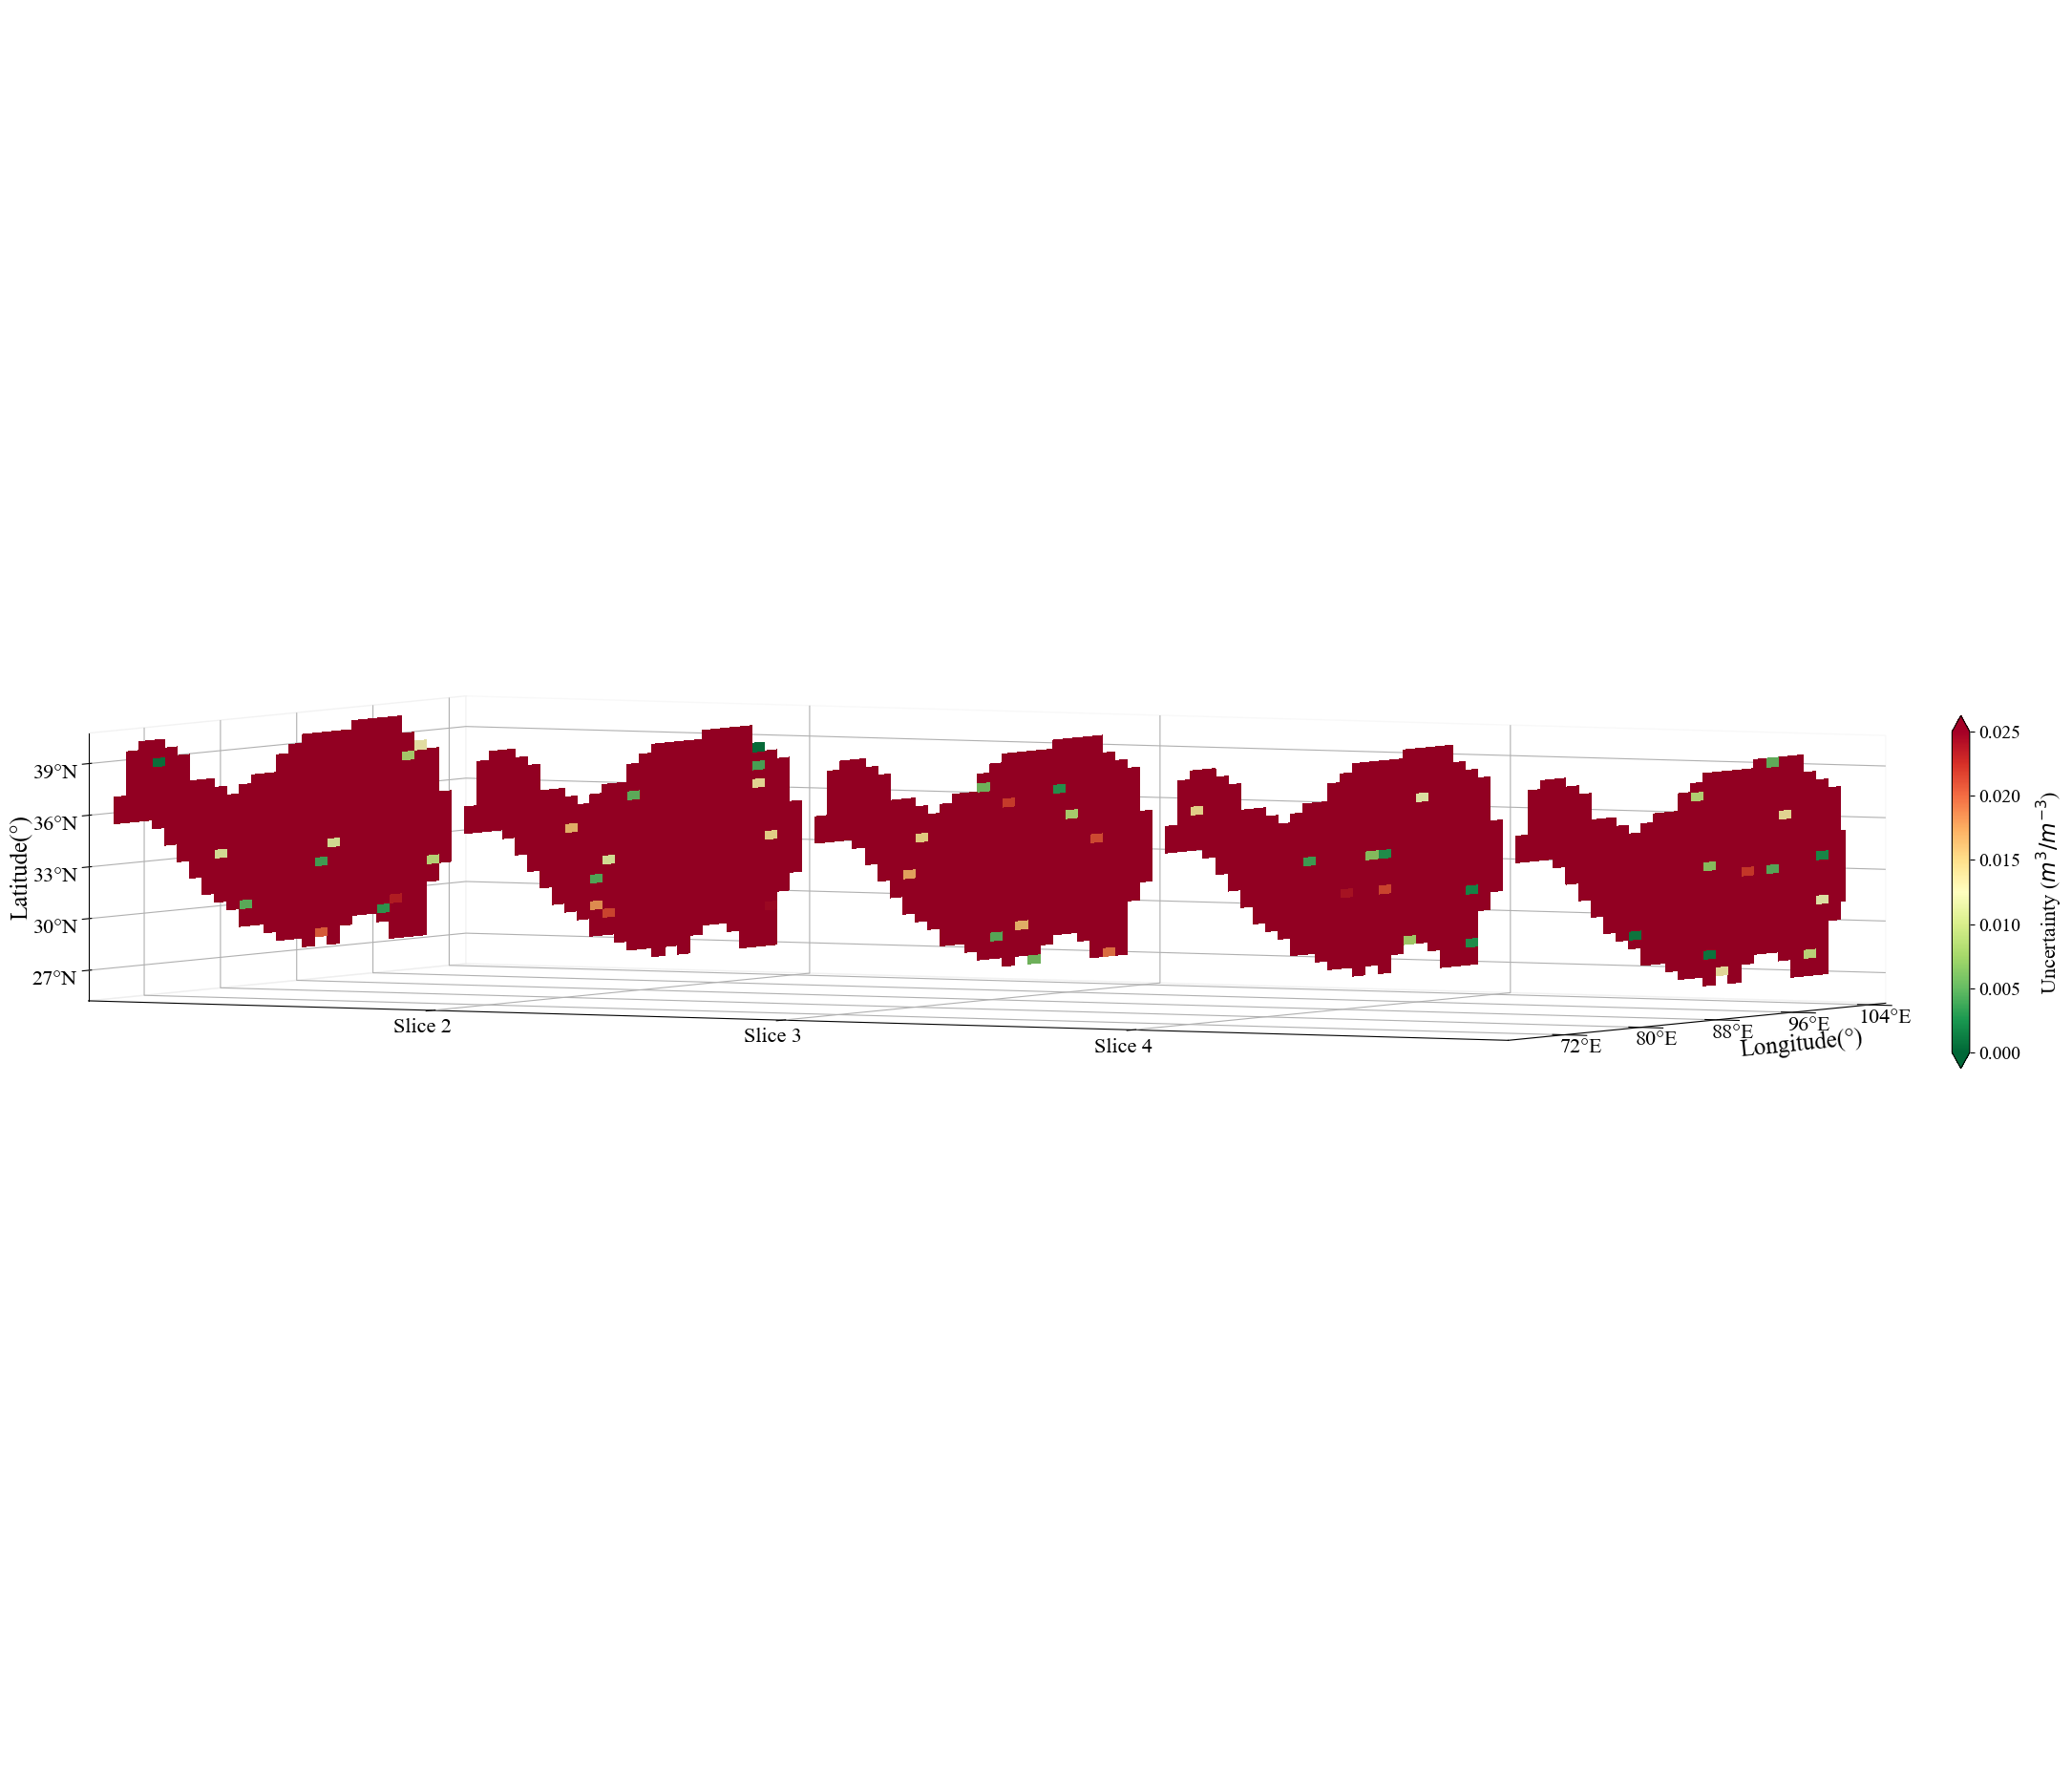

In [10]:
def add_degree_E(x, pos):
    return f"{int(x)}°E"

def add_degree_N(y, pos):
    return f"{int(y)}°N"
def plot_data_slices(data_pieces, lon_range, lat_range, name):
    fig = plt.figure(figsize=(36, 24))
    ax = fig.add_subplot(111, projection='3d')
    lon_grid, lat_grid = np.meshgrid(lon_range, lat_range)
    y_positions = np.arange(len(data_pieces))

    # 收集所有数据用于计算颜色范围
    #all_data = np.concatenate([data.flatten() for _, data in data_pieces.items()])
    vmin = 0
    vmax = 0.025
    '''
    colors = ["#ffc43d", "#60d394"]
    cmap_name = "custom_orange_green"
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)

    # Create a gradient image
    gradient = np.linspace(0, 1, 256)
    gradient = np.vstack((gradient, gradient))
    '''
    # 创建归一化和映射对象
    norm = Normalize(vmin=vmin, vmax=vmax)
    mappable = ScalarMappable(norm=norm, cmap='RdYlGn_r')

    # 绘制每个数据片
    for i, (indicator, data) in enumerate(data_pieces.items()):
        colors = mappable.to_rgba(data)
        colors[np.isnan(data), -1] = 0
        ax.plot_surface(lon_grid, np.full(lon_grid.shape, y_positions[i]), lat_grid,
                        facecolors=colors, rstride=1, cstride=1, linewidth=0, antialiased=False)

    # 设置colorbar
    cbar = plt.colorbar(mappable, ax=ax, aspect=20, shrink=0.2, pad=0.04, orientation='vertical', extend='both')
    cbar.set_label('Uncertainty ($m^3/m^{-3}$)', rotation=90, labelpad=10, size=16)
    cbar.ax.tick_params(labelsize=14)

    # 设置刻度和标签
    ax.set_xlabel('Longitude(°)', labelpad=30,size=18, rotation=90)
    ax.set_zlabel('Latitude(°)', labelpad=5,size=18)
    ax.tick_params(axis='y', colors='black', length=8, width=1.5, labelsize=16, direction='out', pad=10)
    ax.tick_params(axis='x', colors='black', length=8, width=1.5, labelsize=16, direction='out', pad=0)
    ax.tick_params(axis='z', colors='black', length=5, width=1.5, labelsize=16, direction='out', pad=5)
    ax.set_yticks(y_positions)
    ax.set_yticklabels(list(data_pieces.keys()),size=16)

    # 设置绘图范围和刻度数目
    ax.set_xlim(max(lon_range)+0.01, min(lon_range)-0.01)
    ax.set_ylim(min(y_positions)+0.1, max(y_positions)-0.01)
    ax.set_zlim(min(lat_range)-0.01, max(lat_range)+0.01)
    ax.zaxis.set_major_locator(MaxNLocator(prune='lower', nbins=5))
    ax.xaxis.set_major_locator(MaxNLocator(prune='lower', nbins=5))
    ax.xaxis.set_major_formatter(FuncFormatter(add_degree_E))
    ax.zaxis.set_major_formatter(FuncFormatter(add_degree_N))

    # 去除背景色并调整视角
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.set_proj_type('ortho')
    ax.set_box_aspect([3, 6, 1])
    ax.view_init(elev=3, azim=28)
    plt.savefig(r"C:\Users\Administrator\Desktop\Draw\uncertain"+name+".png", dpi=500, format='png', bbox_inches='tight')
    plt.show()


rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']
plot_data_slices(clipped_data_pieces, lon_range, lat_range, name='a')